In [1]:
# train a generative adversarial network on a one-dimensional function
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot as plt
import pandas as pd
import random

# DEFINE DISCRIMINATOR MODEL
Diskriminator bekommt ein SAMPLE aus den echten Daten (hier aus den 200 echten Werten nur 2) und wirft wahr oder falsch aus.

In [2]:
# define the standalone discriminator model
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# DEFINE GENERATOR MODEL
Generator bekommt einen Punkt aus dem Latenten Raum undd generiert daraus ein neues Sample, bspw. Vektor mit input und output der Funktion (f(x) = x^2 dann x und y).

The weights in the generator model are updated based on the performance of the discriminator model.

Specifically, a new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space, generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.

In [3]:
# define the standalone generator model'
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

# DEFINE GAN MODEL INCLUDING GENERATOR AND DISCRIMINATOR
Input: Point in latent space; Output: Binary classification (real, fake)

The weights in the discriminator are marked as not trainable, which only affects the weights as seen by the GAN model and not the standalone discriminator model.

In [4]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# LOAD REAL DATA EXAMPLE

In [5]:
# generate n real samples with class labels
def generate_real_samples(n):
    # generate inputs in [-0.5, 0.5]
    X1 = rand(n) - 0.5
    # generate outputs X^2
    X2 = X1 * X1
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = hstack((X1, X2))
    # generate class labels
    y = ones((n, 1))
    return X, y

# TODO: LOAD OUR DATA AND BRING IT IN FORM

In [6]:
def generate_real_samples(path_sensor, n):
    # get number of rows
    fs = sum(1 for line in open(path_sensor)) - 1
    # get percentage from batchsize and filesize
    p = 100 * n / fs
    # print('Percentage:', p)
    # keep the header, then take only p% of lines
    # if random from [0,1] interval is greater than 0.01 the row will be skipped
    X1= pd.read_csv(
             path_sensor,
             header=0, 
             skiprows=lambda i: i>0 and random.random() > p
    ).to_numpy()
    X1 = X1[:,0]
    # reshape data and c
    X1 = X1.reshape(n, 1)
    X2 = np.arange(n).reshape(n, 1)
    print(X1.shape, X2.shape)
    X = hstack((X1, X2))
    # create label
    y = np.ones((n, 1))
    return X, y

In [7]:
def generate_real_samples(path_sensor, n):
    # print('::generate_real_samples::')
    # import data
    global data
    X = data
    #number of records in file (excludes header) fs->filesize
    fs = sum(1 for line in open(path_sensor)) - 1
    # print('file size:', fs)
    # get random start point
    r = int(random.uniform(1, fs))
    # print('random:', r)
    # check if start point has n numbers to the end
    if fs-r>=n:
        # read csv file skip r rows
        X1 = pd.read_csv(path_sensor, skiprows=r, nrows=n).to_numpy()
        X1 = X1[:,0]
        # reshape data and c
        X1 = X1.reshape(n, 1)
        X2 = np.arange(n).reshape(n, 1)
        # print(X1.shape, X2.shape)
        X = hstack((X1, X2))
        # create label
        y = np.ones((n, 1))
        return X, y
    else:
        return generate_real_samples(path_sensor, n)

In [8]:
# THIS WORKS!!! I GUESS!!!
def generate_real_samples(path_sensor, n):
    # print('::generate_real_samples::')
    # import data
    global data
    X1 = data
    #number of records in file (excludes header) fs->filesize
    fs = X1.shape[0]
    # print('file size:', fs)
    # get random start point
    r = int(random.uniform(1, fs))
    # print('random:', r)
    # check if start point has n numbers to the end
    if fs-r>=n:
        # reshape data and c
        X1 = X1[r:(r+n)]
        X1 = X1.reshape(n, 1)
        X2 = np.arange(n).reshape(n, 1)
        # print('shapes X1, X2:', X1.shape, X2.shape)
        X = hstack((X1, X2))
        # print('shape X:', X.shape)
        # create label
        y = np.ones((n, 1))
        return X, y
    else:
        return generate_real_samples(path_sensor, n)

In [9]:
def load_data(path_sensor):
    X = pd.read_csv(path_sensor).to_numpy()
    X = X[:,0]
    # no labels and x coord yet!!!
    return X

# n RANDOM WERTE AUS DEM LATENTEN RAUM

In [10]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    # print('gen latent pts lat_dim, n:', latent_dim, n)
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

# PREDICT SAMPLES USING GENERATOR & RANDOM LATENT SAMPLES

In [11]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y

# EVALUATING PERFORMANCE
1st Generate real samples

2nd generate latent points

3rd generate fake samples from 2nd

4th plot both samples in one plot and compare

Having both samples plotted on the same graph allows them to be directly compared to see if the same input and output domain are covered and whether the expected shape of the target function has been appropriately captured, at least subjectively.
# SUMMARIZE PERFORMANCE
The summarize_performance() function below can be called any time during training to create a scatter plot of real and generated points to get an idea of the current capability of the generator model.

We may also be interested in the performance of the discriminator model at the same time.

Specifically, we are interested to know how well the discriminator model can correctly identify real and fake samples. A good generator model should make the discriminator model confused, resulting in a classification accuracy closer to 50% on real and fake examples.

In [12]:
# evaluate the discriminator and plot real and fake points
def summarize_performance_plot(epoch, generator, discriminator, latent_dim, path_sensor, n=100):
    global accarr_real, accarr_fake
    # prepare real samples
    x_real, y_real = generate_real_samples(path_sensor, n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    accarr_real.append(acc_real)
    accarr_fake.append(acc_fake)
    print('Epoch:', epoch, 'Accurracy real:', acc_real, 'Accurracy fake:', acc_fake)
    # scatter plot real and fake data points
    plt.plot(x_real[:, 1], x_real[:, 0], color='red')
    plt.scatter(x_fake[:, 1], x_fake[:, 0], color='blue', s=2)
    plt.show()

In [13]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, path_sensor, n=100):
    global accarr_real, accarr_fake
    # prepare real samples
    x_real, y_real = generate_real_samples(path_sensor, n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    accarr_real.append(acc_real)
    accarr_fake.append(acc_fake)
    print('Epoch:', epoch, 'Accurracy real:', acc_real, 'Accurracy fake:', acc_fake)
    # scatter plot real and fake data points
    #plt.scatter(x_real[:, 0], x_real[:, 1], color='red')
    #plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    #plt.show()

# TRAIN COMPOSITE MODEL
Input: random points in latent space, Output: Binary Classification (real, fake)

What is required is that we first update the discriminator model with real and fake samples, then update the generator via the composite model.

This requires combining elements from the train_discriminator() function defined in the discriminator section and the train_gan() function defined above. It also requires that the generate_fake_samples() function use the generator model to generate fake samples instead of generating random numbers.

Furthermore implement the evaluation functions every n_eval epochs.

In [14]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, path_sensor, n_epochs=10000, n_batch=128, n_eval=2000):
    global accarr_real, accarr_fake
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    print('::TRAIN:: n_batch', n_batch, 'half_batch', half_batch)
    # manually enumerate epochs
    for i in range(n_epochs):
        
        # prepare real samples
        x_real, y_real = generate_real_samples(path_sensor, half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        
        # plot evaluation of the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance_plot(i, g_model, d_model, latent_dim, path_sensor, n_batch)
        #evaluate the model every epoch
        else:
            summarize_performance(i, g_model, d_model, latent_dim, path_sensor, n_batch)

# __MAIN__

Metal device set to: Apple M1 Pro
::TRAIN:: n_batch 64 half_batch 32


2022-07-03 12:55:54.851824: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-03 12:55:54.851949: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-07-03 12:55:54.931522: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-03 12:55:54.956756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-03 12:55:55.175267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-03 12:55:55.393108: I tensorflow/core/grappler/o

Epoch: 0 Accurracy real: 0.984375 Accurracy fake: 0.0
Epoch: 1 Accurracy real: 0.984375 Accurracy fake: 0.015625
Epoch: 2 Accurracy real: 0.96875 Accurracy fake: 0.0
Epoch: 3 Accurracy real: 0.953125 Accurracy fake: 0.0
Epoch: 4 Accurracy real: 0.984375 Accurracy fake: 0.0
Epoch: 5 Accurracy real: 1.0 Accurracy fake: 0.0
Epoch: 6 Accurracy real: 0.984375 Accurracy fake: 0.015625
Epoch: 7 Accurracy real: 0.984375 Accurracy fake: 0.0
Epoch: 8 Accurracy real: 0.984375 Accurracy fake: 0.0
Epoch: 9 Accurracy real: 0.8125 Accurracy fake: 0.0
Epoch: 10 Accurracy real: 0.984375 Accurracy fake: 0.015625
Epoch: 11 Accurracy real: 0.984375 Accurracy fake: 0.03125
Epoch: 12 Accurracy real: 1.0 Accurracy fake: 0.03125
Epoch: 13 Accurracy real: 1.0 Accurracy fake: 0.0
Epoch: 14 Accurracy real: 0.984375 Accurracy fake: 0.0
Epoch: 15 Accurracy real: 0.96875 Accurracy fake: 0.0
Epoch: 16 Accurracy real: 0.984375 Accurracy fake: 0.015625
Epoch: 17 Accurracy real: 1.0 Accurracy fake: 0.015625
Epoch: 18 A

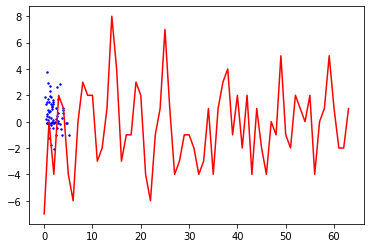

Epoch: 50 Accurracy real: 1.0 Accurracy fake: 0.1875
Epoch: 51 Accurracy real: 1.0 Accurracy fake: 0.125
Epoch: 52 Accurracy real: 1.0 Accurracy fake: 0.203125
Epoch: 53 Accurracy real: 0.984375 Accurracy fake: 0.21875
Epoch: 54 Accurracy real: 1.0 Accurracy fake: 0.171875
Epoch: 55 Accurracy real: 1.0 Accurracy fake: 0.1875
Epoch: 56 Accurracy real: 1.0 Accurracy fake: 0.3125
Epoch: 57 Accurracy real: 1.0 Accurracy fake: 0.28125
Epoch: 58 Accurracy real: 1.0 Accurracy fake: 0.28125
Epoch: 59 Accurracy real: 0.984375 Accurracy fake: 0.28125
Epoch: 60 Accurracy real: 1.0 Accurracy fake: 0.21875
Epoch: 61 Accurracy real: 0.984375 Accurracy fake: 0.3125
Epoch: 62 Accurracy real: 0.96875 Accurracy fake: 0.328125
Epoch: 63 Accurracy real: 0.984375 Accurracy fake: 0.390625
Epoch: 64 Accurracy real: 1.0 Accurracy fake: 0.34375
Epoch: 65 Accurracy real: 1.0 Accurracy fake: 0.25
Epoch: 66 Accurracy real: 0.984375 Accurracy fake: 0.34375
Epoch: 67 Accurracy real: 1.0 Accurracy fake: 0.359375
Epo

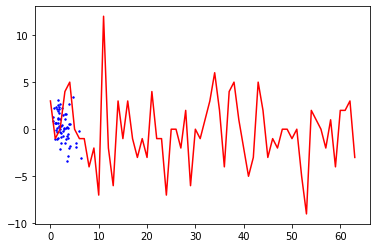

Epoch: 100 Accurracy real: 0.984375 Accurracy fake: 0.5
Epoch: 101 Accurracy real: 0.984375 Accurracy fake: 0.65625
Epoch: 102 Accurracy real: 0.953125 Accurracy fake: 0.640625
Epoch: 103 Accurracy real: 0.96875 Accurracy fake: 0.640625
Epoch: 104 Accurracy real: 0.96875 Accurracy fake: 0.578125
Epoch: 105 Accurracy real: 0.984375 Accurracy fake: 0.578125
Epoch: 106 Accurracy real: 0.984375 Accurracy fake: 0.53125
Epoch: 107 Accurracy real: 0.953125 Accurracy fake: 0.53125
Epoch: 108 Accurracy real: 0.953125 Accurracy fake: 0.546875
Epoch: 109 Accurracy real: 0.953125 Accurracy fake: 0.5
Epoch: 110 Accurracy real: 0.953125 Accurracy fake: 0.640625
Epoch: 111 Accurracy real: 0.984375 Accurracy fake: 0.53125
Epoch: 112 Accurracy real: 0.984375 Accurracy fake: 0.53125
Epoch: 113 Accurracy real: 0.953125 Accurracy fake: 0.625
Epoch: 114 Accurracy real: 1.0 Accurracy fake: 0.703125
Epoch: 115 Accurracy real: 0.953125 Accurracy fake: 0.75
Epoch: 116 Accurracy real: 0.96875 Accurracy fake: 0.

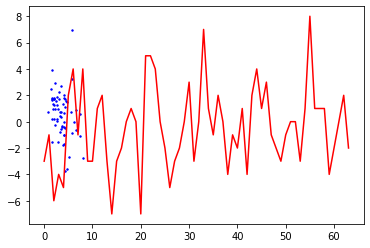

Epoch: 150 Accurracy real: 0.96875 Accurracy fake: 0.609375
Epoch: 151 Accurracy real: 0.9375 Accurracy fake: 0.5625
Epoch: 152 Accurracy real: 0.984375 Accurracy fake: 0.5625
Epoch: 153 Accurracy real: 0.96875 Accurracy fake: 0.5625
Epoch: 154 Accurracy real: 0.96875 Accurracy fake: 0.53125
Epoch: 155 Accurracy real: 0.96875 Accurracy fake: 0.671875
Epoch: 156 Accurracy real: 0.9375 Accurracy fake: 0.6875
Epoch: 157 Accurracy real: 0.96875 Accurracy fake: 0.578125
Epoch: 158 Accurracy real: 0.953125 Accurracy fake: 0.65625
Epoch: 159 Accurracy real: 0.953125 Accurracy fake: 0.65625
Epoch: 160 Accurracy real: 0.96875 Accurracy fake: 0.65625
Epoch: 161 Accurracy real: 0.9375 Accurracy fake: 0.703125
Epoch: 162 Accurracy real: 0.953125 Accurracy fake: 0.6875
Epoch: 163 Accurracy real: 0.96875 Accurracy fake: 0.75
Epoch: 164 Accurracy real: 0.90625 Accurracy fake: 0.734375
Epoch: 165 Accurracy real: 0.9375 Accurracy fake: 0.640625
Epoch: 166 Accurracy real: 0.9375 Accurracy fake: 0.671875

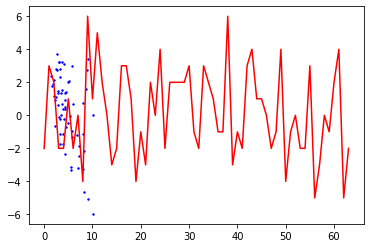

Epoch: 200 Accurracy real: 0.96875 Accurracy fake: 0.5
Epoch: 201 Accurracy real: 0.921875 Accurracy fake: 0.703125
Epoch: 202 Accurracy real: 0.9375 Accurracy fake: 0.640625
Epoch: 203 Accurracy real: 0.96875 Accurracy fake: 0.6875
Epoch: 204 Accurracy real: 0.96875 Accurracy fake: 0.71875
Epoch: 205 Accurracy real: 0.953125 Accurracy fake: 0.59375
Epoch: 206 Accurracy real: 0.921875 Accurracy fake: 0.6875
Epoch: 207 Accurracy real: 0.90625 Accurracy fake: 0.703125
Epoch: 208 Accurracy real: 0.921875 Accurracy fake: 0.734375
Epoch: 209 Accurracy real: 0.953125 Accurracy fake: 0.71875
Epoch: 210 Accurracy real: 0.984375 Accurracy fake: 0.71875
Epoch: 211 Accurracy real: 0.953125 Accurracy fake: 0.640625
Epoch: 212 Accurracy real: 0.921875 Accurracy fake: 0.6875
Epoch: 213 Accurracy real: 0.921875 Accurracy fake: 0.71875
Epoch: 214 Accurracy real: 0.9375 Accurracy fake: 0.640625
Epoch: 215 Accurracy real: 0.90625 Accurracy fake: 0.765625
Epoch: 216 Accurracy real: 0.921875 Accurracy fak

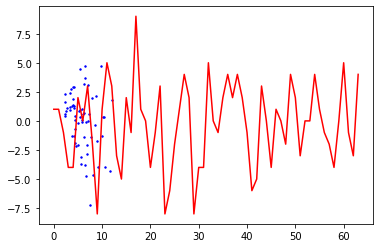

Epoch: 250 Accurracy real: 0.890625 Accurracy fake: 0.6875
Epoch: 251 Accurracy real: 0.890625 Accurracy fake: 0.6875
Epoch: 252 Accurracy real: 0.90625 Accurracy fake: 0.75
Epoch: 253 Accurracy real: 0.90625 Accurracy fake: 0.8125
Epoch: 254 Accurracy real: 0.9375 Accurracy fake: 0.703125
Epoch: 255 Accurracy real: 0.984375 Accurracy fake: 0.796875
Epoch: 256 Accurracy real: 0.9375 Accurracy fake: 0.765625
Epoch: 257 Accurracy real: 0.90625 Accurracy fake: 0.828125
Epoch: 258 Accurracy real: 0.9375 Accurracy fake: 0.71875
Epoch: 259 Accurracy real: 0.921875 Accurracy fake: 0.609375
Epoch: 260 Accurracy real: 0.921875 Accurracy fake: 0.84375
Epoch: 261 Accurracy real: 0.90625 Accurracy fake: 0.65625
Epoch: 262 Accurracy real: 0.90625 Accurracy fake: 0.71875
Epoch: 263 Accurracy real: 0.921875 Accurracy fake: 0.765625
Epoch: 264 Accurracy real: 0.921875 Accurracy fake: 0.734375
Epoch: 265 Accurracy real: 1.0 Accurracy fake: 0.75
Epoch: 266 Accurracy real: 0.921875 Accurracy fake: 0.6875

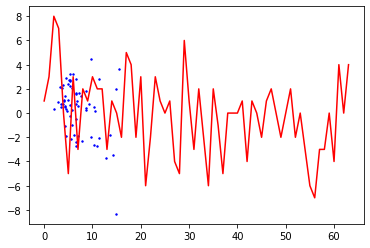

Epoch: 300 Accurracy real: 0.890625 Accurracy fake: 0.671875
Epoch: 301 Accurracy real: 0.84375 Accurracy fake: 0.765625
Epoch: 302 Accurracy real: 0.890625 Accurracy fake: 0.734375
Epoch: 303 Accurracy real: 0.9375 Accurracy fake: 0.703125
Epoch: 304 Accurracy real: 0.90625 Accurracy fake: 0.796875
Epoch: 305 Accurracy real: 0.90625 Accurracy fake: 0.640625
Epoch: 306 Accurracy real: 0.859375 Accurracy fake: 0.6875
Epoch: 307 Accurracy real: 0.875 Accurracy fake: 0.75
Epoch: 308 Accurracy real: 0.875 Accurracy fake: 0.78125
Epoch: 309 Accurracy real: 0.859375 Accurracy fake: 0.796875
Epoch: 310 Accurracy real: 0.890625 Accurracy fake: 0.640625
Epoch: 311 Accurracy real: 0.890625 Accurracy fake: 0.75
Epoch: 312 Accurracy real: 0.859375 Accurracy fake: 0.640625
Epoch: 313 Accurracy real: 0.84375 Accurracy fake: 0.6875
Epoch: 314 Accurracy real: 0.90625 Accurracy fake: 0.84375
Epoch: 315 Accurracy real: 0.921875 Accurracy fake: 0.625
Epoch: 316 Accurracy real: 0.890625 Accurracy fake: 0.

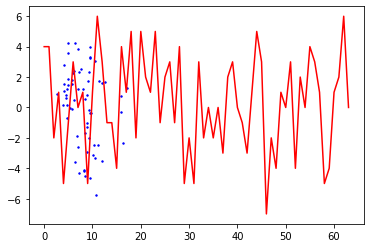

Epoch: 350 Accurracy real: 0.890625 Accurracy fake: 0.703125
Epoch: 351 Accurracy real: 0.921875 Accurracy fake: 0.65625
Epoch: 352 Accurracy real: 0.875 Accurracy fake: 0.671875
Epoch: 353 Accurracy real: 0.875 Accurracy fake: 0.796875
Epoch: 354 Accurracy real: 0.84375 Accurracy fake: 0.75
Epoch: 355 Accurracy real: 0.859375 Accurracy fake: 0.765625
Epoch: 356 Accurracy real: 0.828125 Accurracy fake: 0.765625
Epoch: 357 Accurracy real: 0.859375 Accurracy fake: 0.75
Epoch: 358 Accurracy real: 0.859375 Accurracy fake: 0.796875
Epoch: 359 Accurracy real: 0.8125 Accurracy fake: 0.65625
Epoch: 360 Accurracy real: 0.859375 Accurracy fake: 0.8125
Epoch: 361 Accurracy real: 0.859375 Accurracy fake: 0.828125
Epoch: 362 Accurracy real: 0.875 Accurracy fake: 0.671875
Epoch: 363 Accurracy real: 0.84375 Accurracy fake: 0.796875
Epoch: 364 Accurracy real: 0.84375 Accurracy fake: 0.828125
Epoch: 365 Accurracy real: 0.828125 Accurracy fake: 0.625
Epoch: 366 Accurracy real: 0.859375 Accurracy fake: 0

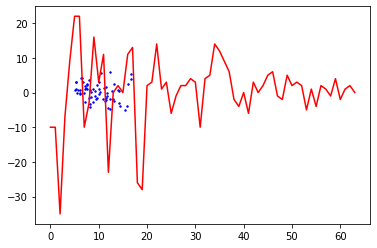

Epoch: 400 Accurracy real: 0.828125 Accurracy fake: 0.859375
Epoch: 401 Accurracy real: 0.828125 Accurracy fake: 0.75
Epoch: 402 Accurracy real: 0.84375 Accurracy fake: 0.84375
Epoch: 403 Accurracy real: 0.921875 Accurracy fake: 0.84375
Epoch: 404 Accurracy real: 0.859375 Accurracy fake: 0.71875
Epoch: 405 Accurracy real: 0.84375 Accurracy fake: 0.734375
Epoch: 406 Accurracy real: 0.828125 Accurracy fake: 0.75
Epoch: 407 Accurracy real: 0.8125 Accurracy fake: 0.640625
Epoch: 408 Accurracy real: 0.984375 Accurracy fake: 0.71875
Epoch: 409 Accurracy real: 0.828125 Accurracy fake: 0.765625
Epoch: 410 Accurracy real: 0.828125 Accurracy fake: 0.703125
Epoch: 411 Accurracy real: 1.0 Accurracy fake: 0.75
Epoch: 412 Accurracy real: 0.859375 Accurracy fake: 0.703125
Epoch: 413 Accurracy real: 0.875 Accurracy fake: 0.734375
Epoch: 414 Accurracy real: 0.84375 Accurracy fake: 0.6875
Epoch: 415 Accurracy real: 0.8125 Accurracy fake: 0.734375
Epoch: 416 Accurracy real: 0.859375 Accurracy fake: 0.796

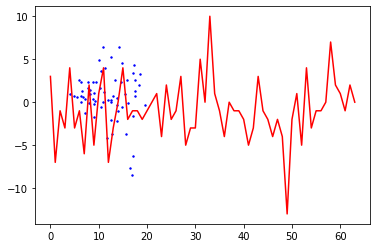

Epoch: 450 Accurracy real: 0.78125 Accurracy fake: 0.84375
Epoch: 451 Accurracy real: 0.78125 Accurracy fake: 0.8125
Epoch: 452 Accurracy real: 0.828125 Accurracy fake: 0.75
Epoch: 453 Accurracy real: 0.75 Accurracy fake: 0.765625
Epoch: 454 Accurracy real: 0.8125 Accurracy fake: 0.8125
Epoch: 455 Accurracy real: 0.796875 Accurracy fake: 0.796875
Epoch: 456 Accurracy real: 0.96875 Accurracy fake: 0.734375
Epoch: 457 Accurracy real: 0.828125 Accurracy fake: 0.734375
Epoch: 458 Accurracy real: 0.859375 Accurracy fake: 0.78125
Epoch: 459 Accurracy real: 0.78125 Accurracy fake: 0.546875
Epoch: 460 Accurracy real: 0.8125 Accurracy fake: 0.828125
Epoch: 461 Accurracy real: 0.8125 Accurracy fake: 0.78125
Epoch: 462 Accurracy real: 0.8125 Accurracy fake: 0.84375
Epoch: 463 Accurracy real: 0.796875 Accurracy fake: 0.78125
Epoch: 464 Accurracy real: 0.796875 Accurracy fake: 0.8125
Epoch: 465 Accurracy real: 0.796875 Accurracy fake: 0.765625
Epoch: 466 Accurracy real: 0.8125 Accurracy fake: 0.812

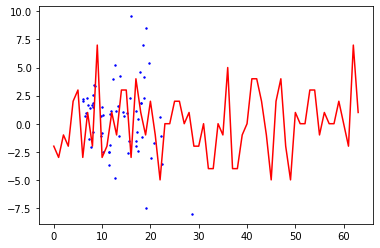

Epoch: 500 Accurracy real: 0.78125 Accurracy fake: 0.671875
Epoch: 501 Accurracy real: 0.796875 Accurracy fake: 0.828125
Epoch: 502 Accurracy real: 0.78125 Accurracy fake: 0.671875
Epoch: 503 Accurracy real: 0.78125 Accurracy fake: 0.796875
Epoch: 504 Accurracy real: 0.78125 Accurracy fake: 0.796875
Epoch: 505 Accurracy real: 0.78125 Accurracy fake: 0.828125
Epoch: 506 Accurracy real: 0.765625 Accurracy fake: 0.78125
Epoch: 507 Accurracy real: 0.75 Accurracy fake: 0.78125
Epoch: 508 Accurracy real: 0.78125 Accurracy fake: 0.609375
Epoch: 509 Accurracy real: 0.796875 Accurracy fake: 0.734375
Epoch: 510 Accurracy real: 0.75 Accurracy fake: 0.734375
Epoch: 511 Accurracy real: 0.765625 Accurracy fake: 0.8125
Epoch: 512 Accurracy real: 0.75 Accurracy fake: 0.765625
Epoch: 513 Accurracy real: 0.75 Accurracy fake: 0.78125
Epoch: 514 Accurracy real: 0.796875 Accurracy fake: 0.828125
Epoch: 515 Accurracy real: 0.765625 Accurracy fake: 0.796875
Epoch: 516 Accurracy real: 0.78125 Accurracy fake: 

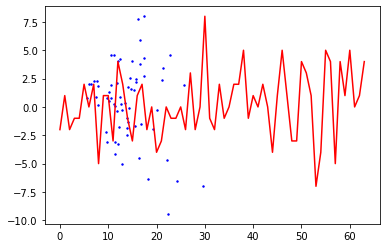

Epoch: 550 Accurracy real: 0.6875 Accurracy fake: 0.859375
Epoch: 551 Accurracy real: 0.8125 Accurracy fake: 0.9375
Epoch: 552 Accurracy real: 0.703125 Accurracy fake: 0.953125
Epoch: 553 Accurracy real: 0.6875 Accurracy fake: 0.875
Epoch: 554 Accurracy real: 0.71875 Accurracy fake: 0.796875
Epoch: 555 Accurracy real: 0.734375 Accurracy fake: 0.828125
Epoch: 556 Accurracy real: 0.703125 Accurracy fake: 0.78125
Epoch: 557 Accurracy real: 0.8125 Accurracy fake: 0.71875
Epoch: 558 Accurracy real: 0.75 Accurracy fake: 0.75
Epoch: 559 Accurracy real: 0.71875 Accurracy fake: 0.734375
Epoch: 560 Accurracy real: 0.765625 Accurracy fake: 0.71875
Epoch: 561 Accurracy real: 0.765625 Accurracy fake: 0.796875
Epoch: 562 Accurracy real: 0.75 Accurracy fake: 0.65625
Epoch: 563 Accurracy real: 0.71875 Accurracy fake: 0.6875
Epoch: 564 Accurracy real: 0.703125 Accurracy fake: 0.859375
Epoch: 565 Accurracy real: 0.71875 Accurracy fake: 0.8125
Epoch: 566 Accurracy real: 0.71875 Accurracy fake: 0.859375
E

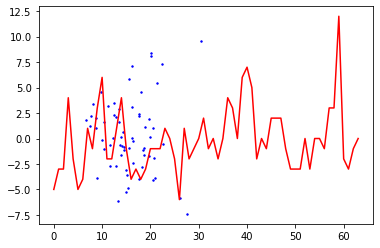

Epoch: 600 Accurracy real: 0.703125 Accurracy fake: 0.796875
Epoch: 601 Accurracy real: 0.734375 Accurracy fake: 0.75
Epoch: 602 Accurracy real: 0.75 Accurracy fake: 0.828125
Epoch: 603 Accurracy real: 0.703125 Accurracy fake: 0.8125
Epoch: 604 Accurracy real: 0.71875 Accurracy fake: 0.796875
Epoch: 605 Accurracy real: 0.703125 Accurracy fake: 0.828125
Epoch: 606 Accurracy real: 0.703125 Accurracy fake: 0.84375
Epoch: 607 Accurracy real: 0.6875 Accurracy fake: 0.84375
Epoch: 608 Accurracy real: 0.703125 Accurracy fake: 0.84375
Epoch: 609 Accurracy real: 0.703125 Accurracy fake: 0.90625
Epoch: 610 Accurracy real: 0.703125 Accurracy fake: 0.890625
Epoch: 611 Accurracy real: 0.796875 Accurracy fake: 0.859375
Epoch: 612 Accurracy real: 0.6875 Accurracy fake: 0.84375
Epoch: 613 Accurracy real: 0.71875 Accurracy fake: 0.796875
Epoch: 614 Accurracy real: 0.984375 Accurracy fake: 0.796875
Epoch: 615 Accurracy real: 0.75 Accurracy fake: 0.828125
Epoch: 616 Accurracy real: 0.765625 Accurracy fak

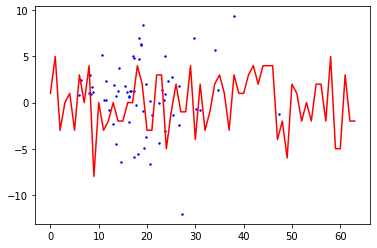

Epoch: 650 Accurracy real: 0.6875 Accurracy fake: 0.921875
Epoch: 651 Accurracy real: 0.671875 Accurracy fake: 0.8125
Epoch: 652 Accurracy real: 0.71875 Accurracy fake: 0.828125
Epoch: 653 Accurracy real: 0.703125 Accurracy fake: 0.796875
Epoch: 654 Accurracy real: 0.734375 Accurracy fake: 0.84375
Epoch: 655 Accurracy real: 0.734375 Accurracy fake: 0.859375
Epoch: 656 Accurracy real: 0.6875 Accurracy fake: 0.796875
Epoch: 657 Accurracy real: 0.671875 Accurracy fake: 0.796875
Epoch: 658 Accurracy real: 0.65625 Accurracy fake: 0.84375
Epoch: 659 Accurracy real: 0.75 Accurracy fake: 0.796875
Epoch: 660 Accurracy real: 0.703125 Accurracy fake: 0.859375
Epoch: 661 Accurracy real: 0.640625 Accurracy fake: 0.90625
Epoch: 662 Accurracy real: 0.671875 Accurracy fake: 0.8125
Epoch: 663 Accurracy real: 0.6875 Accurracy fake: 0.796875
Epoch: 664 Accurracy real: 0.640625 Accurracy fake: 0.859375
Epoch: 665 Accurracy real: 0.5625 Accurracy fake: 0.890625
Epoch: 666 Accurracy real: 0.609375 Accurracy

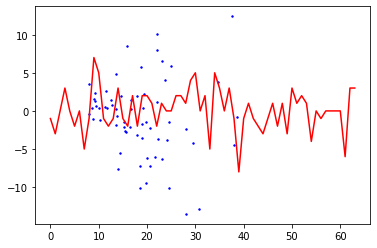

Epoch: 700 Accurracy real: 0.71875 Accurracy fake: 0.765625
Epoch: 701 Accurracy real: 0.65625 Accurracy fake: 0.75
Epoch: 702 Accurracy real: 0.671875 Accurracy fake: 0.71875
Epoch: 703 Accurracy real: 0.671875 Accurracy fake: 0.796875
Epoch: 704 Accurracy real: 0.625 Accurracy fake: 0.78125
Epoch: 705 Accurracy real: 0.703125 Accurracy fake: 0.875
Epoch: 706 Accurracy real: 0.71875 Accurracy fake: 0.796875
Epoch: 707 Accurracy real: 0.6875 Accurracy fake: 0.703125
Epoch: 708 Accurracy real: 0.65625 Accurracy fake: 0.65625
Epoch: 709 Accurracy real: 0.6875 Accurracy fake: 0.859375
Epoch: 710 Accurracy real: 0.6875 Accurracy fake: 0.71875
Epoch: 711 Accurracy real: 0.6875 Accurracy fake: 0.78125
Epoch: 712 Accurracy real: 0.703125 Accurracy fake: 0.640625
Epoch: 713 Accurracy real: 0.71875 Accurracy fake: 0.75
Epoch: 714 Accurracy real: 0.75 Accurracy fake: 0.671875
Epoch: 715 Accurracy real: 0.734375 Accurracy fake: 0.71875
Epoch: 716 Accurracy real: 0.9375 Accurracy fake: 0.578125
Ep

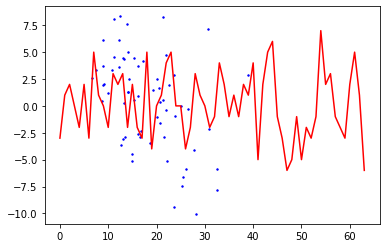

Epoch: 750 Accurracy real: 0.625 Accurracy fake: 0.9375
Epoch: 751 Accurracy real: 0.59375 Accurracy fake: 0.828125
Epoch: 752 Accurracy real: 0.609375 Accurracy fake: 0.890625
Epoch: 753 Accurracy real: 0.578125 Accurracy fake: 0.859375
Epoch: 754 Accurracy real: 0.625 Accurracy fake: 0.859375
Epoch: 755 Accurracy real: 0.671875 Accurracy fake: 0.78125
Epoch: 756 Accurracy real: 0.640625 Accurracy fake: 0.765625
Epoch: 757 Accurracy real: 0.640625 Accurracy fake: 0.828125
Epoch: 758 Accurracy real: 0.609375 Accurracy fake: 0.78125
Epoch: 759 Accurracy real: 0.671875 Accurracy fake: 0.765625
Epoch: 760 Accurracy real: 0.53125 Accurracy fake: 0.75
Epoch: 761 Accurracy real: 0.65625 Accurracy fake: 0.75
Epoch: 762 Accurracy real: 0.640625 Accurracy fake: 0.84375
Epoch: 763 Accurracy real: 0.5625 Accurracy fake: 0.859375
Epoch: 764 Accurracy real: 0.609375 Accurracy fake: 0.875
Epoch: 765 Accurracy real: 0.5625 Accurracy fake: 0.890625
Epoch: 766 Accurracy real: 0.5625 Accurracy fake: 0.8

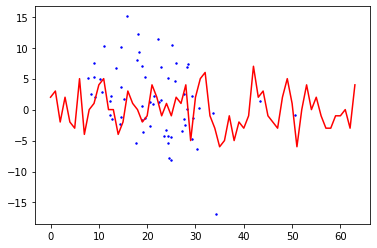

Epoch: 800 Accurracy real: 0.515625 Accurracy fake: 0.84375
Epoch: 801 Accurracy real: 0.59375 Accurracy fake: 0.796875
Epoch: 802 Accurracy real: 0.703125 Accurracy fake: 0.71875
Epoch: 803 Accurracy real: 0.59375 Accurracy fake: 0.859375
Epoch: 804 Accurracy real: 0.625 Accurracy fake: 0.6875
Epoch: 805 Accurracy real: 0.609375 Accurracy fake: 0.78125
Epoch: 806 Accurracy real: 0.578125 Accurracy fake: 0.875
Epoch: 807 Accurracy real: 0.59375 Accurracy fake: 0.75
Epoch: 808 Accurracy real: 0.609375 Accurracy fake: 0.75
Epoch: 809 Accurracy real: 0.625 Accurracy fake: 0.796875
Epoch: 810 Accurracy real: 0.59375 Accurracy fake: 0.8125
Epoch: 811 Accurracy real: 0.5 Accurracy fake: 0.859375
Epoch: 812 Accurracy real: 0.515625 Accurracy fake: 0.828125
Epoch: 813 Accurracy real: 0.40625 Accurracy fake: 0.875
Epoch: 814 Accurracy real: 0.453125 Accurracy fake: 0.921875
Epoch: 815 Accurracy real: 0.46875 Accurracy fake: 0.859375
Epoch: 816 Accurracy real: 0.5 Accurracy fake: 0.921875
Epoch:

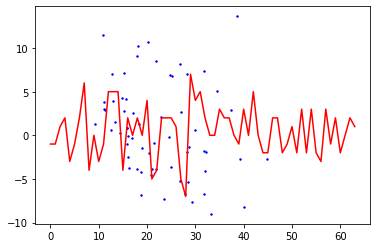

Epoch: 850 Accurracy real: 0.46875 Accurracy fake: 0.9375
Epoch: 851 Accurracy real: 0.40625 Accurracy fake: 0.984375
Epoch: 852 Accurracy real: 0.421875 Accurracy fake: 0.953125
Epoch: 853 Accurracy real: 0.4375 Accurracy fake: 0.984375
Epoch: 854 Accurracy real: 0.4375 Accurracy fake: 0.984375
Epoch: 855 Accurracy real: 0.4375 Accurracy fake: 0.921875
Epoch: 856 Accurracy real: 0.421875 Accurracy fake: 0.9375
Epoch: 857 Accurracy real: 0.453125 Accurracy fake: 0.984375
Epoch: 858 Accurracy real: 0.4375 Accurracy fake: 0.90625
Epoch: 859 Accurracy real: 0.453125 Accurracy fake: 0.84375
Epoch: 860 Accurracy real: 0.53125 Accurracy fake: 0.859375
Epoch: 861 Accurracy real: 0.484375 Accurracy fake: 0.921875
Epoch: 862 Accurracy real: 0.4375 Accurracy fake: 0.890625
Epoch: 863 Accurracy real: 0.4375 Accurracy fake: 0.890625
Epoch: 864 Accurracy real: 0.4375 Accurracy fake: 0.859375
Epoch: 865 Accurracy real: 0.4375 Accurracy fake: 0.9375
Epoch: 866 Accurracy real: 0.4375 Accurracy fake: 0

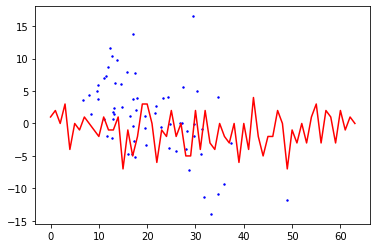

Epoch: 900 Accurracy real: 0.390625 Accurracy fake: 0.9375
Epoch: 901 Accurracy real: 0.390625 Accurracy fake: 0.96875
Epoch: 902 Accurracy real: 0.359375 Accurracy fake: 0.96875
Epoch: 903 Accurracy real: 0.40625 Accurracy fake: 1.0
Epoch: 904 Accurracy real: 0.375 Accurracy fake: 0.984375
Epoch: 905 Accurracy real: 0.359375 Accurracy fake: 0.96875
Epoch: 906 Accurracy real: 0.359375 Accurracy fake: 1.0
Epoch: 907 Accurracy real: 0.3125 Accurracy fake: 0.984375
Epoch: 908 Accurracy real: 0.34375 Accurracy fake: 0.96875
Epoch: 909 Accurracy real: 0.390625 Accurracy fake: 0.984375
Epoch: 910 Accurracy real: 0.34375 Accurracy fake: 0.96875
Epoch: 911 Accurracy real: 0.390625 Accurracy fake: 0.9375
Epoch: 912 Accurracy real: 0.40625 Accurracy fake: 0.953125
Epoch: 913 Accurracy real: 0.59375 Accurracy fake: 0.953125
Epoch: 914 Accurracy real: 0.4375 Accurracy fake: 1.0
Epoch: 915 Accurracy real: 0.46875 Accurracy fake: 0.90625
Epoch: 916 Accurracy real: 0.515625 Accurracy fake: 0.96875
Ep

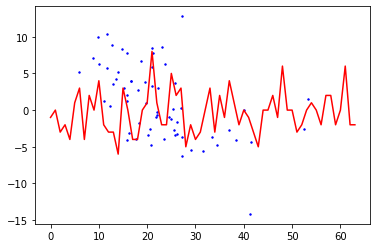

Epoch: 950 Accurracy real: 0.4375 Accurracy fake: 0.90625
Epoch: 951 Accurracy real: 0.421875 Accurracy fake: 0.96875
Epoch: 952 Accurracy real: 0.359375 Accurracy fake: 0.96875
Epoch: 953 Accurracy real: 0.390625 Accurracy fake: 0.96875
Epoch: 954 Accurracy real: 0.25 Accurracy fake: 0.96875
Epoch: 955 Accurracy real: 0.15625 Accurracy fake: 1.0
Epoch: 956 Accurracy real: 0.109375 Accurracy fake: 0.984375
Epoch: 957 Accurracy real: 0.109375 Accurracy fake: 1.0
Epoch: 958 Accurracy real: 0.078125 Accurracy fake: 0.984375
Epoch: 959 Accurracy real: 0.125 Accurracy fake: 1.0
Epoch: 960 Accurracy real: 0.109375 Accurracy fake: 0.984375
Epoch: 961 Accurracy real: 0.0625 Accurracy fake: 0.96875
Epoch: 962 Accurracy real: 0.0625 Accurracy fake: 0.96875
Epoch: 963 Accurracy real: 0.0625 Accurracy fake: 0.9375
Epoch: 964 Accurracy real: 0.140625 Accurracy fake: 0.96875
Epoch: 965 Accurracy real: 0.265625 Accurracy fake: 0.953125
Epoch: 966 Accurracy real: 0.328125 Accurracy fake: 0.890625
Epoc

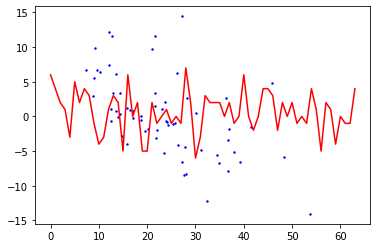

Epoch: 1000 Accurracy real: 0.0625 Accurracy fake: 0.96875
Epoch: 1001 Accurracy real: 0.203125 Accurracy fake: 0.953125
Epoch: 1002 Accurracy real: 0.09375 Accurracy fake: 0.96875
Epoch: 1003 Accurracy real: 0.109375 Accurracy fake: 0.953125
Epoch: 1004 Accurracy real: 0.078125 Accurracy fake: 0.953125
Epoch: 1005 Accurracy real: 0.0625 Accurracy fake: 1.0
Epoch: 1006 Accurracy real: 0.203125 Accurracy fake: 0.984375
Epoch: 1007 Accurracy real: 0.203125 Accurracy fake: 0.921875
Epoch: 1008 Accurracy real: 0.34375 Accurracy fake: 0.96875
Epoch: 1009 Accurracy real: 0.328125 Accurracy fake: 0.921875
Epoch: 1010 Accurracy real: 0.34375 Accurracy fake: 0.9375
Epoch: 1011 Accurracy real: 0.296875 Accurracy fake: 0.9375
Epoch: 1012 Accurracy real: 0.28125 Accurracy fake: 0.9375
Epoch: 1013 Accurracy real: 0.203125 Accurracy fake: 0.96875
Epoch: 1014 Accurracy real: 0.125 Accurracy fake: 0.953125
Epoch: 1015 Accurracy real: 0.0625 Accurracy fake: 0.96875
Epoch: 1016 Accurracy real: 0.0625 Ac

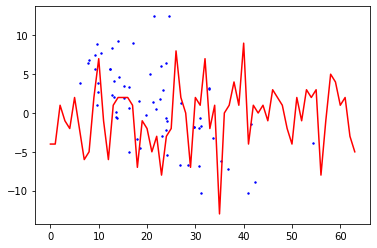

Epoch: 1050 Accurracy real: 0.21875 Accurracy fake: 1.0
Epoch: 1051 Accurracy real: 0.234375 Accurracy fake: 0.953125
Epoch: 1052 Accurracy real: 0.15625 Accurracy fake: 1.0
Epoch: 1053 Accurracy real: 0.09375 Accurracy fake: 0.984375
Epoch: 1054 Accurracy real: 0.046875 Accurracy fake: 0.96875
Epoch: 1055 Accurracy real: 0.09375 Accurracy fake: 0.96875
Epoch: 1056 Accurracy real: 0.828125 Accurracy fake: 0.96875
Epoch: 1057 Accurracy real: 0.0625 Accurracy fake: 0.9375
Epoch: 1058 Accurracy real: 0.109375 Accurracy fake: 0.96875
Epoch: 1059 Accurracy real: 0.0625 Accurracy fake: 0.984375
Epoch: 1060 Accurracy real: 0.078125 Accurracy fake: 0.953125
Epoch: 1061 Accurracy real: 0.109375 Accurracy fake: 0.984375
Epoch: 1062 Accurracy real: 0.09375 Accurracy fake: 1.0
Epoch: 1063 Accurracy real: 0.140625 Accurracy fake: 0.984375
Epoch: 1064 Accurracy real: 0.09375 Accurracy fake: 0.9375
Epoch: 1065 Accurracy real: 0.125 Accurracy fake: 0.96875
Epoch: 1066 Accurracy real: 0.109375 Accurrac

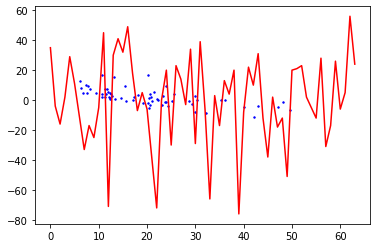

Epoch: 1100 Accurracy real: 0.125 Accurracy fake: 0.984375
Epoch: 1101 Accurracy real: 0.203125 Accurracy fake: 1.0
Epoch: 1102 Accurracy real: 0.15625 Accurracy fake: 0.984375
Epoch: 1103 Accurracy real: 0.140625 Accurracy fake: 1.0
Epoch: 1104 Accurracy real: 0.140625 Accurracy fake: 1.0
Epoch: 1105 Accurracy real: 0.078125 Accurracy fake: 0.984375
Epoch: 1106 Accurracy real: 0.453125 Accurracy fake: 0.984375
Epoch: 1107 Accurracy real: 0.109375 Accurracy fake: 1.0
Epoch: 1108 Accurracy real: 0.125 Accurracy fake: 0.984375
Epoch: 1109 Accurracy real: 0.09375 Accurracy fake: 1.0
Epoch: 1110 Accurracy real: 0.109375 Accurracy fake: 0.984375
Epoch: 1111 Accurracy real: 0.609375 Accurracy fake: 1.0
Epoch: 1112 Accurracy real: 0.078125 Accurracy fake: 1.0
Epoch: 1113 Accurracy real: 0.140625 Accurracy fake: 0.96875
Epoch: 1114 Accurracy real: 0.09375 Accurracy fake: 0.984375
Epoch: 1115 Accurracy real: 0.078125 Accurracy fake: 1.0
Epoch: 1116 Accurracy real: 0.09375 Accurracy fake: 0.9843

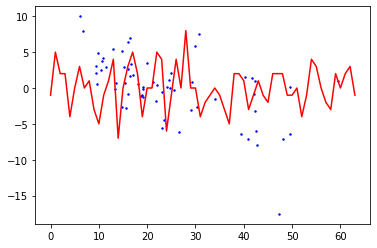

Epoch: 1150 Accurracy real: 0.046875 Accurracy fake: 0.953125
Epoch: 1151 Accurracy real: 0.15625 Accurracy fake: 0.984375
Epoch: 1152 Accurracy real: 0.09375 Accurracy fake: 1.0
Epoch: 1153 Accurracy real: 0.09375 Accurracy fake: 1.0
Epoch: 1154 Accurracy real: 0.34375 Accurracy fake: 0.953125
Epoch: 1155 Accurracy real: 0.125 Accurracy fake: 0.96875
Epoch: 1156 Accurracy real: 0.09375 Accurracy fake: 0.9375
Epoch: 1157 Accurracy real: 0.0625 Accurracy fake: 1.0
Epoch: 1158 Accurracy real: 0.09375 Accurracy fake: 0.984375
Epoch: 1159 Accurracy real: 0.078125 Accurracy fake: 0.984375
Epoch: 1160 Accurracy real: 0.0625 Accurracy fake: 0.984375
Epoch: 1161 Accurracy real: 0.078125 Accurracy fake: 0.96875
Epoch: 1162 Accurracy real: 0.15625 Accurracy fake: 0.9375
Epoch: 1163 Accurracy real: 0.09375 Accurracy fake: 0.96875
Epoch: 1164 Accurracy real: 0.125 Accurracy fake: 0.96875
Epoch: 1165 Accurracy real: 0.078125 Accurracy fake: 0.953125
Epoch: 1166 Accurracy real: 0.109375 Accurracy fa

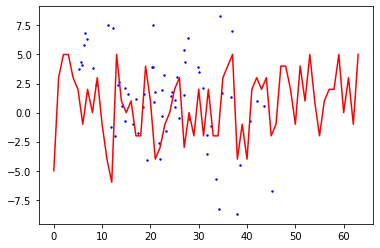

Epoch: 1200 Accurracy real: 0.109375 Accurracy fake: 1.0
Epoch: 1201 Accurracy real: 0.109375 Accurracy fake: 0.984375
Epoch: 1202 Accurracy real: 0.140625 Accurracy fake: 1.0
Epoch: 1203 Accurracy real: 0.125 Accurracy fake: 0.96875
Epoch: 1204 Accurracy real: 0.125 Accurracy fake: 0.984375
Epoch: 1205 Accurracy real: 0.09375 Accurracy fake: 0.984375
Epoch: 1206 Accurracy real: 0.125 Accurracy fake: 0.984375
Epoch: 1207 Accurracy real: 0.125 Accurracy fake: 1.0
Epoch: 1208 Accurracy real: 0.0625 Accurracy fake: 0.984375
Epoch: 1209 Accurracy real: 0.09375 Accurracy fake: 1.0
Epoch: 1210 Accurracy real: 0.09375 Accurracy fake: 0.9375
Epoch: 1211 Accurracy real: 0.125 Accurracy fake: 0.921875
Epoch: 1212 Accurracy real: 0.109375 Accurracy fake: 0.984375
Epoch: 1213 Accurracy real: 0.078125 Accurracy fake: 0.953125
Epoch: 1214 Accurracy real: 0.1875 Accurracy fake: 0.984375
Epoch: 1215 Accurracy real: 0.0625 Accurracy fake: 0.96875
Epoch: 1216 Accurracy real: 0.125 Accurracy fake: 1.0
Ep

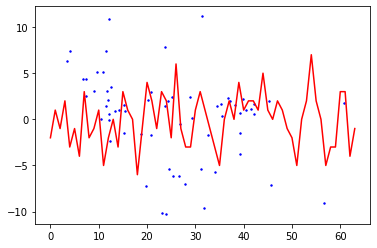

Epoch: 1250 Accurracy real: 0.09375 Accurracy fake: 0.96875
Epoch: 1251 Accurracy real: 0.109375 Accurracy fake: 0.9375
Epoch: 1252 Accurracy real: 0.09375 Accurracy fake: 1.0
Epoch: 1253 Accurracy real: 0.125 Accurracy fake: 0.984375
Epoch: 1254 Accurracy real: 0.09375 Accurracy fake: 0.9375
Epoch: 1255 Accurracy real: 0.125 Accurracy fake: 0.984375
Epoch: 1256 Accurracy real: 0.0625 Accurracy fake: 0.984375
Epoch: 1257 Accurracy real: 0.109375 Accurracy fake: 0.984375
Epoch: 1258 Accurracy real: 0.078125 Accurracy fake: 0.953125
Epoch: 1259 Accurracy real: 0.078125 Accurracy fake: 0.96875
Epoch: 1260 Accurracy real: 0.109375 Accurracy fake: 0.921875
Epoch: 1261 Accurracy real: 0.140625 Accurracy fake: 0.9375
Epoch: 1262 Accurracy real: 0.765625 Accurracy fake: 0.953125
Epoch: 1263 Accurracy real: 0.1875 Accurracy fake: 0.921875
Epoch: 1264 Accurracy real: 0.109375 Accurracy fake: 0.96875
Epoch: 1265 Accurracy real: 0.546875 Accurracy fake: 0.953125
Epoch: 1266 Accurracy real: 0.07812

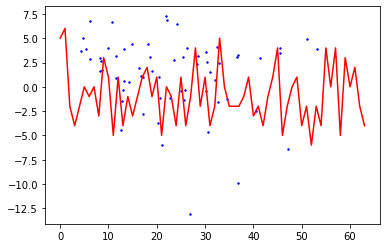

Epoch: 1300 Accurracy real: 0.109375 Accurracy fake: 0.984375
Epoch: 1301 Accurracy real: 0.203125 Accurracy fake: 0.953125
Epoch: 1302 Accurracy real: 0.109375 Accurracy fake: 0.953125
Epoch: 1303 Accurracy real: 0.109375 Accurracy fake: 0.984375
Epoch: 1304 Accurracy real: 0.078125 Accurracy fake: 0.890625
Epoch: 1305 Accurracy real: 0.078125 Accurracy fake: 0.96875
Epoch: 1306 Accurracy real: 0.078125 Accurracy fake: 0.96875
Epoch: 1307 Accurracy real: 0.109375 Accurracy fake: 0.953125
Epoch: 1308 Accurracy real: 0.109375 Accurracy fake: 0.984375
Epoch: 1309 Accurracy real: 0.125 Accurracy fake: 0.984375
Epoch: 1310 Accurracy real: 0.09375 Accurracy fake: 1.0
Epoch: 1311 Accurracy real: 0.109375 Accurracy fake: 0.984375
Epoch: 1312 Accurracy real: 0.0625 Accurracy fake: 0.953125
Epoch: 1313 Accurracy real: 0.140625 Accurracy fake: 0.984375
Epoch: 1314 Accurracy real: 0.0625 Accurracy fake: 1.0
Epoch: 1315 Accurracy real: 0.109375 Accurracy fake: 0.96875
Epoch: 1316 Accurracy real: 0

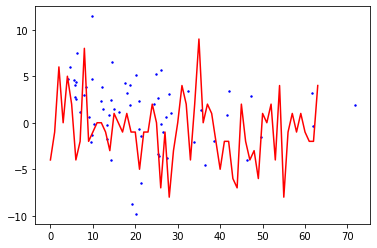

Epoch: 1350 Accurracy real: 0.078125 Accurracy fake: 0.984375
Epoch: 1351 Accurracy real: 0.0625 Accurracy fake: 1.0
Epoch: 1352 Accurracy real: 0.125 Accurracy fake: 0.9375
Epoch: 1353 Accurracy real: 0.078125 Accurracy fake: 0.984375
Epoch: 1354 Accurracy real: 0.078125 Accurracy fake: 0.984375
Epoch: 1355 Accurracy real: 0.125 Accurracy fake: 0.96875
Epoch: 1356 Accurracy real: 0.078125 Accurracy fake: 1.0
Epoch: 1357 Accurracy real: 0.109375 Accurracy fake: 0.984375
Epoch: 1358 Accurracy real: 0.09375 Accurracy fake: 0.953125
Epoch: 1359 Accurracy real: 0.671875 Accurracy fake: 1.0
Epoch: 1360 Accurracy real: 0.078125 Accurracy fake: 0.984375
Epoch: 1361 Accurracy real: 0.078125 Accurracy fake: 0.953125
Epoch: 1362 Accurracy real: 0.09375 Accurracy fake: 1.0
Epoch: 1363 Accurracy real: 0.078125 Accurracy fake: 0.9375
Epoch: 1364 Accurracy real: 0.09375 Accurracy fake: 1.0
Epoch: 1365 Accurracy real: 0.046875 Accurracy fake: 1.0
Epoch: 1366 Accurracy real: 0.09375 Accurracy fake: 1.

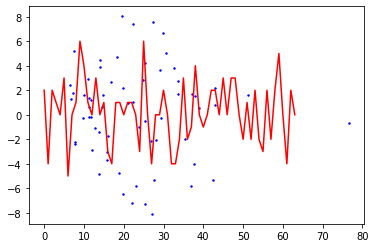

Epoch: 1400 Accurracy real: 0.375 Accurracy fake: 0.984375
Epoch: 1401 Accurracy real: 0.09375 Accurracy fake: 1.0
Epoch: 1402 Accurracy real: 0.046875 Accurracy fake: 0.96875
Epoch: 1403 Accurracy real: 0.09375 Accurracy fake: 0.953125
Epoch: 1404 Accurracy real: 0.109375 Accurracy fake: 0.984375
Epoch: 1405 Accurracy real: 0.109375 Accurracy fake: 1.0
Epoch: 1406 Accurracy real: 0.046875 Accurracy fake: 0.953125
Epoch: 1407 Accurracy real: 0.078125 Accurracy fake: 1.0
Epoch: 1408 Accurracy real: 0.078125 Accurracy fake: 1.0
Epoch: 1409 Accurracy real: 0.0625 Accurracy fake: 0.953125
Epoch: 1410 Accurracy real: 0.0625 Accurracy fake: 0.96875
Epoch: 1411 Accurracy real: 0.078125 Accurracy fake: 0.984375
Epoch: 1412 Accurracy real: 0.0625 Accurracy fake: 0.984375
Epoch: 1413 Accurracy real: 0.109375 Accurracy fake: 0.953125
Epoch: 1414 Accurracy real: 0.078125 Accurracy fake: 1.0
Epoch: 1415 Accurracy real: 0.09375 Accurracy fake: 0.96875
Epoch: 1416 Accurracy real: 0.09375 Accurracy fa

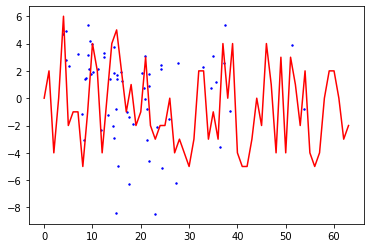

Epoch: 1450 Accurracy real: 0.09375 Accurracy fake: 0.96875
Epoch: 1451 Accurracy real: 0.09375 Accurracy fake: 0.96875
Epoch: 1452 Accurracy real: 0.046875 Accurracy fake: 0.984375
Epoch: 1453 Accurracy real: 0.109375 Accurracy fake: 0.96875
Epoch: 1454 Accurracy real: 0.09375 Accurracy fake: 0.96875
Epoch: 1455 Accurracy real: 0.0625 Accurracy fake: 0.984375
Epoch: 1456 Accurracy real: 0.125 Accurracy fake: 0.96875
Epoch: 1457 Accurracy real: 0.078125 Accurracy fake: 0.9375
Epoch: 1458 Accurracy real: 0.0625 Accurracy fake: 0.96875
Epoch: 1459 Accurracy real: 0.109375 Accurracy fake: 0.984375
Epoch: 1460 Accurracy real: 0.09375 Accurracy fake: 1.0
Epoch: 1461 Accurracy real: 0.46875 Accurracy fake: 0.96875
Epoch: 1462 Accurracy real: 0.078125 Accurracy fake: 0.984375
Epoch: 1463 Accurracy real: 0.078125 Accurracy fake: 0.953125
Epoch: 1464 Accurracy real: 0.0625 Accurracy fake: 0.953125
Epoch: 1465 Accurracy real: 0.0625 Accurracy fake: 1.0
Epoch: 1466 Accurracy real: 0.09375 Accurra

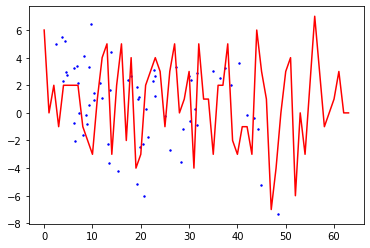

Epoch: 1500 Accurracy real: 0.09375 Accurracy fake: 0.984375
Epoch: 1501 Accurracy real: 0.078125 Accurracy fake: 0.953125
Epoch: 1502 Accurracy real: 0.203125 Accurracy fake: 0.96875
Epoch: 1503 Accurracy real: 0.09375 Accurracy fake: 0.96875
Epoch: 1504 Accurracy real: 0.109375 Accurracy fake: 0.96875
Epoch: 1505 Accurracy real: 0.0625 Accurracy fake: 0.984375
Epoch: 1506 Accurracy real: 0.0625 Accurracy fake: 0.9375
Epoch: 1507 Accurracy real: 0.078125 Accurracy fake: 0.984375
Epoch: 1508 Accurracy real: 0.09375 Accurracy fake: 0.9375
Epoch: 1509 Accurracy real: 0.09375 Accurracy fake: 0.953125
Epoch: 1510 Accurracy real: 0.078125 Accurracy fake: 0.984375
Epoch: 1511 Accurracy real: 0.078125 Accurracy fake: 0.96875
Epoch: 1512 Accurracy real: 0.109375 Accurracy fake: 0.953125
Epoch: 1513 Accurracy real: 0.0625 Accurracy fake: 0.984375
Epoch: 1514 Accurracy real: 0.0625 Accurracy fake: 0.90625
Epoch: 1515 Accurracy real: 0.078125 Accurracy fake: 0.96875
Epoch: 1516 Accurracy real: 0.

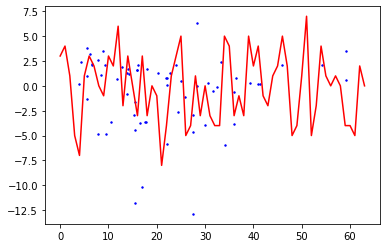

Epoch: 1550 Accurracy real: 0.109375 Accurracy fake: 0.9375
Epoch: 1551 Accurracy real: 0.09375 Accurracy fake: 0.953125
Epoch: 1552 Accurracy real: 0.09375 Accurracy fake: 0.953125
Epoch: 1553 Accurracy real: 0.078125 Accurracy fake: 0.984375
Epoch: 1554 Accurracy real: 0.078125 Accurracy fake: 1.0
Epoch: 1555 Accurracy real: 0.125 Accurracy fake: 0.953125
Epoch: 1556 Accurracy real: 0.09375 Accurracy fake: 0.921875
Epoch: 1557 Accurracy real: 0.078125 Accurracy fake: 0.953125
Epoch: 1558 Accurracy real: 0.078125 Accurracy fake: 0.96875
Epoch: 1559 Accurracy real: 0.078125 Accurracy fake: 0.984375
Epoch: 1560 Accurracy real: 0.125 Accurracy fake: 0.96875
Epoch: 1561 Accurracy real: 0.09375 Accurracy fake: 0.984375
Epoch: 1562 Accurracy real: 0.09375 Accurracy fake: 0.984375
Epoch: 1563 Accurracy real: 0.109375 Accurracy fake: 0.96875
Epoch: 1564 Accurracy real: 0.078125 Accurracy fake: 0.953125
Epoch: 1565 Accurracy real: 0.078125 Accurracy fake: 1.0
Epoch: 1566 Accurracy real: 0.0937

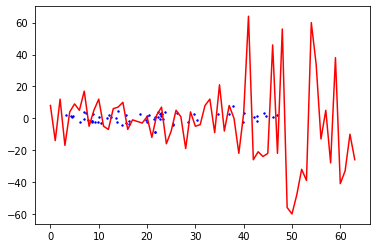

Epoch: 1600 Accurracy real: 0.078125 Accurracy fake: 0.921875
Epoch: 1601 Accurracy real: 0.109375 Accurracy fake: 0.9375
Epoch: 1602 Accurracy real: 0.09375 Accurracy fake: 0.984375
Epoch: 1603 Accurracy real: 0.078125 Accurracy fake: 0.984375
Epoch: 1604 Accurracy real: 0.078125 Accurracy fake: 0.96875
Epoch: 1605 Accurracy real: 0.078125 Accurracy fake: 0.9375
Epoch: 1606 Accurracy real: 0.0625 Accurracy fake: 0.953125
Epoch: 1607 Accurracy real: 0.125 Accurracy fake: 0.953125
Epoch: 1608 Accurracy real: 0.09375 Accurracy fake: 1.0
Epoch: 1609 Accurracy real: 0.359375 Accurracy fake: 0.96875
Epoch: 1610 Accurracy real: 0.078125 Accurracy fake: 0.96875
Epoch: 1611 Accurracy real: 0.078125 Accurracy fake: 0.9375
Epoch: 1612 Accurracy real: 0.0625 Accurracy fake: 0.953125
Epoch: 1613 Accurracy real: 0.078125 Accurracy fake: 0.953125
Epoch: 1614 Accurracy real: 0.078125 Accurracy fake: 0.9375
Epoch: 1615 Accurracy real: 0.0625 Accurracy fake: 0.953125
Epoch: 1616 Accurracy real: 0.09375

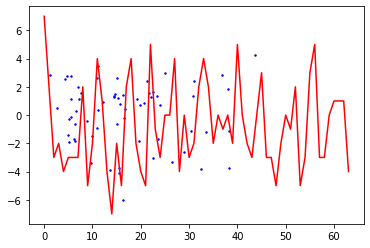

Epoch: 1650 Accurracy real: 0.109375 Accurracy fake: 0.90625
Epoch: 1651 Accurracy real: 0.078125 Accurracy fake: 0.90625
Epoch: 1652 Accurracy real: 0.078125 Accurracy fake: 0.9375
Epoch: 1653 Accurracy real: 0.4375 Accurracy fake: 0.90625
Epoch: 1654 Accurracy real: 0.109375 Accurracy fake: 0.921875
Epoch: 1655 Accurracy real: 0.0625 Accurracy fake: 0.921875
Epoch: 1656 Accurracy real: 0.09375 Accurracy fake: 0.9375
Epoch: 1657 Accurracy real: 0.109375 Accurracy fake: 1.0
Epoch: 1658 Accurracy real: 0.03125 Accurracy fake: 0.90625
Epoch: 1659 Accurracy real: 0.109375 Accurracy fake: 0.90625
Epoch: 1660 Accurracy real: 0.109375 Accurracy fake: 0.9375
Epoch: 1661 Accurracy real: 0.34375 Accurracy fake: 0.90625
Epoch: 1662 Accurracy real: 0.0625 Accurracy fake: 0.9375
Epoch: 1663 Accurracy real: 0.09375 Accurracy fake: 0.921875
Epoch: 1664 Accurracy real: 0.5 Accurracy fake: 0.96875
Epoch: 1665 Accurracy real: 0.09375 Accurracy fake: 0.953125
Epoch: 1666 Accurracy real: 0.109375 Accurra

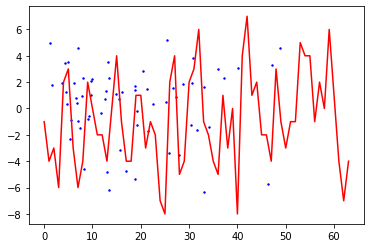

Epoch: 1700 Accurracy real: 0.234375 Accurracy fake: 0.921875
Epoch: 1701 Accurracy real: 0.109375 Accurracy fake: 0.984375
Epoch: 1702 Accurracy real: 0.0625 Accurracy fake: 0.921875
Epoch: 1703 Accurracy real: 0.09375 Accurracy fake: 0.921875
Epoch: 1704 Accurracy real: 0.125 Accurracy fake: 0.953125
Epoch: 1705 Accurracy real: 0.078125 Accurracy fake: 0.9375
Epoch: 1706 Accurracy real: 0.109375 Accurracy fake: 0.921875
Epoch: 1707 Accurracy real: 0.078125 Accurracy fake: 0.9375
Epoch: 1708 Accurracy real: 0.09375 Accurracy fake: 0.9375
Epoch: 1709 Accurracy real: 0.078125 Accurracy fake: 0.9375
Epoch: 1710 Accurracy real: 0.09375 Accurracy fake: 0.90625
Epoch: 1711 Accurracy real: 0.078125 Accurracy fake: 0.90625
Epoch: 1712 Accurracy real: 0.046875 Accurracy fake: 0.921875
Epoch: 1713 Accurracy real: 0.078125 Accurracy fake: 0.953125
Epoch: 1714 Accurracy real: 0.28125 Accurracy fake: 0.953125
Epoch: 1715 Accurracy real: 0.09375 Accurracy fake: 0.953125
Epoch: 1716 Accurracy real: 

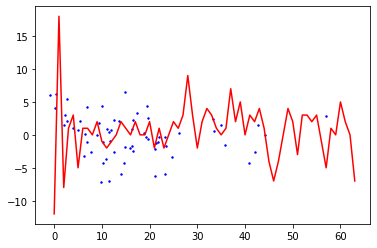

Epoch: 1750 Accurracy real: 0.078125 Accurracy fake: 0.953125
Epoch: 1751 Accurracy real: 0.125 Accurracy fake: 0.953125
Epoch: 1752 Accurracy real: 0.125 Accurracy fake: 0.90625
Epoch: 1753 Accurracy real: 0.0625 Accurracy fake: 0.9375
Epoch: 1754 Accurracy real: 0.078125 Accurracy fake: 0.90625
Epoch: 1755 Accurracy real: 0.078125 Accurracy fake: 0.96875
Epoch: 1756 Accurracy real: 0.09375 Accurracy fake: 0.8125
Epoch: 1757 Accurracy real: 0.09375 Accurracy fake: 0.9375
Epoch: 1758 Accurracy real: 0.078125 Accurracy fake: 0.96875
Epoch: 1759 Accurracy real: 0.0625 Accurracy fake: 0.9375
Epoch: 1760 Accurracy real: 0.09375 Accurracy fake: 0.921875
Epoch: 1761 Accurracy real: 0.078125 Accurracy fake: 0.921875
Epoch: 1762 Accurracy real: 0.078125 Accurracy fake: 0.875
Epoch: 1763 Accurracy real: 0.09375 Accurracy fake: 0.953125
Epoch: 1764 Accurracy real: 0.171875 Accurracy fake: 0.875
Epoch: 1765 Accurracy real: 0.15625 Accurracy fake: 0.75
Epoch: 1766 Accurracy real: 0.15625 Accurracy

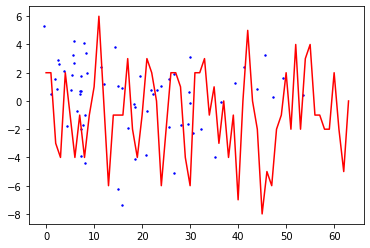

Epoch: 1800 Accurracy real: 0.203125 Accurracy fake: 0.8125
Epoch: 1801 Accurracy real: 0.140625 Accurracy fake: 0.671875
Epoch: 1802 Accurracy real: 0.171875 Accurracy fake: 0.796875
Epoch: 1803 Accurracy real: 0.3125 Accurracy fake: 0.84375
Epoch: 1804 Accurracy real: 0.109375 Accurracy fake: 0.8125
Epoch: 1805 Accurracy real: 0.078125 Accurracy fake: 0.796875
Epoch: 1806 Accurracy real: 0.109375 Accurracy fake: 0.765625
Epoch: 1807 Accurracy real: 0.109375 Accurracy fake: 0.734375
Epoch: 1808 Accurracy real: 0.109375 Accurracy fake: 0.796875
Epoch: 1809 Accurracy real: 0.15625 Accurracy fake: 0.765625
Epoch: 1810 Accurracy real: 0.109375 Accurracy fake: 0.84375
Epoch: 1811 Accurracy real: 0.125 Accurracy fake: 0.84375
Epoch: 1812 Accurracy real: 0.140625 Accurracy fake: 0.78125
Epoch: 1813 Accurracy real: 0.203125 Accurracy fake: 0.859375
Epoch: 1814 Accurracy real: 0.15625 Accurracy fake: 0.84375
Epoch: 1815 Accurracy real: 0.15625 Accurracy fake: 0.84375
Epoch: 1816 Accurracy real

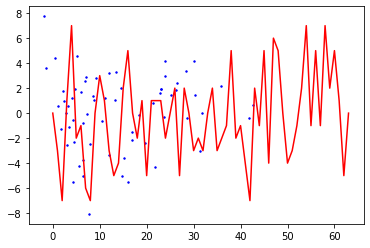

Epoch: 1850 Accurracy real: 0.078125 Accurracy fake: 0.84375
Epoch: 1851 Accurracy real: 0.0625 Accurracy fake: 0.859375
Epoch: 1852 Accurracy real: 0.09375 Accurracy fake: 0.875
Epoch: 1853 Accurracy real: 0.09375 Accurracy fake: 0.921875
Epoch: 1854 Accurracy real: 0.078125 Accurracy fake: 0.828125
Epoch: 1855 Accurracy real: 0.109375 Accurracy fake: 0.84375
Epoch: 1856 Accurracy real: 0.078125 Accurracy fake: 0.8125
Epoch: 1857 Accurracy real: 0.109375 Accurracy fake: 0.859375
Epoch: 1858 Accurracy real: 0.0625 Accurracy fake: 0.8125
Epoch: 1859 Accurracy real: 0.09375 Accurracy fake: 0.859375
Epoch: 1860 Accurracy real: 0.046875 Accurracy fake: 0.890625
Epoch: 1861 Accurracy real: 0.09375 Accurracy fake: 0.859375
Epoch: 1862 Accurracy real: 0.0625 Accurracy fake: 0.9375
Epoch: 1863 Accurracy real: 0.09375 Accurracy fake: 0.796875
Epoch: 1864 Accurracy real: 0.078125 Accurracy fake: 0.875
Epoch: 1865 Accurracy real: 0.09375 Accurracy fake: 0.859375
Epoch: 1866 Accurracy real: 0.0937

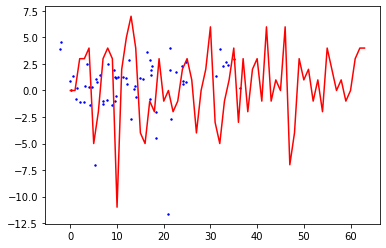

Epoch: 1900 Accurracy real: 0.65625 Accurracy fake: 0.546875
Epoch: 1901 Accurracy real: 0.671875 Accurracy fake: 0.609375
Epoch: 1902 Accurracy real: 0.75 Accurracy fake: 0.578125
Epoch: 1903 Accurracy real: 0.796875 Accurracy fake: 0.484375
Epoch: 1904 Accurracy real: 0.78125 Accurracy fake: 0.375
Epoch: 1905 Accurracy real: 0.84375 Accurracy fake: 0.515625
Epoch: 1906 Accurracy real: 0.734375 Accurracy fake: 0.328125
Epoch: 1907 Accurracy real: 0.84375 Accurracy fake: 0.34375
Epoch: 1908 Accurracy real: 0.859375 Accurracy fake: 0.265625
Epoch: 1909 Accurracy real: 0.78125 Accurracy fake: 0.40625
Epoch: 1910 Accurracy real: 0.640625 Accurracy fake: 0.625
Epoch: 1911 Accurracy real: 0.328125 Accurracy fake: 0.546875
Epoch: 1912 Accurracy real: 0.453125 Accurracy fake: 0.625
Epoch: 1913 Accurracy real: 0.4375 Accurracy fake: 0.71875
Epoch: 1914 Accurracy real: 0.484375 Accurracy fake: 0.65625
Epoch: 1915 Accurracy real: 0.578125 Accurracy fake: 0.59375
Epoch: 1916 Accurracy real: 0.671

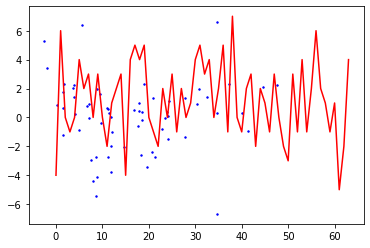

Epoch: 1950 Accurracy real: 0.453125 Accurracy fake: 0.71875
Epoch: 1951 Accurracy real: 0.421875 Accurracy fake: 0.828125
Epoch: 1952 Accurracy real: 0.1875 Accurracy fake: 0.796875
Epoch: 1953 Accurracy real: 0.15625 Accurracy fake: 0.921875
Epoch: 1954 Accurracy real: 0.296875 Accurracy fake: 0.75
Epoch: 1955 Accurracy real: 0.328125 Accurracy fake: 0.71875
Epoch: 1956 Accurracy real: 0.375 Accurracy fake: 0.6875
Epoch: 1957 Accurracy real: 0.484375 Accurracy fake: 0.703125
Epoch: 1958 Accurracy real: 0.546875 Accurracy fake: 0.546875
Epoch: 1959 Accurracy real: 0.5625 Accurracy fake: 0.546875
Epoch: 1960 Accurracy real: 0.421875 Accurracy fake: 0.640625
Epoch: 1961 Accurracy real: 0.65625 Accurracy fake: 0.6875
Epoch: 1962 Accurracy real: 0.546875 Accurracy fake: 0.640625
Epoch: 1963 Accurracy real: 0.484375 Accurracy fake: 0.59375
Epoch: 1964 Accurracy real: 0.625 Accurracy fake: 0.484375
Epoch: 1965 Accurracy real: 0.625 Accurracy fake: 0.640625
Epoch: 1966 Accurracy real: 0.5781

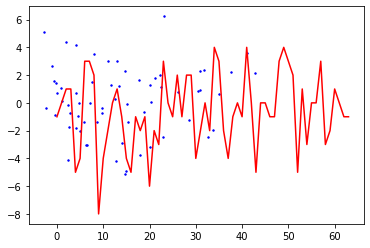

Epoch: 2000 Accurracy real: 0.5 Accurracy fake: 0.53125
Epoch: 2001 Accurracy real: 0.390625 Accurracy fake: 0.609375
Epoch: 2002 Accurracy real: 0.375 Accurracy fake: 0.421875
Epoch: 2003 Accurracy real: 0.359375 Accurracy fake: 0.578125
Epoch: 2004 Accurracy real: 0.34375 Accurracy fake: 0.53125
Epoch: 2005 Accurracy real: 0.328125 Accurracy fake: 0.625
Epoch: 2006 Accurracy real: 0.375 Accurracy fake: 0.5625
Epoch: 2007 Accurracy real: 0.296875 Accurracy fake: 0.765625
Epoch: 2008 Accurracy real: 0.5 Accurracy fake: 0.65625
Epoch: 2009 Accurracy real: 0.34375 Accurracy fake: 0.53125
Epoch: 2010 Accurracy real: 0.484375 Accurracy fake: 0.609375
Epoch: 2011 Accurracy real: 0.296875 Accurracy fake: 0.5
Epoch: 2012 Accurracy real: 0.625 Accurracy fake: 0.515625
Epoch: 2013 Accurracy real: 0.765625 Accurracy fake: 0.375
Epoch: 2014 Accurracy real: 0.765625 Accurracy fake: 0.34375
Epoch: 2015 Accurracy real: 0.890625 Accurracy fake: 0.234375
Epoch: 2016 Accurracy real: 0.71875 Accurracy f

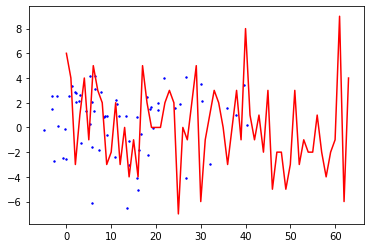

Epoch: 2050 Accurracy real: 0.6875 Accurracy fake: 0.5
Epoch: 2051 Accurracy real: 0.640625 Accurracy fake: 0.53125
Epoch: 2052 Accurracy real: 0.765625 Accurracy fake: 0.484375
Epoch: 2053 Accurracy real: 0.71875 Accurracy fake: 0.4375
Epoch: 2054 Accurracy real: 0.65625 Accurracy fake: 0.359375
Epoch: 2055 Accurracy real: 0.828125 Accurracy fake: 0.484375
Epoch: 2056 Accurracy real: 0.671875 Accurracy fake: 0.453125
Epoch: 2057 Accurracy real: 0.765625 Accurracy fake: 0.40625
Epoch: 2058 Accurracy real: 0.71875 Accurracy fake: 0.359375
Epoch: 2059 Accurracy real: 0.828125 Accurracy fake: 0.328125
Epoch: 2060 Accurracy real: 0.734375 Accurracy fake: 0.25
Epoch: 2061 Accurracy real: 0.84375 Accurracy fake: 0.234375
Epoch: 2062 Accurracy real: 0.875 Accurracy fake: 0.234375
Epoch: 2063 Accurracy real: 0.921875 Accurracy fake: 0.296875
Epoch: 2064 Accurracy real: 0.828125 Accurracy fake: 0.203125
Epoch: 2065 Accurracy real: 0.828125 Accurracy fake: 0.25
Epoch: 2066 Accurracy real: 0.8906

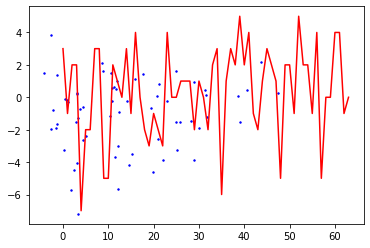

Epoch: 2100 Accurracy real: 0.84375 Accurracy fake: 0.28125
Epoch: 2101 Accurracy real: 0.875 Accurracy fake: 0.171875
Epoch: 2102 Accurracy real: 0.96875 Accurracy fake: 0.203125
Epoch: 2103 Accurracy real: 0.921875 Accurracy fake: 0.171875
Epoch: 2104 Accurracy real: 0.9375 Accurracy fake: 0.15625
Epoch: 2105 Accurracy real: 0.9375 Accurracy fake: 0.125
Epoch: 2106 Accurracy real: 0.90625 Accurracy fake: 0.125
Epoch: 2107 Accurracy real: 0.921875 Accurracy fake: 0.1875
Epoch: 2108 Accurracy real: 0.90625 Accurracy fake: 0.25
Epoch: 2109 Accurracy real: 0.890625 Accurracy fake: 0.203125
Epoch: 2110 Accurracy real: 0.84375 Accurracy fake: 0.34375
Epoch: 2111 Accurracy real: 0.765625 Accurracy fake: 0.484375
Epoch: 2112 Accurracy real: 0.75 Accurracy fake: 0.453125
Epoch: 2113 Accurracy real: 0.546875 Accurracy fake: 0.65625
Epoch: 2114 Accurracy real: 0.421875 Accurracy fake: 0.71875
Epoch: 2115 Accurracy real: 0.328125 Accurracy fake: 0.671875
Epoch: 2116 Accurracy real: 0.625 Accurra

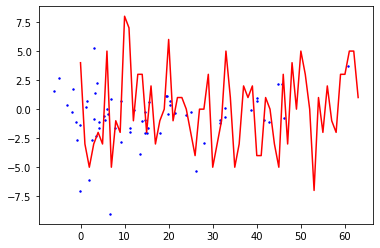

Epoch: 2150 Accurracy real: 0.640625 Accurracy fake: 0.421875
Epoch: 2151 Accurracy real: 0.59375 Accurracy fake: 0.3125
Epoch: 2152 Accurracy real: 0.640625 Accurracy fake: 0.3125
Epoch: 2153 Accurracy real: 0.734375 Accurracy fake: 0.390625
Epoch: 2154 Accurracy real: 0.75 Accurracy fake: 0.296875
Epoch: 2155 Accurracy real: 0.6875 Accurracy fake: 0.421875
Epoch: 2156 Accurracy real: 0.71875 Accurracy fake: 0.28125
Epoch: 2157 Accurracy real: 0.5625 Accurracy fake: 0.171875
Epoch: 2158 Accurracy real: 0.609375 Accurracy fake: 0.25
Epoch: 2159 Accurracy real: 0.625 Accurracy fake: 0.359375
Epoch: 2160 Accurracy real: 0.625 Accurracy fake: 0.3125
Epoch: 2161 Accurracy real: 0.609375 Accurracy fake: 0.40625
Epoch: 2162 Accurracy real: 0.5625 Accurracy fake: 0.40625
Epoch: 2163 Accurracy real: 0.71875 Accurracy fake: 0.34375
Epoch: 2164 Accurracy real: 0.734375 Accurracy fake: 0.265625
Epoch: 2165 Accurracy real: 0.75 Accurracy fake: 0.3125
Epoch: 2166 Accurracy real: 0.859375 Accurracy 

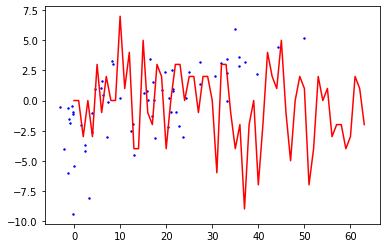

Epoch: 2200 Accurracy real: 0.890625 Accurracy fake: 0.21875
Epoch: 2201 Accurracy real: 0.828125 Accurracy fake: 0.3125
Epoch: 2202 Accurracy real: 0.78125 Accurracy fake: 0.390625
Epoch: 2203 Accurracy real: 0.828125 Accurracy fake: 0.359375
Epoch: 2204 Accurracy real: 0.734375 Accurracy fake: 0.515625
Epoch: 2205 Accurracy real: 0.625 Accurracy fake: 0.640625
Epoch: 2206 Accurracy real: 0.75 Accurracy fake: 0.625
Epoch: 2207 Accurracy real: 0.703125 Accurracy fake: 0.59375
Epoch: 2208 Accurracy real: 0.734375 Accurracy fake: 0.5
Epoch: 2209 Accurracy real: 0.78125 Accurracy fake: 0.4375
Epoch: 2210 Accurracy real: 0.796875 Accurracy fake: 0.296875
Epoch: 2211 Accurracy real: 0.859375 Accurracy fake: 0.21875
Epoch: 2212 Accurracy real: 0.90625 Accurracy fake: 0.21875
Epoch: 2213 Accurracy real: 0.953125 Accurracy fake: 0.21875
Epoch: 2214 Accurracy real: 0.9375 Accurracy fake: 0.203125
Epoch: 2215 Accurracy real: 0.921875 Accurracy fake: 0.171875
Epoch: 2216 Accurracy real: 0.953125 

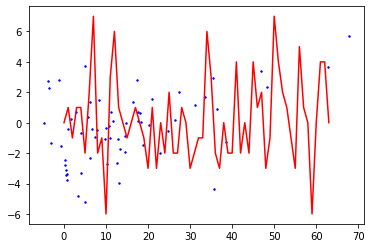

Epoch: 2250 Accurracy real: 0.875 Accurracy fake: 0.21875
Epoch: 2251 Accurracy real: 0.90625 Accurracy fake: 0.21875
Epoch: 2252 Accurracy real: 0.890625 Accurracy fake: 0.1875
Epoch: 2253 Accurracy real: 0.9375 Accurracy fake: 0.09375
Epoch: 2254 Accurracy real: 0.921875 Accurracy fake: 0.171875
Epoch: 2255 Accurracy real: 0.9375 Accurracy fake: 0.21875
Epoch: 2256 Accurracy real: 0.953125 Accurracy fake: 0.15625
Epoch: 2257 Accurracy real: 0.96875 Accurracy fake: 0.15625
Epoch: 2258 Accurracy real: 0.921875 Accurracy fake: 0.078125
Epoch: 2259 Accurracy real: 0.875 Accurracy fake: 0.3125
Epoch: 2260 Accurracy real: 0.875 Accurracy fake: 0.21875
Epoch: 2261 Accurracy real: 0.828125 Accurracy fake: 0.296875
Epoch: 2262 Accurracy real: 0.765625 Accurracy fake: 0.28125
Epoch: 2263 Accurracy real: 0.6875 Accurracy fake: 0.390625
Epoch: 2264 Accurracy real: 0.578125 Accurracy fake: 0.578125
Epoch: 2265 Accurracy real: 0.609375 Accurracy fake: 0.515625
Epoch: 2266 Accurracy real: 0.421875 

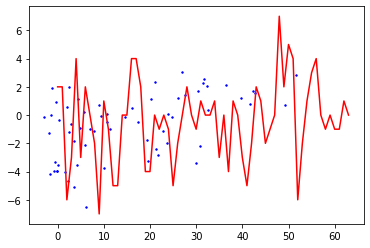

Epoch: 2300 Accurracy real: 0.34375 Accurracy fake: 0.6875
Epoch: 2301 Accurracy real: 0.40625 Accurracy fake: 0.6875
Epoch: 2302 Accurracy real: 0.390625 Accurracy fake: 0.578125
Epoch: 2303 Accurracy real: 0.375 Accurracy fake: 0.65625
Epoch: 2304 Accurracy real: 0.390625 Accurracy fake: 0.609375
Epoch: 2305 Accurracy real: 0.515625 Accurracy fake: 0.53125
Epoch: 2306 Accurracy real: 0.625 Accurracy fake: 0.4375
Epoch: 2307 Accurracy real: 0.703125 Accurracy fake: 0.53125
Epoch: 2308 Accurracy real: 0.625 Accurracy fake: 0.484375
Epoch: 2309 Accurracy real: 0.71875 Accurracy fake: 0.609375
Epoch: 2310 Accurracy real: 0.625 Accurracy fake: 0.40625
Epoch: 2311 Accurracy real: 0.5 Accurracy fake: 0.5
Epoch: 2312 Accurracy real: 0.5625 Accurracy fake: 0.4375
Epoch: 2313 Accurracy real: 0.578125 Accurracy fake: 0.40625
Epoch: 2314 Accurracy real: 0.65625 Accurracy fake: 0.484375
Epoch: 2315 Accurracy real: 0.65625 Accurracy fake: 0.453125
Epoch: 2316 Accurracy real: 0.5625 Accurracy fake:

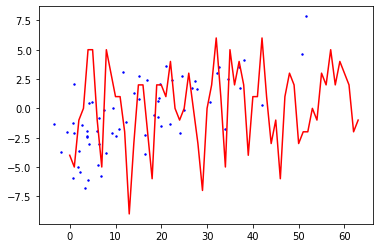

Epoch: 2350 Accurracy real: 0.125 Accurracy fake: 0.671875
Epoch: 2351 Accurracy real: 0.109375 Accurracy fake: 0.796875
Epoch: 2352 Accurracy real: 0.140625 Accurracy fake: 0.78125
Epoch: 2353 Accurracy real: 0.09375 Accurracy fake: 0.640625
Epoch: 2354 Accurracy real: 0.265625 Accurracy fake: 0.703125
Epoch: 2355 Accurracy real: 0.078125 Accurracy fake: 0.625
Epoch: 2356 Accurracy real: 0.109375 Accurracy fake: 0.71875
Epoch: 2357 Accurracy real: 0.078125 Accurracy fake: 0.75
Epoch: 2358 Accurracy real: 0.203125 Accurracy fake: 0.734375
Epoch: 2359 Accurracy real: 0.109375 Accurracy fake: 0.75
Epoch: 2360 Accurracy real: 0.09375 Accurracy fake: 0.78125
Epoch: 2361 Accurracy real: 0.296875 Accurracy fake: 0.734375
Epoch: 2362 Accurracy real: 0.15625 Accurracy fake: 0.671875
Epoch: 2363 Accurracy real: 0.09375 Accurracy fake: 0.703125
Epoch: 2364 Accurracy real: 0.125 Accurracy fake: 0.578125
Epoch: 2365 Accurracy real: 0.171875 Accurracy fake: 0.671875
Epoch: 2366 Accurracy real: 0.40

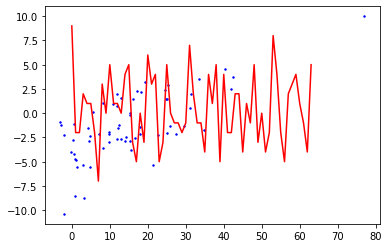

Epoch: 2400 Accurracy real: 0.765625 Accurracy fake: 0.359375
Epoch: 2401 Accurracy real: 0.796875 Accurracy fake: 0.375
Epoch: 2402 Accurracy real: 0.765625 Accurracy fake: 0.59375
Epoch: 2403 Accurracy real: 0.59375 Accurracy fake: 0.609375
Epoch: 2404 Accurracy real: 0.375 Accurracy fake: 0.828125
Epoch: 2405 Accurracy real: 0.09375 Accurracy fake: 0.78125
Epoch: 2406 Accurracy real: 0.0625 Accurracy fake: 0.734375
Epoch: 2407 Accurracy real: 0.125 Accurracy fake: 0.875
Epoch: 2408 Accurracy real: 0.078125 Accurracy fake: 0.84375
Epoch: 2409 Accurracy real: 0.140625 Accurracy fake: 0.859375
Epoch: 2410 Accurracy real: 0.765625 Accurracy fake: 0.75
Epoch: 2411 Accurracy real: 0.703125 Accurracy fake: 0.546875
Epoch: 2412 Accurracy real: 0.828125 Accurracy fake: 0.46875
Epoch: 2413 Accurracy real: 0.828125 Accurracy fake: 0.390625
Epoch: 2414 Accurracy real: 0.796875 Accurracy fake: 0.484375
Epoch: 2415 Accurracy real: 0.875 Accurracy fake: 0.390625
Epoch: 2416 Accurracy real: 0.90625

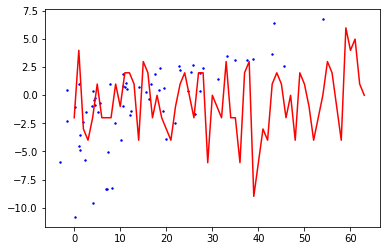

Epoch: 2450 Accurracy real: 0.859375 Accurracy fake: 0.4375
Epoch: 2451 Accurracy real: 0.875 Accurracy fake: 0.296875
Epoch: 2452 Accurracy real: 0.828125 Accurracy fake: 0.359375
Epoch: 2453 Accurracy real: 0.828125 Accurracy fake: 0.40625
Epoch: 2454 Accurracy real: 0.75 Accurracy fake: 0.4375
Epoch: 2455 Accurracy real: 0.734375 Accurracy fake: 0.5
Epoch: 2456 Accurracy real: 0.640625 Accurracy fake: 0.609375
Epoch: 2457 Accurracy real: 0.65625 Accurracy fake: 0.796875
Epoch: 2458 Accurracy real: 0.59375 Accurracy fake: 0.765625
Epoch: 2459 Accurracy real: 0.3125 Accurracy fake: 0.890625
Epoch: 2460 Accurracy real: 0.078125 Accurracy fake: 0.84375
Epoch: 2461 Accurracy real: 0.0625 Accurracy fake: 0.859375
Epoch: 2462 Accurracy real: 0.09375 Accurracy fake: 0.859375
Epoch: 2463 Accurracy real: 0.09375 Accurracy fake: 0.828125
Epoch: 2464 Accurracy real: 0.203125 Accurracy fake: 0.625
Epoch: 2465 Accurracy real: 0.3125 Accurracy fake: 0.75
Epoch: 2466 Accurracy real: 0.53125 Accurra

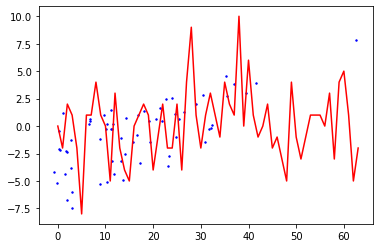

Epoch: 2500 Accurracy real: 0.25 Accurracy fake: 0.796875
Epoch: 2501 Accurracy real: 0.21875 Accurracy fake: 0.765625
Epoch: 2502 Accurracy real: 0.140625 Accurracy fake: 0.828125
Epoch: 2503 Accurracy real: 0.125 Accurracy fake: 0.734375
Epoch: 2504 Accurracy real: 0.59375 Accurracy fake: 0.75
Epoch: 2505 Accurracy real: 0.5 Accurracy fake: 0.796875
Epoch: 2506 Accurracy real: 0.671875 Accurracy fake: 0.71875
Epoch: 2507 Accurracy real: 0.734375 Accurracy fake: 0.609375
Epoch: 2508 Accurracy real: 0.78125 Accurracy fake: 0.625
Epoch: 2509 Accurracy real: 0.828125 Accurracy fake: 0.4375
Epoch: 2510 Accurracy real: 0.828125 Accurracy fake: 0.40625
Epoch: 2511 Accurracy real: 0.796875 Accurracy fake: 0.546875
Epoch: 2512 Accurracy real: 0.921875 Accurracy fake: 0.46875
Epoch: 2513 Accurracy real: 0.9375 Accurracy fake: 0.421875
Epoch: 2514 Accurracy real: 0.59375 Accurracy fake: 0.46875
Epoch: 2515 Accurracy real: 0.8125 Accurracy fake: 0.40625
Epoch: 2516 Accurracy real: 0.6875 Accurra

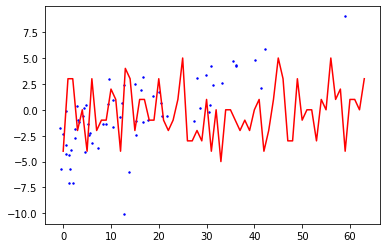

Epoch: 2550 Accurracy real: 0.515625 Accurracy fake: 0.875
Epoch: 2551 Accurracy real: 0.578125 Accurracy fake: 0.875
Epoch: 2552 Accurracy real: 0.5 Accurracy fake: 0.921875
Epoch: 2553 Accurracy real: 0.4375 Accurracy fake: 0.890625
Epoch: 2554 Accurracy real: 0.28125 Accurracy fake: 0.9375
Epoch: 2555 Accurracy real: 0.265625 Accurracy fake: 0.953125
Epoch: 2556 Accurracy real: 0.171875 Accurracy fake: 0.890625
Epoch: 2557 Accurracy real: 0.328125 Accurracy fake: 0.875
Epoch: 2558 Accurracy real: 0.21875 Accurracy fake: 0.90625
Epoch: 2559 Accurracy real: 0.21875 Accurracy fake: 0.921875
Epoch: 2560 Accurracy real: 0.375 Accurracy fake: 0.875
Epoch: 2561 Accurracy real: 0.3125 Accurracy fake: 0.828125
Epoch: 2562 Accurracy real: 0.234375 Accurracy fake: 0.84375
Epoch: 2563 Accurracy real: 0.40625 Accurracy fake: 0.796875
Epoch: 2564 Accurracy real: 0.40625 Accurracy fake: 0.765625
Epoch: 2565 Accurracy real: 0.453125 Accurracy fake: 0.8125
Epoch: 2566 Accurracy real: 0.59375 Accurra

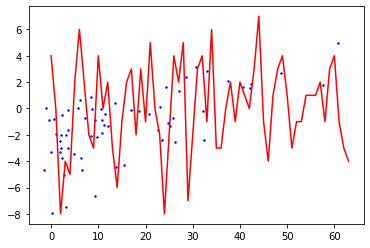

Epoch: 2600 Accurracy real: 0.3125 Accurracy fake: 0.890625
Epoch: 2601 Accurracy real: 0.03125 Accurracy fake: 0.875
Epoch: 2602 Accurracy real: 0.015625 Accurracy fake: 0.96875
Epoch: 2603 Accurracy real: 0.0625 Accurracy fake: 0.96875
Epoch: 2604 Accurracy real: 0.046875 Accurracy fake: 0.90625
Epoch: 2605 Accurracy real: 0.046875 Accurracy fake: 0.875
Epoch: 2606 Accurracy real: 0.171875 Accurracy fake: 0.96875
Epoch: 2607 Accurracy real: 0.0625 Accurracy fake: 1.0
Epoch: 2608 Accurracy real: 0.078125 Accurracy fake: 0.9375
Epoch: 2609 Accurracy real: 0.046875 Accurracy fake: 0.96875
Epoch: 2610 Accurracy real: 0.0625 Accurracy fake: 0.953125
Epoch: 2611 Accurracy real: 0.203125 Accurracy fake: 0.953125
Epoch: 2612 Accurracy real: 0.53125 Accurracy fake: 0.75
Epoch: 2613 Accurracy real: 0.640625 Accurracy fake: 0.71875
Epoch: 2614 Accurracy real: 0.71875 Accurracy fake: 0.734375
Epoch: 2615 Accurracy real: 0.703125 Accurracy fake: 0.6875
Epoch: 2616 Accurracy real: 0.75 Accurracy f

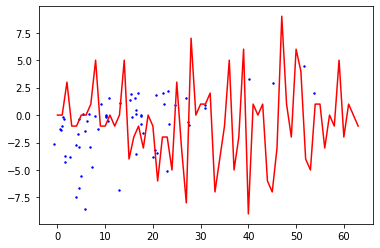

Epoch: 2650 Accurracy real: 0.84375 Accurracy fake: 0.375
Epoch: 2651 Accurracy real: 0.765625 Accurracy fake: 0.53125
Epoch: 2652 Accurracy real: 0.53125 Accurracy fake: 0.78125
Epoch: 2653 Accurracy real: 0.34375 Accurracy fake: 0.71875
Epoch: 2654 Accurracy real: 0.1875 Accurracy fake: 0.90625
Epoch: 2655 Accurracy real: 0.140625 Accurracy fake: 0.9375
Epoch: 2656 Accurracy real: 0.046875 Accurracy fake: 0.953125
Epoch: 2657 Accurracy real: 0.109375 Accurracy fake: 0.953125
Epoch: 2658 Accurracy real: 0.0625 Accurracy fake: 0.96875
Epoch: 2659 Accurracy real: 0.078125 Accurracy fake: 0.9375
Epoch: 2660 Accurracy real: 0.078125 Accurracy fake: 0.953125
Epoch: 2661 Accurracy real: 0.078125 Accurracy fake: 0.96875
Epoch: 2662 Accurracy real: 0.078125 Accurracy fake: 0.921875
Epoch: 2663 Accurracy real: 0.046875 Accurracy fake: 0.96875
Epoch: 2664 Accurracy real: 0.578125 Accurracy fake: 0.953125
Epoch: 2665 Accurracy real: 0.03125 Accurracy fake: 0.953125
Epoch: 2666 Accurracy real: 0.

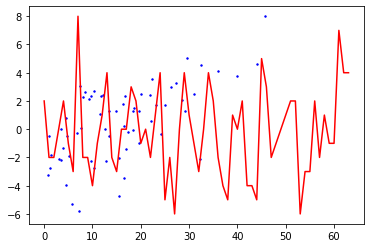

Epoch: 2700 Accurracy real: 0.875 Accurracy fake: 0.375
Epoch: 2701 Accurracy real: 0.890625 Accurracy fake: 0.328125
Epoch: 2702 Accurracy real: 0.90625 Accurracy fake: 0.296875
Epoch: 2703 Accurracy real: 0.84375 Accurracy fake: 0.25
Epoch: 2704 Accurracy real: 0.734375 Accurracy fake: 0.546875
Epoch: 2705 Accurracy real: 0.515625 Accurracy fake: 0.875
Epoch: 2706 Accurracy real: 0.140625 Accurracy fake: 0.96875
Epoch: 2707 Accurracy real: 0.046875 Accurracy fake: 0.9375
Epoch: 2708 Accurracy real: 0.109375 Accurracy fake: 0.9375
Epoch: 2709 Accurracy real: 0.046875 Accurracy fake: 0.90625
Epoch: 2710 Accurracy real: 0.109375 Accurracy fake: 0.890625
Epoch: 2711 Accurracy real: 0.09375 Accurracy fake: 0.9375
Epoch: 2712 Accurracy real: 0.09375 Accurracy fake: 0.828125
Epoch: 2713 Accurracy real: 0.140625 Accurracy fake: 0.84375
Epoch: 2714 Accurracy real: 0.203125 Accurracy fake: 0.84375
Epoch: 2715 Accurracy real: 0.296875 Accurracy fake: 0.703125
Epoch: 2716 Accurracy real: 0.54687

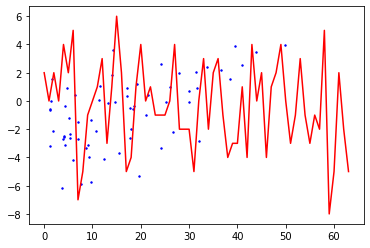

Epoch: 2750 Accurracy real: 0.28125 Accurracy fake: 0.734375
Epoch: 2751 Accurracy real: 0.34375 Accurracy fake: 0.796875
Epoch: 2752 Accurracy real: 0.21875 Accurracy fake: 0.84375
Epoch: 2753 Accurracy real: 0.109375 Accurracy fake: 0.921875
Epoch: 2754 Accurracy real: 0.09375 Accurracy fake: 0.84375
Epoch: 2755 Accurracy real: 0.0625 Accurracy fake: 0.9375
Epoch: 2756 Accurracy real: 0.125 Accurracy fake: 0.90625
Epoch: 2757 Accurracy real: 0.09375 Accurracy fake: 0.890625
Epoch: 2758 Accurracy real: 0.140625 Accurracy fake: 0.875
Epoch: 2759 Accurracy real: 0.15625 Accurracy fake: 0.90625
Epoch: 2760 Accurracy real: 0.3125 Accurracy fake: 0.75
Epoch: 2761 Accurracy real: 0.453125 Accurracy fake: 0.671875
Epoch: 2762 Accurracy real: 0.59375 Accurracy fake: 0.71875
Epoch: 2763 Accurracy real: 0.828125 Accurracy fake: 0.421875
Epoch: 2764 Accurracy real: 0.65625 Accurracy fake: 0.578125
Epoch: 2765 Accurracy real: 0.5 Accurracy fake: 0.65625
Epoch: 2766 Accurracy real: 0.390625 Accurr

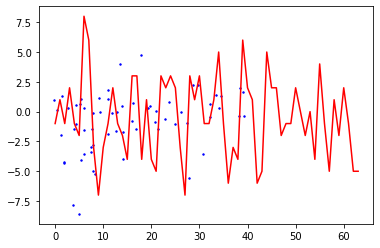

Epoch: 2800 Accurracy real: 0.203125 Accurracy fake: 0.6875
Epoch: 2801 Accurracy real: 0.265625 Accurracy fake: 0.6875
Epoch: 2802 Accurracy real: 0.203125 Accurracy fake: 0.78125
Epoch: 2803 Accurracy real: 0.375 Accurracy fake: 0.8125
Epoch: 2804 Accurracy real: 0.265625 Accurracy fake: 0.78125
Epoch: 2805 Accurracy real: 0.296875 Accurracy fake: 0.734375
Epoch: 2806 Accurracy real: 0.265625 Accurracy fake: 0.75
Epoch: 2807 Accurracy real: 0.234375 Accurracy fake: 0.75
Epoch: 2808 Accurracy real: 0.28125 Accurracy fake: 0.59375
Epoch: 2809 Accurracy real: 0.25 Accurracy fake: 0.703125
Epoch: 2810 Accurracy real: 0.3125 Accurracy fake: 0.71875
Epoch: 2811 Accurracy real: 0.1875 Accurracy fake: 0.765625
Epoch: 2812 Accurracy real: 0.21875 Accurracy fake: 0.734375
Epoch: 2813 Accurracy real: 0.234375 Accurracy fake: 0.671875
Epoch: 2814 Accurracy real: 0.328125 Accurracy fake: 0.578125
Epoch: 2815 Accurracy real: 0.359375 Accurracy fake: 0.59375
Epoch: 2816 Accurracy real: 0.359375 Acc

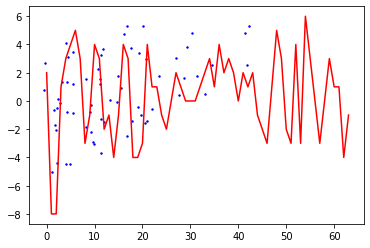

Epoch: 2850 Accurracy real: 0.328125 Accurracy fake: 0.5625
Epoch: 2851 Accurracy real: 0.28125 Accurracy fake: 0.375
Epoch: 2852 Accurracy real: 0.359375 Accurracy fake: 0.453125
Epoch: 2853 Accurracy real: 0.40625 Accurracy fake: 0.390625
Epoch: 2854 Accurracy real: 0.265625 Accurracy fake: 0.453125
Epoch: 2855 Accurracy real: 0.40625 Accurracy fake: 0.40625
Epoch: 2856 Accurracy real: 0.46875 Accurracy fake: 0.390625
Epoch: 2857 Accurracy real: 0.390625 Accurracy fake: 0.359375
Epoch: 2858 Accurracy real: 0.421875 Accurracy fake: 0.46875
Epoch: 2859 Accurracy real: 0.609375 Accurracy fake: 0.3125
Epoch: 2860 Accurracy real: 0.46875 Accurracy fake: 0.453125
Epoch: 2861 Accurracy real: 0.453125 Accurracy fake: 0.546875
Epoch: 2862 Accurracy real: 0.421875 Accurracy fake: 0.40625
Epoch: 2863 Accurracy real: 0.453125 Accurracy fake: 0.4375
Epoch: 2864 Accurracy real: 0.390625 Accurracy fake: 0.46875
Epoch: 2865 Accurracy real: 0.5 Accurracy fake: 0.4375
Epoch: 2866 Accurracy real: 0.390

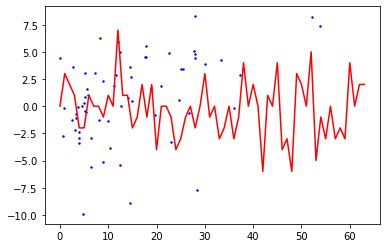

Epoch: 2900 Accurracy real: 0.765625 Accurracy fake: 0.453125
Epoch: 2901 Accurracy real: 0.765625 Accurracy fake: 0.46875
Epoch: 2902 Accurracy real: 0.765625 Accurracy fake: 0.375
Epoch: 2903 Accurracy real: 0.796875 Accurracy fake: 0.484375
Epoch: 2904 Accurracy real: 0.734375 Accurracy fake: 0.390625
Epoch: 2905 Accurracy real: 0.796875 Accurracy fake: 0.4375
Epoch: 2906 Accurracy real: 0.796875 Accurracy fake: 0.390625
Epoch: 2907 Accurracy real: 0.75 Accurracy fake: 0.34375
Epoch: 2908 Accurracy real: 0.78125 Accurracy fake: 0.640625
Epoch: 2909 Accurracy real: 0.65625 Accurracy fake: 0.375
Epoch: 2910 Accurracy real: 0.625 Accurracy fake: 0.640625
Epoch: 2911 Accurracy real: 0.65625 Accurracy fake: 0.515625
Epoch: 2912 Accurracy real: 0.640625 Accurracy fake: 0.484375
Epoch: 2913 Accurracy real: 0.59375 Accurracy fake: 0.5625
Epoch: 2914 Accurracy real: 0.515625 Accurracy fake: 0.40625
Epoch: 2915 Accurracy real: 0.546875 Accurracy fake: 0.671875
Epoch: 2916 Accurracy real: 0.56

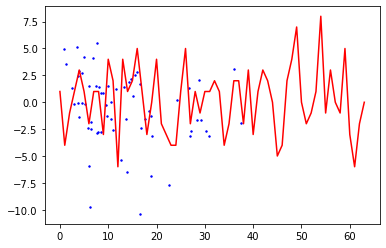

Epoch: 2950 Accurracy real: 0.765625 Accurracy fake: 0.4375
Epoch: 2951 Accurracy real: 0.78125 Accurracy fake: 0.4375
Epoch: 2952 Accurracy real: 0.671875 Accurracy fake: 0.484375
Epoch: 2953 Accurracy real: 0.71875 Accurracy fake: 0.5
Epoch: 2954 Accurracy real: 0.640625 Accurracy fake: 0.375
Epoch: 2955 Accurracy real: 0.609375 Accurracy fake: 0.578125
Epoch: 2956 Accurracy real: 0.46875 Accurracy fake: 0.53125
Epoch: 2957 Accurracy real: 0.53125 Accurracy fake: 0.609375
Epoch: 2958 Accurracy real: 0.5625 Accurracy fake: 0.5
Epoch: 2959 Accurracy real: 0.625 Accurracy fake: 0.53125
Epoch: 2960 Accurracy real: 0.640625 Accurracy fake: 0.359375
Epoch: 2961 Accurracy real: 0.609375 Accurracy fake: 0.390625
Epoch: 2962 Accurracy real: 0.671875 Accurracy fake: 0.328125
Epoch: 2963 Accurracy real: 0.625 Accurracy fake: 0.53125
Epoch: 2964 Accurracy real: 0.609375 Accurracy fake: 0.578125
Epoch: 2965 Accurracy real: 0.640625 Accurracy fake: 0.484375
Epoch: 2966 Accurracy real: 0.53125 Accu

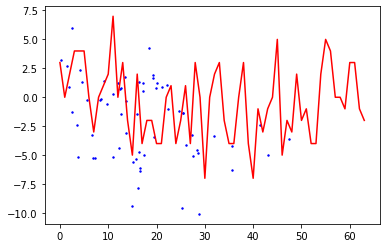

Epoch: 3000 Accurracy real: 0.15625 Accurracy fake: 0.578125
Epoch: 3001 Accurracy real: 0.578125 Accurracy fake: 0.625
Epoch: 3002 Accurracy real: 0.296875 Accurracy fake: 0.703125
Epoch: 3003 Accurracy real: 0.515625 Accurracy fake: 0.65625
Epoch: 3004 Accurracy real: 0.671875 Accurracy fake: 0.4375
Epoch: 3005 Accurracy real: 0.734375 Accurracy fake: 0.359375
Epoch: 3006 Accurracy real: 0.78125 Accurracy fake: 0.390625
Epoch: 3007 Accurracy real: 0.921875 Accurracy fake: 0.4375
Epoch: 3008 Accurracy real: 0.75 Accurracy fake: 0.46875
Epoch: 3009 Accurracy real: 0.59375 Accurracy fake: 0.34375
Epoch: 3010 Accurracy real: 0.609375 Accurracy fake: 0.375
Epoch: 3011 Accurracy real: 0.8125 Accurracy fake: 0.5
Epoch: 3012 Accurracy real: 0.640625 Accurracy fake: 0.453125
Epoch: 3013 Accurracy real: 0.640625 Accurracy fake: 0.578125
Epoch: 3014 Accurracy real: 0.78125 Accurracy fake: 0.390625
Epoch: 3015 Accurracy real: 0.640625 Accurracy fake: 0.453125
Epoch: 3016 Accurracy real: 0.75 Acc

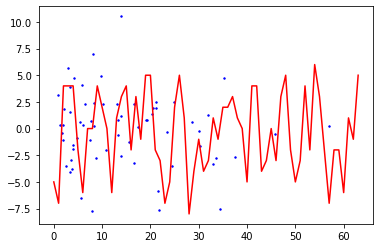

Epoch: 3050 Accurracy real: 0.28125 Accurracy fake: 0.671875
Epoch: 3051 Accurracy real: 0.375 Accurracy fake: 0.640625
Epoch: 3052 Accurracy real: 0.296875 Accurracy fake: 0.5625
Epoch: 3053 Accurracy real: 0.25 Accurracy fake: 0.609375
Epoch: 3054 Accurracy real: 0.65625 Accurracy fake: 0.59375
Epoch: 3055 Accurracy real: 0.3125 Accurracy fake: 0.5
Epoch: 3056 Accurracy real: 0.359375 Accurracy fake: 0.578125
Epoch: 3057 Accurracy real: 0.40625 Accurracy fake: 0.4375
Epoch: 3058 Accurracy real: 0.5 Accurracy fake: 0.5
Epoch: 3059 Accurracy real: 0.515625 Accurracy fake: 0.390625
Epoch: 3060 Accurracy real: 0.578125 Accurracy fake: 0.40625
Epoch: 3061 Accurracy real: 0.5 Accurracy fake: 0.359375
Epoch: 3062 Accurracy real: 0.75 Accurracy fake: 0.46875
Epoch: 3063 Accurracy real: 0.671875 Accurracy fake: 0.375
Epoch: 3064 Accurracy real: 0.6875 Accurracy fake: 0.34375
Epoch: 3065 Accurracy real: 0.640625 Accurracy fake: 0.3125
Epoch: 3066 Accurracy real: 0.671875 Accurracy fake: 0.3593

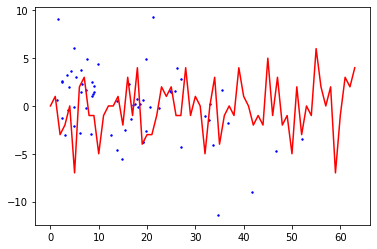

Epoch: 3100 Accurracy real: 0.390625 Accurracy fake: 0.484375
Epoch: 3101 Accurracy real: 0.4375 Accurracy fake: 0.484375
Epoch: 3102 Accurracy real: 0.4375 Accurracy fake: 0.4375
Epoch: 3103 Accurracy real: 0.34375 Accurracy fake: 0.5625
Epoch: 3104 Accurracy real: 0.421875 Accurracy fake: 0.46875
Epoch: 3105 Accurracy real: 0.40625 Accurracy fake: 0.53125
Epoch: 3106 Accurracy real: 0.34375 Accurracy fake: 0.484375
Epoch: 3107 Accurracy real: 0.40625 Accurracy fake: 0.453125
Epoch: 3108 Accurracy real: 0.453125 Accurracy fake: 0.4375
Epoch: 3109 Accurracy real: 0.5 Accurracy fake: 0.328125
Epoch: 3110 Accurracy real: 0.5 Accurracy fake: 0.46875
Epoch: 3111 Accurracy real: 0.59375 Accurracy fake: 0.46875
Epoch: 3112 Accurracy real: 0.5 Accurracy fake: 0.609375
Epoch: 3113 Accurracy real: 0.359375 Accurracy fake: 0.484375
Epoch: 3114 Accurracy real: 0.390625 Accurracy fake: 0.625
Epoch: 3115 Accurracy real: 0.328125 Accurracy fake: 0.515625
Epoch: 3116 Accurracy real: 0.453125 Accurrac

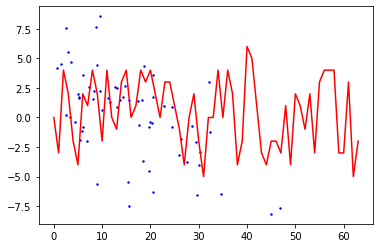

Epoch: 3150 Accurracy real: 0.203125 Accurracy fake: 0.546875
Epoch: 3151 Accurracy real: 0.3125 Accurracy fake: 0.578125
Epoch: 3152 Accurracy real: 0.40625 Accurracy fake: 0.546875
Epoch: 3153 Accurracy real: 0.5625 Accurracy fake: 0.515625
Epoch: 3154 Accurracy real: 0.625 Accurracy fake: 0.59375
Epoch: 3155 Accurracy real: 0.671875 Accurracy fake: 0.53125
Epoch: 3156 Accurracy real: 0.59375 Accurracy fake: 0.453125
Epoch: 3157 Accurracy real: 0.515625 Accurracy fake: 0.546875
Epoch: 3158 Accurracy real: 0.5625 Accurracy fake: 0.640625
Epoch: 3159 Accurracy real: 0.234375 Accurracy fake: 0.515625
Epoch: 3160 Accurracy real: 0.21875 Accurracy fake: 0.65625
Epoch: 3161 Accurracy real: 0.28125 Accurracy fake: 0.609375
Epoch: 3162 Accurracy real: 0.484375 Accurracy fake: 0.484375
Epoch: 3163 Accurracy real: 0.765625 Accurracy fake: 0.640625
Epoch: 3164 Accurracy real: 0.484375 Accurracy fake: 0.5
Epoch: 3165 Accurracy real: 0.515625 Accurracy fake: 0.5
Epoch: 3166 Accurracy real: 0.4375

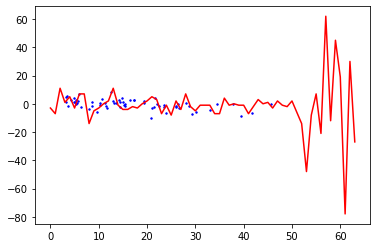

Epoch: 3200 Accurracy real: 0.5 Accurracy fake: 0.640625
Epoch: 3201 Accurracy real: 0.421875 Accurracy fake: 0.546875
Epoch: 3202 Accurracy real: 0.59375 Accurracy fake: 0.5625
Epoch: 3203 Accurracy real: 0.703125 Accurracy fake: 0.515625
Epoch: 3204 Accurracy real: 0.828125 Accurracy fake: 0.390625
Epoch: 3205 Accurracy real: 0.796875 Accurracy fake: 0.25
Epoch: 3206 Accurracy real: 0.859375 Accurracy fake: 0.25
Epoch: 3207 Accurracy real: 0.859375 Accurracy fake: 0.328125
Epoch: 3208 Accurracy real: 0.84375 Accurracy fake: 0.296875
Epoch: 3209 Accurracy real: 0.890625 Accurracy fake: 0.203125
Epoch: 3210 Accurracy real: 0.765625 Accurracy fake: 0.296875
Epoch: 3211 Accurracy real: 0.765625 Accurracy fake: 0.390625
Epoch: 3212 Accurracy real: 0.78125 Accurracy fake: 0.328125
Epoch: 3213 Accurracy real: 0.765625 Accurracy fake: 0.328125
Epoch: 3214 Accurracy real: 0.734375 Accurracy fake: 0.53125
Epoch: 3215 Accurracy real: 0.671875 Accurracy fake: 0.40625
Epoch: 3216 Accurracy real: 

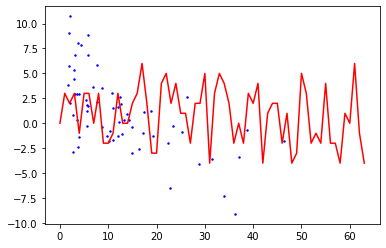

Epoch: 3250 Accurracy real: 0.390625 Accurracy fake: 0.765625
Epoch: 3251 Accurracy real: 0.171875 Accurracy fake: 0.671875
Epoch: 3252 Accurracy real: 0.21875 Accurracy fake: 0.71875
Epoch: 3253 Accurracy real: 0.25 Accurracy fake: 0.78125
Epoch: 3254 Accurracy real: 0.28125 Accurracy fake: 0.6875
Epoch: 3255 Accurracy real: 0.28125 Accurracy fake: 0.671875
Epoch: 3256 Accurracy real: 0.21875 Accurracy fake: 0.734375
Epoch: 3257 Accurracy real: 0.296875 Accurracy fake: 0.703125
Epoch: 3258 Accurracy real: 0.296875 Accurracy fake: 0.671875
Epoch: 3259 Accurracy real: 0.140625 Accurracy fake: 0.59375
Epoch: 3260 Accurracy real: 0.265625 Accurracy fake: 0.796875
Epoch: 3261 Accurracy real: 0.59375 Accurracy fake: 0.75
Epoch: 3262 Accurracy real: 0.234375 Accurracy fake: 0.6875
Epoch: 3263 Accurracy real: 0.09375 Accurracy fake: 0.703125
Epoch: 3264 Accurracy real: 0.171875 Accurracy fake: 0.765625
Epoch: 3265 Accurracy real: 0.109375 Accurracy fake: 0.734375
Epoch: 3266 Accurracy real: 0

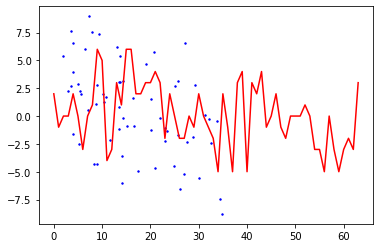

Epoch: 3300 Accurracy real: 0.796875 Accurracy fake: 0.4375
Epoch: 3301 Accurracy real: 0.765625 Accurracy fake: 0.578125
Epoch: 3302 Accurracy real: 0.765625 Accurracy fake: 0.53125
Epoch: 3303 Accurracy real: 0.6875 Accurracy fake: 0.65625
Epoch: 3304 Accurracy real: 0.65625 Accurracy fake: 0.484375
Epoch: 3305 Accurracy real: 0.578125 Accurracy fake: 0.59375
Epoch: 3306 Accurracy real: 0.5 Accurracy fake: 0.59375
Epoch: 3307 Accurracy real: 0.5 Accurracy fake: 0.640625
Epoch: 3308 Accurracy real: 0.390625 Accurracy fake: 0.71875
Epoch: 3309 Accurracy real: 0.5 Accurracy fake: 0.5625
Epoch: 3310 Accurracy real: 0.484375 Accurracy fake: 0.6875
Epoch: 3311 Accurracy real: 0.484375 Accurracy fake: 0.609375
Epoch: 3312 Accurracy real: 0.390625 Accurracy fake: 0.671875
Epoch: 3313 Accurracy real: 0.359375 Accurracy fake: 0.734375
Epoch: 3314 Accurracy real: 0.296875 Accurracy fake: 0.796875
Epoch: 3315 Accurracy real: 0.265625 Accurracy fake: 0.703125
Epoch: 3316 Accurracy real: 0.1875 Ac

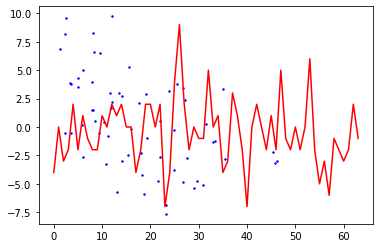

Epoch: 3350 Accurracy real: 0.09375 Accurracy fake: 0.84375
Epoch: 3351 Accurracy real: 0.1875 Accurracy fake: 0.921875
Epoch: 3352 Accurracy real: 0.109375 Accurracy fake: 0.84375
Epoch: 3353 Accurracy real: 0.125 Accurracy fake: 0.890625
Epoch: 3354 Accurracy real: 0.140625 Accurracy fake: 0.875
Epoch: 3355 Accurracy real: 0.109375 Accurracy fake: 0.828125
Epoch: 3356 Accurracy real: 0.171875 Accurracy fake: 0.84375
Epoch: 3357 Accurracy real: 0.078125 Accurracy fake: 0.890625
Epoch: 3358 Accurracy real: 0.25 Accurracy fake: 0.828125
Epoch: 3359 Accurracy real: 0.53125 Accurracy fake: 0.875
Epoch: 3360 Accurracy real: 0.640625 Accurracy fake: 0.8125
Epoch: 3361 Accurracy real: 0.6875 Accurracy fake: 0.765625
Epoch: 3362 Accurracy real: 0.71875 Accurracy fake: 0.65625
Epoch: 3363 Accurracy real: 0.859375 Accurracy fake: 0.625
Epoch: 3364 Accurracy real: 0.765625 Accurracy fake: 0.53125
Epoch: 3365 Accurracy real: 0.75 Accurracy fake: 0.5625
Epoch: 3366 Accurracy real: 0.8125 Accurracy

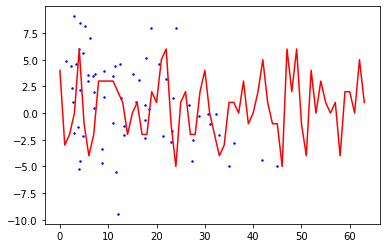

Epoch: 3400 Accurracy real: 0.15625 Accurracy fake: 0.640625
Epoch: 3401 Accurracy real: 0.25 Accurracy fake: 0.796875
Epoch: 3402 Accurracy real: 0.484375 Accurracy fake: 0.8125
Epoch: 3403 Accurracy real: 0.1875 Accurracy fake: 0.75
Epoch: 3404 Accurracy real: 0.21875 Accurracy fake: 0.71875
Epoch: 3405 Accurracy real: 0.21875 Accurracy fake: 0.765625
Epoch: 3406 Accurracy real: 0.171875 Accurracy fake: 0.65625
Epoch: 3407 Accurracy real: 0.3125 Accurracy fake: 0.71875
Epoch: 3408 Accurracy real: 0.25 Accurracy fake: 0.75
Epoch: 3409 Accurracy real: 0.078125 Accurracy fake: 0.875
Epoch: 3410 Accurracy real: 0.25 Accurracy fake: 0.8125
Epoch: 3411 Accurracy real: 0.21875 Accurracy fake: 0.8125
Epoch: 3412 Accurracy real: 0.15625 Accurracy fake: 0.8125
Epoch: 3413 Accurracy real: 0.109375 Accurracy fake: 0.84375
Epoch: 3414 Accurracy real: 0.125 Accurracy fake: 0.796875
Epoch: 3415 Accurracy real: 0.0625 Accurracy fake: 0.796875
Epoch: 3416 Accurracy real: 0.078125 Accurracy fake: 0.79

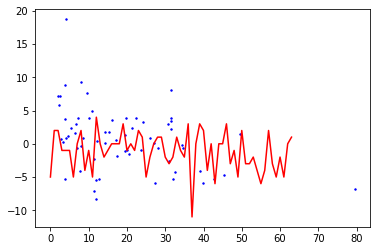

Epoch: 3450 Accurracy real: 0.078125 Accurracy fake: 0.96875
Epoch: 3451 Accurracy real: 0.03125 Accurracy fake: 0.8125
Epoch: 3452 Accurracy real: 0.078125 Accurracy fake: 0.875
Epoch: 3453 Accurracy real: 0.046875 Accurracy fake: 0.890625
Epoch: 3454 Accurracy real: 0.078125 Accurracy fake: 0.90625
Epoch: 3455 Accurracy real: 0.09375 Accurracy fake: 0.828125
Epoch: 3456 Accurracy real: 0.15625 Accurracy fake: 0.859375
Epoch: 3457 Accurracy real: 0.0625 Accurracy fake: 0.859375
Epoch: 3458 Accurracy real: 0.078125 Accurracy fake: 0.8125
Epoch: 3459 Accurracy real: 0.078125 Accurracy fake: 0.796875
Epoch: 3460 Accurracy real: 0.125 Accurracy fake: 0.75
Epoch: 3461 Accurracy real: 0.40625 Accurracy fake: 0.875
Epoch: 3462 Accurracy real: 0.34375 Accurracy fake: 0.796875
Epoch: 3463 Accurracy real: 0.40625 Accurracy fake: 0.703125
Epoch: 3464 Accurracy real: 0.34375 Accurracy fake: 0.8125
Epoch: 3465 Accurracy real: 0.140625 Accurracy fake: 0.796875
Epoch: 3466 Accurracy real: 0.15625 Ac

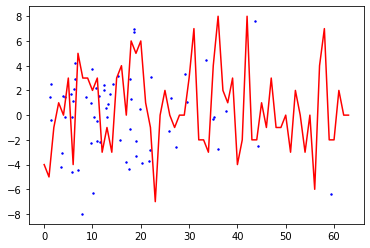

Epoch: 3500 Accurracy real: 0.234375 Accurracy fake: 0.703125
Epoch: 3501 Accurracy real: 0.328125 Accurracy fake: 0.796875
Epoch: 3502 Accurracy real: 0.34375 Accurracy fake: 0.640625
Epoch: 3503 Accurracy real: 0.390625 Accurracy fake: 0.71875
Epoch: 3504 Accurracy real: 0.375 Accurracy fake: 0.71875
Epoch: 3505 Accurracy real: 0.265625 Accurracy fake: 0.640625
Epoch: 3506 Accurracy real: 0.265625 Accurracy fake: 0.75
Epoch: 3507 Accurracy real: 0.28125 Accurracy fake: 0.65625
Epoch: 3508 Accurracy real: 0.28125 Accurracy fake: 0.75
Epoch: 3509 Accurracy real: 0.3125 Accurracy fake: 0.703125
Epoch: 3510 Accurracy real: 0.296875 Accurracy fake: 0.65625
Epoch: 3511 Accurracy real: 0.28125 Accurracy fake: 0.734375
Epoch: 3512 Accurracy real: 0.171875 Accurracy fake: 0.734375
Epoch: 3513 Accurracy real: 0.109375 Accurracy fake: 0.828125
Epoch: 3514 Accurracy real: 0.234375 Accurracy fake: 0.765625
Epoch: 3515 Accurracy real: 0.09375 Accurracy fake: 0.796875
Epoch: 3516 Accurracy real: 0.

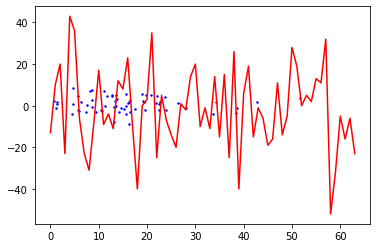

Epoch: 3550 Accurracy real: 0.328125 Accurracy fake: 0.71875
Epoch: 3551 Accurracy real: 0.234375 Accurracy fake: 0.78125
Epoch: 3552 Accurracy real: 0.15625 Accurracy fake: 0.875
Epoch: 3553 Accurracy real: 0.09375 Accurracy fake: 0.765625
Epoch: 3554 Accurracy real: 0.09375 Accurracy fake: 0.859375
Epoch: 3555 Accurracy real: 0.109375 Accurracy fake: 0.8125
Epoch: 3556 Accurracy real: 0.078125 Accurracy fake: 0.859375
Epoch: 3557 Accurracy real: 0.09375 Accurracy fake: 0.84375
Epoch: 3558 Accurracy real: 0.09375 Accurracy fake: 0.859375
Epoch: 3559 Accurracy real: 0.125 Accurracy fake: 0.84375
Epoch: 3560 Accurracy real: 0.0625 Accurracy fake: 0.8125
Epoch: 3561 Accurracy real: 0.15625 Accurracy fake: 0.734375
Epoch: 3562 Accurracy real: 0.375 Accurracy fake: 0.75
Epoch: 3563 Accurracy real: 0.640625 Accurracy fake: 0.59375
Epoch: 3564 Accurracy real: 0.703125 Accurracy fake: 0.484375
Epoch: 3565 Accurracy real: 0.6875 Accurracy fake: 0.546875
Epoch: 3566 Accurracy real: 0.53125 Accu

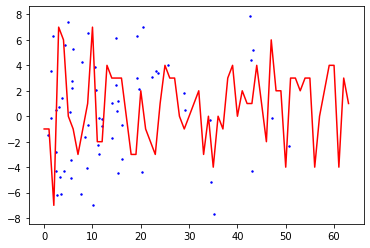

Epoch: 3600 Accurracy real: 0.046875 Accurracy fake: 0.828125
Epoch: 3601 Accurracy real: 0.078125 Accurracy fake: 0.6875
Epoch: 3602 Accurracy real: 0.09375 Accurracy fake: 0.828125
Epoch: 3603 Accurracy real: 0.09375 Accurracy fake: 0.796875
Epoch: 3604 Accurracy real: 0.09375 Accurracy fake: 0.84375
Epoch: 3605 Accurracy real: 0.140625 Accurracy fake: 0.78125
Epoch: 3606 Accurracy real: 0.140625 Accurracy fake: 0.78125
Epoch: 3607 Accurracy real: 0.09375 Accurracy fake: 0.734375
Epoch: 3608 Accurracy real: 0.171875 Accurracy fake: 0.796875
Epoch: 3609 Accurracy real: 0.328125 Accurracy fake: 0.78125
Epoch: 3610 Accurracy real: 0.46875 Accurracy fake: 0.625
Epoch: 3611 Accurracy real: 0.6875 Accurracy fake: 0.609375
Epoch: 3612 Accurracy real: 0.65625 Accurracy fake: 0.546875
Epoch: 3613 Accurracy real: 0.71875 Accurracy fake: 0.53125
Epoch: 3614 Accurracy real: 0.828125 Accurracy fake: 0.515625
Epoch: 3615 Accurracy real: 0.75 Accurracy fake: 0.5625
Epoch: 3616 Accurracy real: 0.656

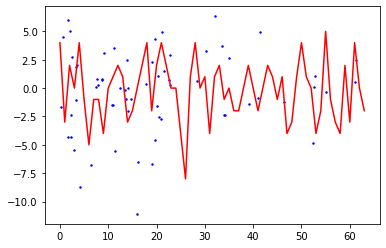

Epoch: 3650 Accurracy real: 0.53125 Accurracy fake: 0.75
Epoch: 3651 Accurracy real: 0.515625 Accurracy fake: 0.734375
Epoch: 3652 Accurracy real: 0.421875 Accurracy fake: 0.8125
Epoch: 3653 Accurracy real: 0.25 Accurracy fake: 0.828125
Epoch: 3654 Accurracy real: 0.15625 Accurracy fake: 0.890625
Epoch: 3655 Accurracy real: 0.140625 Accurracy fake: 0.84375
Epoch: 3656 Accurracy real: 0.15625 Accurracy fake: 0.875
Epoch: 3657 Accurracy real: 0.046875 Accurracy fake: 0.859375
Epoch: 3658 Accurracy real: 0.015625 Accurracy fake: 0.890625
Epoch: 3659 Accurracy real: 0.09375 Accurracy fake: 0.78125
Epoch: 3660 Accurracy real: 0.046875 Accurracy fake: 0.84375
Epoch: 3661 Accurracy real: 0.21875 Accurracy fake: 0.84375
Epoch: 3662 Accurracy real: 0.171875 Accurracy fake: 0.84375
Epoch: 3663 Accurracy real: 0.03125 Accurracy fake: 0.921875
Epoch: 3664 Accurracy real: 0.09375 Accurracy fake: 0.828125
Epoch: 3665 Accurracy real: 0.109375 Accurracy fake: 0.84375
Epoch: 3666 Accurracy real: 0.1562

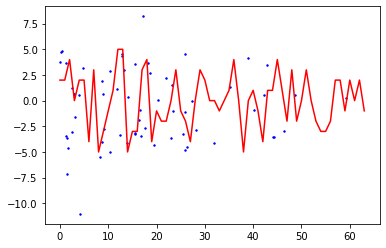

Epoch: 3700 Accurracy real: 0.796875 Accurracy fake: 0.390625
Epoch: 3701 Accurracy real: 0.78125 Accurracy fake: 0.375
Epoch: 3702 Accurracy real: 0.765625 Accurracy fake: 0.5
Epoch: 3703 Accurracy real: 0.5625 Accurracy fake: 0.640625
Epoch: 3704 Accurracy real: 0.15625 Accurracy fake: 0.796875
Epoch: 3705 Accurracy real: 0.03125 Accurracy fake: 0.75
Epoch: 3706 Accurracy real: 0.078125 Accurracy fake: 0.796875
Epoch: 3707 Accurracy real: 0.109375 Accurracy fake: 0.890625
Epoch: 3708 Accurracy real: 0.046875 Accurracy fake: 0.890625
Epoch: 3709 Accurracy real: 0.109375 Accurracy fake: 0.921875
Epoch: 3710 Accurracy real: 0.1875 Accurracy fake: 0.859375
Epoch: 3711 Accurracy real: 0.125 Accurracy fake: 0.8125
Epoch: 3712 Accurracy real: 0.203125 Accurracy fake: 0.828125
Epoch: 3713 Accurracy real: 0.15625 Accurracy fake: 0.796875
Epoch: 3714 Accurracy real: 0.15625 Accurracy fake: 0.65625
Epoch: 3715 Accurracy real: 0.34375 Accurracy fake: 0.75
Epoch: 3716 Accurracy real: 0.21875 Accu

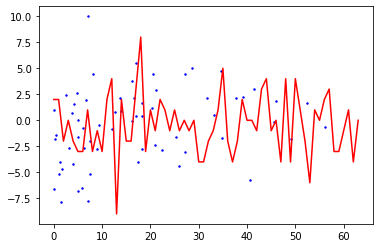

Epoch: 3750 Accurracy real: 0.171875 Accurracy fake: 0.734375
Epoch: 3751 Accurracy real: 0.15625 Accurracy fake: 0.8125
Epoch: 3752 Accurracy real: 0.140625 Accurracy fake: 0.6875
Epoch: 3753 Accurracy real: 0.15625 Accurracy fake: 0.8125
Epoch: 3754 Accurracy real: 0.09375 Accurracy fake: 0.859375
Epoch: 3755 Accurracy real: 0.125 Accurracy fake: 0.796875
Epoch: 3756 Accurracy real: 0.21875 Accurracy fake: 0.71875
Epoch: 3757 Accurracy real: 0.25 Accurracy fake: 0.625
Epoch: 3758 Accurracy real: 0.265625 Accurracy fake: 0.828125
Epoch: 3759 Accurracy real: 0.359375 Accurracy fake: 0.59375
Epoch: 3760 Accurracy real: 0.234375 Accurracy fake: 0.828125
Epoch: 3761 Accurracy real: 0.21875 Accurracy fake: 0.625
Epoch: 3762 Accurracy real: 0.25 Accurracy fake: 0.703125
Epoch: 3763 Accurracy real: 0.453125 Accurracy fake: 0.65625
Epoch: 3764 Accurracy real: 0.453125 Accurracy fake: 0.59375
Epoch: 3765 Accurracy real: 0.59375 Accurracy fake: 0.609375
Epoch: 3766 Accurracy real: 0.609375 Accu

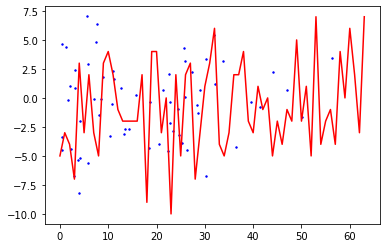

Epoch: 3800 Accurracy real: 0.28125 Accurracy fake: 0.765625
Epoch: 3801 Accurracy real: 0.109375 Accurracy fake: 0.765625
Epoch: 3802 Accurracy real: 0.390625 Accurracy fake: 0.59375
Epoch: 3803 Accurracy real: 0.53125 Accurracy fake: 0.5625
Epoch: 3804 Accurracy real: 0.578125 Accurracy fake: 0.609375
Epoch: 3805 Accurracy real: 0.71875 Accurracy fake: 0.34375
Epoch: 3806 Accurracy real: 0.578125 Accurracy fake: 0.328125
Epoch: 3807 Accurracy real: 0.6875 Accurracy fake: 0.390625
Epoch: 3808 Accurracy real: 0.625 Accurracy fake: 0.546875
Epoch: 3809 Accurracy real: 0.515625 Accurracy fake: 0.4375
Epoch: 3810 Accurracy real: 0.453125 Accurracy fake: 0.515625
Epoch: 3811 Accurracy real: 0.25 Accurracy fake: 0.515625
Epoch: 3812 Accurracy real: 0.328125 Accurracy fake: 0.765625
Epoch: 3813 Accurracy real: 0.15625 Accurracy fake: 0.671875
Epoch: 3814 Accurracy real: 0.171875 Accurracy fake: 0.765625
Epoch: 3815 Accurracy real: 0.171875 Accurracy fake: 0.8125
Epoch: 3816 Accurracy real: 0

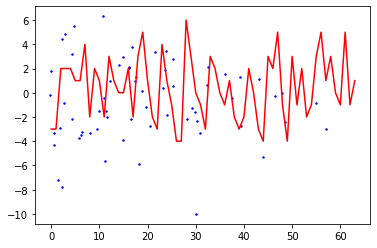

Epoch: 3850 Accurracy real: 0.125 Accurracy fake: 0.75
Epoch: 3851 Accurracy real: 0.078125 Accurracy fake: 0.8125
Epoch: 3852 Accurracy real: 0.171875 Accurracy fake: 0.71875
Epoch: 3853 Accurracy real: 0.140625 Accurracy fake: 0.71875
Epoch: 3854 Accurracy real: 0.234375 Accurracy fake: 0.828125
Epoch: 3855 Accurracy real: 0.140625 Accurracy fake: 0.796875
Epoch: 3856 Accurracy real: 0.28125 Accurracy fake: 0.765625
Epoch: 3857 Accurracy real: 0.03125 Accurracy fake: 0.8125
Epoch: 3858 Accurracy real: 0.109375 Accurracy fake: 0.71875
Epoch: 3859 Accurracy real: 0.140625 Accurracy fake: 0.90625
Epoch: 3860 Accurracy real: 0.171875 Accurracy fake: 0.75
Epoch: 3861 Accurracy real: 0.296875 Accurracy fake: 0.671875
Epoch: 3862 Accurracy real: 0.3125 Accurracy fake: 0.84375
Epoch: 3863 Accurracy real: 0.078125 Accurracy fake: 0.765625
Epoch: 3864 Accurracy real: 0.0625 Accurracy fake: 0.75
Epoch: 3865 Accurracy real: 0.109375 Accurracy fake: 0.71875
Epoch: 3866 Accurracy real: 0.15625 Acc

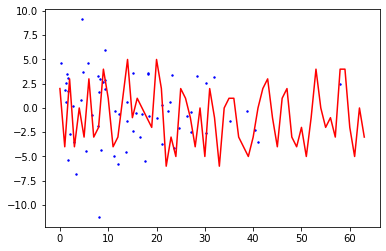

Epoch: 3900 Accurracy real: 0.453125 Accurracy fake: 0.5
Epoch: 3901 Accurracy real: 0.453125 Accurracy fake: 0.53125
Epoch: 3902 Accurracy real: 0.453125 Accurracy fake: 0.375
Epoch: 3903 Accurracy real: 0.578125 Accurracy fake: 0.375
Epoch: 3904 Accurracy real: 0.53125 Accurracy fake: 0.390625
Epoch: 3905 Accurracy real: 0.546875 Accurracy fake: 0.453125
Epoch: 3906 Accurracy real: 0.421875 Accurracy fake: 0.40625
Epoch: 3907 Accurracy real: 0.5625 Accurracy fake: 0.421875
Epoch: 3908 Accurracy real: 0.515625 Accurracy fake: 0.359375
Epoch: 3909 Accurracy real: 0.5 Accurracy fake: 0.484375
Epoch: 3910 Accurracy real: 0.515625 Accurracy fake: 0.4375
Epoch: 3911 Accurracy real: 0.625 Accurracy fake: 0.53125
Epoch: 3912 Accurracy real: 0.328125 Accurracy fake: 0.546875
Epoch: 3913 Accurracy real: 0.453125 Accurracy fake: 0.609375
Epoch: 3914 Accurracy real: 0.34375 Accurracy fake: 0.546875
Epoch: 3915 Accurracy real: 0.390625 Accurracy fake: 0.5
Epoch: 3916 Accurracy real: 0.4375 Accurr

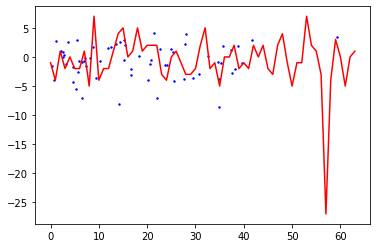

Epoch: 3950 Accurracy real: 0.21875 Accurracy fake: 0.671875
Epoch: 3951 Accurracy real: 0.28125 Accurracy fake: 0.546875
Epoch: 3952 Accurracy real: 0.171875 Accurracy fake: 0.609375
Epoch: 3953 Accurracy real: 0.171875 Accurracy fake: 0.53125
Epoch: 3954 Accurracy real: 0.21875 Accurracy fake: 0.671875
Epoch: 3955 Accurracy real: 0.203125 Accurracy fake: 0.609375
Epoch: 3956 Accurracy real: 0.28125 Accurracy fake: 0.640625
Epoch: 3957 Accurracy real: 0.421875 Accurracy fake: 0.484375
Epoch: 3958 Accurracy real: 0.40625 Accurracy fake: 0.625
Epoch: 3959 Accurracy real: 0.390625 Accurracy fake: 0.515625
Epoch: 3960 Accurracy real: 0.53125 Accurracy fake: 0.5625
Epoch: 3961 Accurracy real: 0.6875 Accurracy fake: 0.390625
Epoch: 3962 Accurracy real: 0.703125 Accurracy fake: 0.46875
Epoch: 3963 Accurracy real: 0.484375 Accurracy fake: 0.3125
Epoch: 3964 Accurracy real: 0.578125 Accurracy fake: 0.34375
Epoch: 3965 Accurracy real: 0.34375 Accurracy fake: 0.421875
Epoch: 3966 Accurracy real:

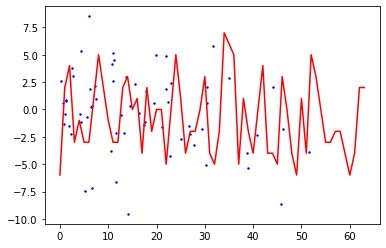

Epoch: 4000 Accurracy real: 0.859375 Accurracy fake: 0.15625
Epoch: 4001 Accurracy real: 0.71875 Accurracy fake: 0.265625
Epoch: 4002 Accurracy real: 0.71875 Accurracy fake: 0.328125
Epoch: 4003 Accurracy real: 0.40625 Accurracy fake: 0.53125
Epoch: 4004 Accurracy real: 0.46875 Accurracy fake: 0.421875
Epoch: 4005 Accurracy real: 0.421875 Accurracy fake: 0.609375
Epoch: 4006 Accurracy real: 0.21875 Accurracy fake: 0.625
Epoch: 4007 Accurracy real: 0.109375 Accurracy fake: 0.78125
Epoch: 4008 Accurracy real: 0.21875 Accurracy fake: 0.625
Epoch: 4009 Accurracy real: 0.109375 Accurracy fake: 0.6875
Epoch: 4010 Accurracy real: 0.109375 Accurracy fake: 0.640625
Epoch: 4011 Accurracy real: 0.140625 Accurracy fake: 0.765625
Epoch: 4012 Accurracy real: 0.15625 Accurracy fake: 0.5625
Epoch: 4013 Accurracy real: 0.265625 Accurracy fake: 0.59375
Epoch: 4014 Accurracy real: 0.125 Accurracy fake: 0.578125
Epoch: 4015 Accurracy real: 0.203125 Accurracy fake: 0.640625
Epoch: 4016 Accurracy real: 0.25

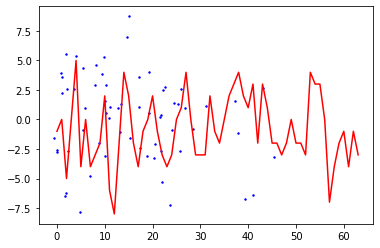

Epoch: 4050 Accurracy real: 0.1875 Accurracy fake: 0.625
Epoch: 4051 Accurracy real: 0.1875 Accurracy fake: 0.59375
Epoch: 4052 Accurracy real: 0.171875 Accurracy fake: 0.609375
Epoch: 4053 Accurracy real: 0.40625 Accurracy fake: 0.5625
Epoch: 4054 Accurracy real: 0.5 Accurracy fake: 0.671875
Epoch: 4055 Accurracy real: 0.15625 Accurracy fake: 0.625
Epoch: 4056 Accurracy real: 0.234375 Accurracy fake: 0.515625
Epoch: 4057 Accurracy real: 0.359375 Accurracy fake: 0.53125
Epoch: 4058 Accurracy real: 0.5625 Accurracy fake: 0.296875
Epoch: 4059 Accurracy real: 0.8125 Accurracy fake: 0.328125
Epoch: 4060 Accurracy real: 0.796875 Accurracy fake: 0.28125
Epoch: 4061 Accurracy real: 0.640625 Accurracy fake: 0.25
Epoch: 4062 Accurracy real: 0.671875 Accurracy fake: 0.296875
Epoch: 4063 Accurracy real: 0.65625 Accurracy fake: 0.28125
Epoch: 4064 Accurracy real: 0.671875 Accurracy fake: 0.328125
Epoch: 4065 Accurracy real: 0.359375 Accurracy fake: 0.40625
Epoch: 4066 Accurracy real: 0.328125 Accu

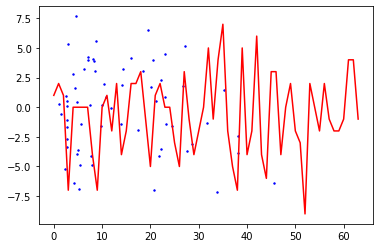

Epoch: 4100 Accurracy real: 0.34375 Accurracy fake: 0.515625
Epoch: 4101 Accurracy real: 0.328125 Accurracy fake: 0.484375
Epoch: 4102 Accurracy real: 0.28125 Accurracy fake: 0.59375
Epoch: 4103 Accurracy real: 0.1875 Accurracy fake: 0.65625
Epoch: 4104 Accurracy real: 0.265625 Accurracy fake: 0.75
Epoch: 4105 Accurracy real: 0.234375 Accurracy fake: 0.640625
Epoch: 4106 Accurracy real: 0.40625 Accurracy fake: 0.53125
Epoch: 4107 Accurracy real: 0.296875 Accurracy fake: 0.359375
Epoch: 4108 Accurracy real: 0.515625 Accurracy fake: 0.390625
Epoch: 4109 Accurracy real: 0.640625 Accurracy fake: 0.359375
Epoch: 4110 Accurracy real: 0.625 Accurracy fake: 0.359375
Epoch: 4111 Accurracy real: 0.640625 Accurracy fake: 0.359375
Epoch: 4112 Accurracy real: 0.578125 Accurracy fake: 0.3125
Epoch: 4113 Accurracy real: 0.5625 Accurracy fake: 0.25
Epoch: 4114 Accurracy real: 0.546875 Accurracy fake: 0.34375
Epoch: 4115 Accurracy real: 0.5 Accurracy fake: 0.328125
Epoch: 4116 Accurracy real: 0.578125 

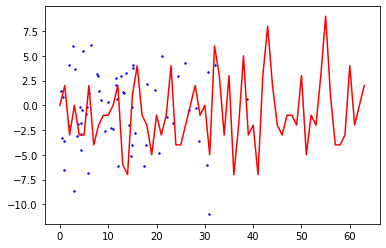

Epoch: 4150 Accurracy real: 0.1875 Accurracy fake: 0.59375
Epoch: 4151 Accurracy real: 0.15625 Accurracy fake: 0.734375
Epoch: 4152 Accurracy real: 0.21875 Accurracy fake: 0.609375
Epoch: 4153 Accurracy real: 0.203125 Accurracy fake: 0.625
Epoch: 4154 Accurracy real: 0.34375 Accurracy fake: 0.53125
Epoch: 4155 Accurracy real: 0.265625 Accurracy fake: 0.515625
Epoch: 4156 Accurracy real: 0.4375 Accurracy fake: 0.46875
Epoch: 4157 Accurracy real: 0.453125 Accurracy fake: 0.375
Epoch: 4158 Accurracy real: 0.515625 Accurracy fake: 0.375
Epoch: 4159 Accurracy real: 0.59375 Accurracy fake: 0.375
Epoch: 4160 Accurracy real: 0.46875 Accurracy fake: 0.359375
Epoch: 4161 Accurracy real: 0.5625 Accurracy fake: 0.40625
Epoch: 4162 Accurracy real: 0.46875 Accurracy fake: 0.515625
Epoch: 4163 Accurracy real: 0.390625 Accurracy fake: 0.484375
Epoch: 4164 Accurracy real: 0.34375 Accurracy fake: 0.625
Epoch: 4165 Accurracy real: 0.265625 Accurracy fake: 0.453125
Epoch: 4166 Accurracy real: 0.28125 Accu

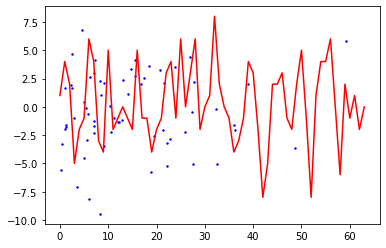

Epoch: 4200 Accurracy real: 0.421875 Accurracy fake: 0.328125
Epoch: 4201 Accurracy real: 0.53125 Accurracy fake: 0.4375
Epoch: 4202 Accurracy real: 0.421875 Accurracy fake: 0.359375
Epoch: 4203 Accurracy real: 0.46875 Accurracy fake: 0.25
Epoch: 4204 Accurracy real: 0.484375 Accurracy fake: 0.453125
Epoch: 4205 Accurracy real: 0.5 Accurracy fake: 0.390625
Epoch: 4206 Accurracy real: 0.515625 Accurracy fake: 0.4375
Epoch: 4207 Accurracy real: 0.453125 Accurracy fake: 0.46875
Epoch: 4208 Accurracy real: 0.3125 Accurracy fake: 0.484375
Epoch: 4209 Accurracy real: 0.25 Accurracy fake: 0.5
Epoch: 4210 Accurracy real: 0.21875 Accurracy fake: 0.5625
Epoch: 4211 Accurracy real: 0.234375 Accurracy fake: 0.515625
Epoch: 4212 Accurracy real: 0.296875 Accurracy fake: 0.609375
Epoch: 4213 Accurracy real: 0.296875 Accurracy fake: 0.5625
Epoch: 4214 Accurracy real: 0.25 Accurracy fake: 0.609375
Epoch: 4215 Accurracy real: 0.34375 Accurracy fake: 0.609375
Epoch: 4216 Accurracy real: 0.21875 Accurracy

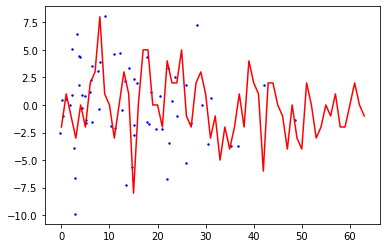

Epoch: 4250 Accurracy real: 0.171875 Accurracy fake: 0.65625
Epoch: 4251 Accurracy real: 0.25 Accurracy fake: 0.6875
Epoch: 4252 Accurracy real: 0.171875 Accurracy fake: 0.609375
Epoch: 4253 Accurracy real: 0.0625 Accurracy fake: 0.734375
Epoch: 4254 Accurracy real: 0.140625 Accurracy fake: 0.734375
Epoch: 4255 Accurracy real: 0.15625 Accurracy fake: 0.6875
Epoch: 4256 Accurracy real: 0.140625 Accurracy fake: 0.8125
Epoch: 4257 Accurracy real: 0.390625 Accurracy fake: 0.765625
Epoch: 4258 Accurracy real: 0.078125 Accurracy fake: 0.734375
Epoch: 4259 Accurracy real: 0.140625 Accurracy fake: 0.671875
Epoch: 4260 Accurracy real: 0.375 Accurracy fake: 0.578125
Epoch: 4261 Accurracy real: 0.21875 Accurracy fake: 0.484375
Epoch: 4262 Accurracy real: 0.234375 Accurracy fake: 0.640625
Epoch: 4263 Accurracy real: 0.25 Accurracy fake: 0.359375
Epoch: 4264 Accurracy real: 0.4375 Accurracy fake: 0.5
Epoch: 4265 Accurracy real: 0.5 Accurracy fake: 0.328125
Epoch: 4266 Accurracy real: 0.515625 Accur

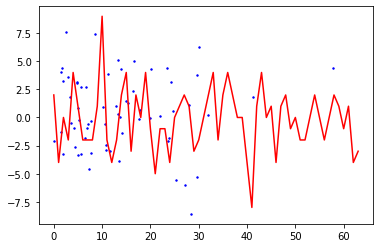

Epoch: 4300 Accurracy real: 0.328125 Accurracy fake: 0.515625
Epoch: 4301 Accurracy real: 0.40625 Accurracy fake: 0.46875
Epoch: 4302 Accurracy real: 0.421875 Accurracy fake: 0.453125
Epoch: 4303 Accurracy real: 0.640625 Accurracy fake: 0.265625
Epoch: 4304 Accurracy real: 0.703125 Accurracy fake: 0.15625
Epoch: 4305 Accurracy real: 0.65625 Accurracy fake: 0.171875
Epoch: 4306 Accurracy real: 0.78125 Accurracy fake: 0.1875
Epoch: 4307 Accurracy real: 0.515625 Accurracy fake: 0.25
Epoch: 4308 Accurracy real: 0.28125 Accurracy fake: 0.46875
Epoch: 4309 Accurracy real: 0.203125 Accurracy fake: 0.4375
Epoch: 4310 Accurracy real: 0.1875 Accurracy fake: 0.5625
Epoch: 4311 Accurracy real: 0.09375 Accurracy fake: 0.53125
Epoch: 4312 Accurracy real: 0.171875 Accurracy fake: 0.6875
Epoch: 4313 Accurracy real: 0.421875 Accurracy fake: 0.625
Epoch: 4314 Accurracy real: 0.078125 Accurracy fake: 0.703125
Epoch: 4315 Accurracy real: 0.140625 Accurracy fake: 0.640625
Epoch: 4316 Accurracy real: 0.1406

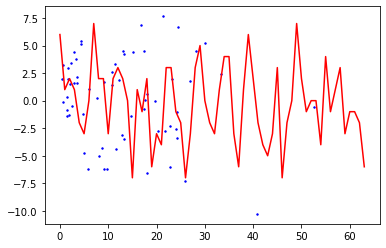

Epoch: 4350 Accurracy real: 0.734375 Accurracy fake: 0.375
Epoch: 4351 Accurracy real: 0.609375 Accurracy fake: 0.34375
Epoch: 4352 Accurracy real: 0.625 Accurracy fake: 0.4375
Epoch: 4353 Accurracy real: 0.46875 Accurracy fake: 0.515625
Epoch: 4354 Accurracy real: 0.390625 Accurracy fake: 0.46875
Epoch: 4355 Accurracy real: 0.4375 Accurracy fake: 0.53125
Epoch: 4356 Accurracy real: 0.453125 Accurracy fake: 0.4375
Epoch: 4357 Accurracy real: 0.5 Accurracy fake: 0.40625
Epoch: 4358 Accurracy real: 0.4375 Accurracy fake: 0.4375
Epoch: 4359 Accurracy real: 0.484375 Accurracy fake: 0.484375
Epoch: 4360 Accurracy real: 0.359375 Accurracy fake: 0.375
Epoch: 4361 Accurracy real: 0.5625 Accurracy fake: 0.390625
Epoch: 4362 Accurracy real: 0.515625 Accurracy fake: 0.484375
Epoch: 4363 Accurracy real: 0.546875 Accurracy fake: 0.4375
Epoch: 4364 Accurracy real: 0.359375 Accurracy fake: 0.5
Epoch: 4365 Accurracy real: 0.484375 Accurracy fake: 0.59375
Epoch: 4366 Accurracy real: 0.34375 Accurracy f

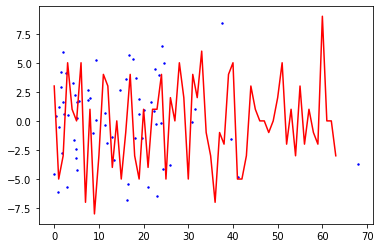

Epoch: 4400 Accurracy real: 0.09375 Accurracy fake: 0.71875
Epoch: 4401 Accurracy real: 0.125 Accurracy fake: 0.75
Epoch: 4402 Accurracy real: 0.125 Accurracy fake: 0.671875
Epoch: 4403 Accurracy real: 0.171875 Accurracy fake: 0.46875
Epoch: 4404 Accurracy real: 0.515625 Accurracy fake: 0.390625
Epoch: 4405 Accurracy real: 0.625 Accurracy fake: 0.3125
Epoch: 4406 Accurracy real: 0.671875 Accurracy fake: 0.296875
Epoch: 4407 Accurracy real: 0.6875 Accurracy fake: 0.34375
Epoch: 4408 Accurracy real: 0.796875 Accurracy fake: 0.34375
Epoch: 4409 Accurracy real: 0.765625 Accurracy fake: 0.203125
Epoch: 4410 Accurracy real: 0.765625 Accurracy fake: 0.296875
Epoch: 4411 Accurracy real: 0.90625 Accurracy fake: 0.265625
Epoch: 4412 Accurracy real: 0.921875 Accurracy fake: 0.203125
Epoch: 4413 Accurracy real: 0.703125 Accurracy fake: 0.28125
Epoch: 4414 Accurracy real: 0.578125 Accurracy fake: 0.390625
Epoch: 4415 Accurracy real: 0.671875 Accurracy fake: 0.421875
Epoch: 4416 Accurracy real: 0.54

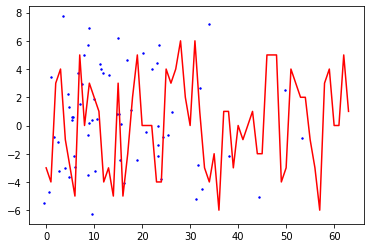

Epoch: 4450 Accurracy real: 0.328125 Accurracy fake: 0.5
Epoch: 4451 Accurracy real: 0.375 Accurracy fake: 0.546875
Epoch: 4452 Accurracy real: 0.453125 Accurracy fake: 0.53125
Epoch: 4453 Accurracy real: 0.390625 Accurracy fake: 0.53125
Epoch: 4454 Accurracy real: 0.34375 Accurracy fake: 0.484375
Epoch: 4455 Accurracy real: 0.203125 Accurracy fake: 0.640625
Epoch: 4456 Accurracy real: 0.09375 Accurracy fake: 0.703125
Epoch: 4457 Accurracy real: 0.21875 Accurracy fake: 0.6875
Epoch: 4458 Accurracy real: 0.0625 Accurracy fake: 0.765625
Epoch: 4459 Accurracy real: 0.109375 Accurracy fake: 0.78125
Epoch: 4460 Accurracy real: 0.125 Accurracy fake: 0.765625
Epoch: 4461 Accurracy real: 0.203125 Accurracy fake: 0.6875
Epoch: 4462 Accurracy real: 0.28125 Accurracy fake: 0.75
Epoch: 4463 Accurracy real: 0.609375 Accurracy fake: 0.453125
Epoch: 4464 Accurracy real: 0.53125 Accurracy fake: 0.359375
Epoch: 4465 Accurracy real: 0.453125 Accurracy fake: 0.515625
Epoch: 4466 Accurracy real: 0.390625 

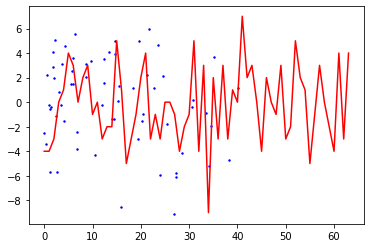

Epoch: 4500 Accurracy real: 0.234375 Accurracy fake: 0.75
Epoch: 4501 Accurracy real: 0.328125 Accurracy fake: 0.71875
Epoch: 4502 Accurracy real: 0.359375 Accurracy fake: 0.640625
Epoch: 4503 Accurracy real: 0.390625 Accurracy fake: 0.625
Epoch: 4504 Accurracy real: 0.53125 Accurracy fake: 0.453125
Epoch: 4505 Accurracy real: 0.40625 Accurracy fake: 0.46875
Epoch: 4506 Accurracy real: 0.3125 Accurracy fake: 0.46875
Epoch: 4507 Accurracy real: 0.328125 Accurracy fake: 0.609375
Epoch: 4508 Accurracy real: 0.265625 Accurracy fake: 0.609375
Epoch: 4509 Accurracy real: 0.296875 Accurracy fake: 0.578125
Epoch: 4510 Accurracy real: 0.1875 Accurracy fake: 0.671875
Epoch: 4511 Accurracy real: 0.171875 Accurracy fake: 0.53125
Epoch: 4512 Accurracy real: 0.359375 Accurracy fake: 0.46875
Epoch: 4513 Accurracy real: 0.328125 Accurracy fake: 0.59375
Epoch: 4514 Accurracy real: 0.296875 Accurracy fake: 0.484375
Epoch: 4515 Accurracy real: 0.296875 Accurracy fake: 0.515625
Epoch: 4516 Accurracy real:

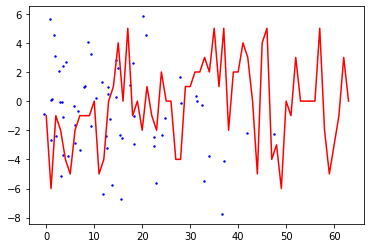

Epoch: 4550 Accurracy real: 0.265625 Accurracy fake: 0.5625
Epoch: 4551 Accurracy real: 0.4375 Accurracy fake: 0.5625
Epoch: 4552 Accurracy real: 0.328125 Accurracy fake: 0.484375
Epoch: 4553 Accurracy real: 0.421875 Accurracy fake: 0.53125
Epoch: 4554 Accurracy real: 0.296875 Accurracy fake: 0.4375
Epoch: 4555 Accurracy real: 0.46875 Accurracy fake: 0.390625
Epoch: 4556 Accurracy real: 0.40625 Accurracy fake: 0.625
Epoch: 4557 Accurracy real: 0.53125 Accurracy fake: 0.4375
Epoch: 4558 Accurracy real: 0.140625 Accurracy fake: 0.578125
Epoch: 4559 Accurracy real: 0.078125 Accurracy fake: 0.828125
Epoch: 4560 Accurracy real: 0.125 Accurracy fake: 0.84375
Epoch: 4561 Accurracy real: 0.03125 Accurracy fake: 0.8125
Epoch: 4562 Accurracy real: 0.609375 Accurracy fake: 0.84375
Epoch: 4563 Accurracy real: 0.0625 Accurracy fake: 0.796875
Epoch: 4564 Accurracy real: 0.078125 Accurracy fake: 0.734375
Epoch: 4565 Accurracy real: 0.046875 Accurracy fake: 0.84375
Epoch: 4566 Accurracy real: 0.109375

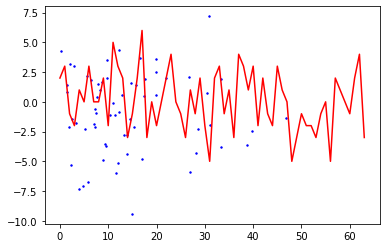

Epoch: 4600 Accurracy real: 0.21875 Accurracy fake: 0.59375
Epoch: 4601 Accurracy real: 0.21875 Accurracy fake: 0.609375
Epoch: 4602 Accurracy real: 0.109375 Accurracy fake: 0.703125
Epoch: 4603 Accurracy real: 0.171875 Accurracy fake: 0.78125
Epoch: 4604 Accurracy real: 0.125 Accurracy fake: 0.703125
Epoch: 4605 Accurracy real: 0.1875 Accurracy fake: 0.703125
Epoch: 4606 Accurracy real: 0.078125 Accurracy fake: 0.625
Epoch: 4607 Accurracy real: 0.109375 Accurracy fake: 0.765625
Epoch: 4608 Accurracy real: 0.265625 Accurracy fake: 0.671875
Epoch: 4609 Accurracy real: 0.265625 Accurracy fake: 0.5
Epoch: 4610 Accurracy real: 0.515625 Accurracy fake: 0.40625
Epoch: 4611 Accurracy real: 0.671875 Accurracy fake: 0.265625
Epoch: 4612 Accurracy real: 0.890625 Accurracy fake: 0.203125
Epoch: 4613 Accurracy real: 0.890625 Accurracy fake: 0.328125
Epoch: 4614 Accurracy real: 0.90625 Accurracy fake: 0.1875
Epoch: 4615 Accurracy real: 0.890625 Accurracy fake: 0.171875
Epoch: 4616 Accurracy real: 0

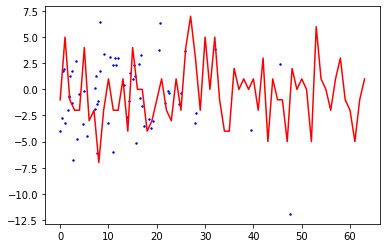

Epoch: 4650 Accurracy real: 0.09375 Accurracy fake: 0.578125
Epoch: 4651 Accurracy real: 0.875 Accurracy fake: 0.359375
Epoch: 4652 Accurracy real: 0.859375 Accurracy fake: 0.265625
Epoch: 4653 Accurracy real: 0.890625 Accurracy fake: 0.234375
Epoch: 4654 Accurracy real: 0.90625 Accurracy fake: 0.171875
Epoch: 4655 Accurracy real: 0.90625 Accurracy fake: 0.25
Epoch: 4656 Accurracy real: 0.9375 Accurracy fake: 0.21875
Epoch: 4657 Accurracy real: 0.40625 Accurracy fake: 0.453125
Epoch: 4658 Accurracy real: 0.125 Accurracy fake: 0.671875
Epoch: 4659 Accurracy real: 0.015625 Accurracy fake: 0.71875
Epoch: 4660 Accurracy real: 0.09375 Accurracy fake: 0.765625
Epoch: 4661 Accurracy real: 0.09375 Accurracy fake: 0.78125
Epoch: 4662 Accurracy real: 0.09375 Accurracy fake: 0.828125
Epoch: 4663 Accurracy real: 0.078125 Accurracy fake: 0.75
Epoch: 4664 Accurracy real: 0.09375 Accurracy fake: 0.71875
Epoch: 4665 Accurracy real: 0.25 Accurracy fake: 0.765625
Epoch: 4666 Accurracy real: 0.1875 Accur

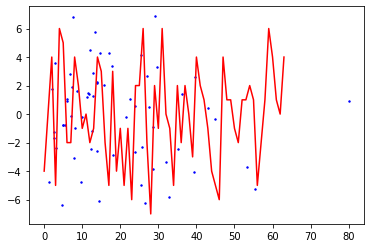

Epoch: 4700 Accurracy real: 0.078125 Accurracy fake: 0.703125
Epoch: 4701 Accurracy real: 0.109375 Accurracy fake: 0.609375
Epoch: 4702 Accurracy real: 0.109375 Accurracy fake: 0.71875
Epoch: 4703 Accurracy real: 0.1875 Accurracy fake: 0.78125
Epoch: 4704 Accurracy real: 0.09375 Accurracy fake: 0.8125
Epoch: 4705 Accurracy real: 0.078125 Accurracy fake: 0.78125
Epoch: 4706 Accurracy real: 0.109375 Accurracy fake: 0.84375
Epoch: 4707 Accurracy real: 0.0625 Accurracy fake: 0.8125
Epoch: 4708 Accurracy real: 0.0625 Accurracy fake: 0.890625
Epoch: 4709 Accurracy real: 0.03125 Accurracy fake: 0.8125
Epoch: 4710 Accurracy real: 0.0625 Accurracy fake: 0.765625
Epoch: 4711 Accurracy real: 0.125 Accurracy fake: 0.8125
Epoch: 4712 Accurracy real: 0.046875 Accurracy fake: 0.765625
Epoch: 4713 Accurracy real: 0.125 Accurracy fake: 0.765625
Epoch: 4714 Accurracy real: 0.0625 Accurracy fake: 0.796875
Epoch: 4715 Accurracy real: 0.09375 Accurracy fake: 0.640625
Epoch: 4716 Accurracy real: 0.140625 Ac

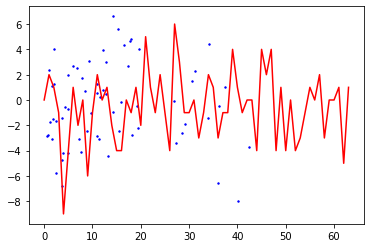

Epoch: 4750 Accurracy real: 0.65625 Accurracy fake: 0.5
Epoch: 4751 Accurracy real: 0.578125 Accurracy fake: 0.453125
Epoch: 4752 Accurracy real: 0.46875 Accurracy fake: 0.453125
Epoch: 4753 Accurracy real: 0.53125 Accurracy fake: 0.359375
Epoch: 4754 Accurracy real: 0.515625 Accurracy fake: 0.5
Epoch: 4755 Accurracy real: 0.484375 Accurracy fake: 0.453125
Epoch: 4756 Accurracy real: 0.375 Accurracy fake: 0.53125
Epoch: 4757 Accurracy real: 0.28125 Accurracy fake: 0.515625
Epoch: 4758 Accurracy real: 0.15625 Accurracy fake: 0.578125
Epoch: 4759 Accurracy real: 0.296875 Accurracy fake: 0.671875
Epoch: 4760 Accurracy real: 0.21875 Accurracy fake: 0.5625
Epoch: 4761 Accurracy real: 0.25 Accurracy fake: 0.53125
Epoch: 4762 Accurracy real: 0.203125 Accurracy fake: 0.515625
Epoch: 4763 Accurracy real: 0.234375 Accurracy fake: 0.484375
Epoch: 4764 Accurracy real: 0.234375 Accurracy fake: 0.59375
Epoch: 4765 Accurracy real: 0.359375 Accurracy fake: 0.59375
Epoch: 4766 Accurracy real: 0.28125 A

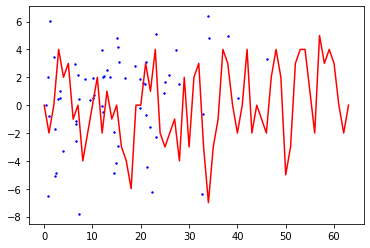

Epoch: 4800 Accurracy real: 0.09375 Accurracy fake: 0.734375
Epoch: 4801 Accurracy real: 0.09375 Accurracy fake: 0.875
Epoch: 4802 Accurracy real: 0.125 Accurracy fake: 0.6875
Epoch: 4803 Accurracy real: 0.15625 Accurracy fake: 0.78125
Epoch: 4804 Accurracy real: 0.15625 Accurracy fake: 0.734375
Epoch: 4805 Accurracy real: 0.109375 Accurracy fake: 0.734375
Epoch: 4806 Accurracy real: 0.046875 Accurracy fake: 0.8125
Epoch: 4807 Accurracy real: 0.1875 Accurracy fake: 0.8125
Epoch: 4808 Accurracy real: 0.40625 Accurracy fake: 0.546875
Epoch: 4809 Accurracy real: 0.90625 Accurracy fake: 0.203125
Epoch: 4810 Accurracy real: 0.84375 Accurracy fake: 0.25
Epoch: 4811 Accurracy real: 0.734375 Accurracy fake: 0.109375
Epoch: 4812 Accurracy real: 0.921875 Accurracy fake: 0.203125
Epoch: 4813 Accurracy real: 0.875 Accurracy fake: 0.234375
Epoch: 4814 Accurracy real: 0.890625 Accurracy fake: 0.265625
Epoch: 4815 Accurracy real: 0.90625 Accurracy fake: 0.140625
Epoch: 4816 Accurracy real: 0.90625 Ac

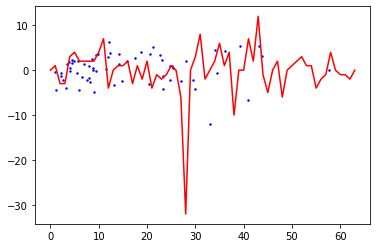

Epoch: 4850 Accurracy real: 0.1875 Accurracy fake: 0.671875
Epoch: 4851 Accurracy real: 0.3125 Accurracy fake: 0.765625
Epoch: 4852 Accurracy real: 0.15625 Accurracy fake: 0.71875
Epoch: 4853 Accurracy real: 0.171875 Accurracy fake: 0.734375
Epoch: 4854 Accurracy real: 0.234375 Accurracy fake: 0.703125
Epoch: 4855 Accurracy real: 0.34375 Accurracy fake: 0.5625
Epoch: 4856 Accurracy real: 0.390625 Accurracy fake: 0.609375
Epoch: 4857 Accurracy real: 0.53125 Accurracy fake: 0.515625
Epoch: 4858 Accurracy real: 0.484375 Accurracy fake: 0.5625
Epoch: 4859 Accurracy real: 0.609375 Accurracy fake: 0.546875
Epoch: 4860 Accurracy real: 0.671875 Accurracy fake: 0.421875
Epoch: 4861 Accurracy real: 0.765625 Accurracy fake: 0.53125
Epoch: 4862 Accurracy real: 0.640625 Accurracy fake: 0.421875
Epoch: 4863 Accurracy real: 0.515625 Accurracy fake: 0.390625
Epoch: 4864 Accurracy real: 0.5 Accurracy fake: 0.421875
Epoch: 4865 Accurracy real: 0.65625 Accurracy fake: 0.625
Epoch: 4866 Accurracy real: 0.

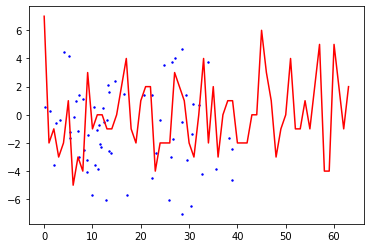

Epoch: 4900 Accurracy real: 0.75 Accurracy fake: 0.390625
Epoch: 4901 Accurracy real: 0.90625 Accurracy fake: 0.328125
Epoch: 4902 Accurracy real: 0.890625 Accurracy fake: 0.25
Epoch: 4903 Accurracy real: 0.859375 Accurracy fake: 0.21875
Epoch: 4904 Accurracy real: 0.859375 Accurracy fake: 0.390625
Epoch: 4905 Accurracy real: 0.84375 Accurracy fake: 0.265625
Epoch: 4906 Accurracy real: 0.875 Accurracy fake: 0.296875
Epoch: 4907 Accurracy real: 0.84375 Accurracy fake: 0.296875
Epoch: 4908 Accurracy real: 0.859375 Accurracy fake: 0.46875
Epoch: 4909 Accurracy real: 0.40625 Accurracy fake: 0.359375
Epoch: 4910 Accurracy real: 0.125 Accurracy fake: 0.625
Epoch: 4911 Accurracy real: 0.0625 Accurracy fake: 0.640625
Epoch: 4912 Accurracy real: 0.125 Accurracy fake: 0.5625
Epoch: 4913 Accurracy real: 0.1875 Accurracy fake: 0.515625
Epoch: 4914 Accurracy real: 0.140625 Accurracy fake: 0.6875
Epoch: 4915 Accurracy real: 0.125 Accurracy fake: 0.765625
Epoch: 4916 Accurracy real: 0.125 Accurracy f

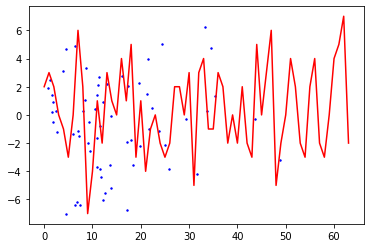

Epoch: 4950 Accurracy real: 0.3125 Accurracy fake: 0.5625
Epoch: 4951 Accurracy real: 0.5625 Accurracy fake: 0.5
Epoch: 4952 Accurracy real: 0.515625 Accurracy fake: 0.484375
Epoch: 4953 Accurracy real: 0.65625 Accurracy fake: 0.359375
Epoch: 4954 Accurracy real: 0.84375 Accurracy fake: 0.359375
Epoch: 4955 Accurracy real: 0.71875 Accurracy fake: 0.265625
Epoch: 4956 Accurracy real: 0.828125 Accurracy fake: 0.28125
Epoch: 4957 Accurracy real: 0.78125 Accurracy fake: 0.34375
Epoch: 4958 Accurracy real: 0.53125 Accurracy fake: 0.421875
Epoch: 4959 Accurracy real: 0.1875 Accurracy fake: 0.71875
Epoch: 4960 Accurracy real: 0.140625 Accurracy fake: 0.859375
Epoch: 4961 Accurracy real: 0.171875 Accurracy fake: 0.8125
Epoch: 4962 Accurracy real: 0.0625 Accurracy fake: 0.8125
Epoch: 4963 Accurracy real: 0.09375 Accurracy fake: 0.796875
Epoch: 4964 Accurracy real: 0.4375 Accurracy fake: 0.6875
Epoch: 4965 Accurracy real: 0.21875 Accurracy fake: 0.671875
Epoch: 4966 Accurracy real: 0.1875 Accurr

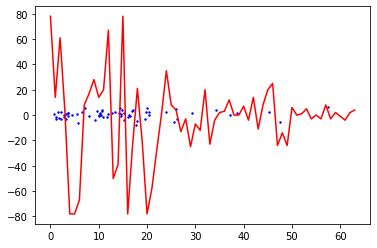

Epoch: 5000 Accurracy real: 0.84375 Accurracy fake: 0.453125
Epoch: 5001 Accurracy real: 0.640625 Accurracy fake: 0.484375
Epoch: 5002 Accurracy real: 0.359375 Accurracy fake: 0.5625
Epoch: 5003 Accurracy real: 0.3125 Accurracy fake: 0.703125
Epoch: 5004 Accurracy real: 0.34375 Accurracy fake: 0.671875
Epoch: 5005 Accurracy real: 0.171875 Accurracy fake: 0.765625
Epoch: 5006 Accurracy real: 0.203125 Accurracy fake: 0.71875
Epoch: 5007 Accurracy real: 0.375 Accurracy fake: 0.703125
Epoch: 5008 Accurracy real: 0.234375 Accurracy fake: 0.65625
Epoch: 5009 Accurracy real: 0.203125 Accurracy fake: 0.65625
Epoch: 5010 Accurracy real: 0.25 Accurracy fake: 0.71875
Epoch: 5011 Accurracy real: 0.15625 Accurracy fake: 0.625
Epoch: 5012 Accurracy real: 0.28125 Accurracy fake: 0.71875
Epoch: 5013 Accurracy real: 0.265625 Accurracy fake: 0.640625
Epoch: 5014 Accurracy real: 0.3125 Accurracy fake: 0.640625
Epoch: 5015 Accurracy real: 0.34375 Accurracy fake: 0.640625
Epoch: 5016 Accurracy real: 0.4375

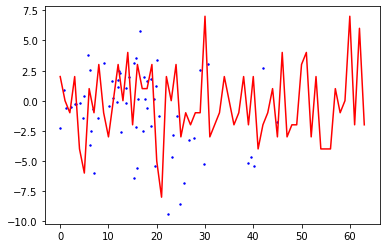

Epoch: 5050 Accurracy real: 0.0625 Accurracy fake: 0.875
Epoch: 5051 Accurracy real: 0.0625 Accurracy fake: 0.90625
Epoch: 5052 Accurracy real: 0.0625 Accurracy fake: 0.796875
Epoch: 5053 Accurracy real: 0.109375 Accurracy fake: 0.78125
Epoch: 5054 Accurracy real: 0.1875 Accurracy fake: 0.6875
Epoch: 5055 Accurracy real: 0.1875 Accurracy fake: 0.734375
Epoch: 5056 Accurracy real: 0.53125 Accurracy fake: 0.65625
Epoch: 5057 Accurracy real: 0.265625 Accurracy fake: 0.671875
Epoch: 5058 Accurracy real: 0.421875 Accurracy fake: 0.59375
Epoch: 5059 Accurracy real: 0.359375 Accurracy fake: 0.53125
Epoch: 5060 Accurracy real: 0.265625 Accurracy fake: 0.65625
Epoch: 5061 Accurracy real: 0.171875 Accurracy fake: 0.625
Epoch: 5062 Accurracy real: 0.15625 Accurracy fake: 0.78125
Epoch: 5063 Accurracy real: 0.203125 Accurracy fake: 0.609375
Epoch: 5064 Accurracy real: 0.15625 Accurracy fake: 0.828125
Epoch: 5065 Accurracy real: 0.0625 Accurracy fake: 0.9375
Epoch: 5066 Accurracy real: 0.078125 Acc

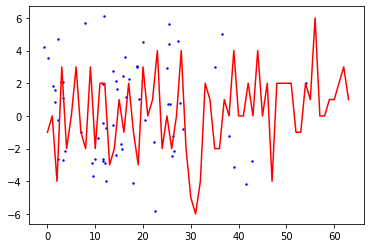

Epoch: 5100 Accurracy real: 0.15625 Accurracy fake: 0.6875
Epoch: 5101 Accurracy real: 0.25 Accurracy fake: 0.578125
Epoch: 5102 Accurracy real: 0.59375 Accurracy fake: 0.546875
Epoch: 5103 Accurracy real: 0.5 Accurracy fake: 0.390625
Epoch: 5104 Accurracy real: 0.515625 Accurracy fake: 0.390625
Epoch: 5105 Accurracy real: 0.59375 Accurracy fake: 0.4375
Epoch: 5106 Accurracy real: 0.703125 Accurracy fake: 0.34375
Epoch: 5107 Accurracy real: 0.65625 Accurracy fake: 0.3125
Epoch: 5108 Accurracy real: 0.671875 Accurracy fake: 0.359375
Epoch: 5109 Accurracy real: 0.640625 Accurracy fake: 0.375
Epoch: 5110 Accurracy real: 0.734375 Accurracy fake: 0.25
Epoch: 5111 Accurracy real: 0.828125 Accurracy fake: 0.265625
Epoch: 5112 Accurracy real: 0.796875 Accurracy fake: 0.265625
Epoch: 5113 Accurracy real: 0.859375 Accurracy fake: 0.21875
Epoch: 5114 Accurracy real: 0.78125 Accurracy fake: 0.390625
Epoch: 5115 Accurracy real: 0.78125 Accurracy fake: 0.34375
Epoch: 5116 Accurracy real: 0.71875 Acc

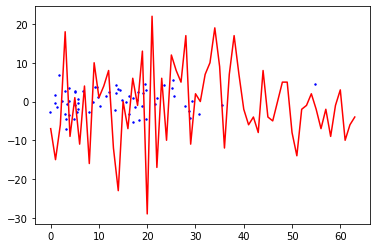

Epoch: 5150 Accurracy real: 0.890625 Accurracy fake: 0.140625
Epoch: 5151 Accurracy real: 0.890625 Accurracy fake: 0.25
Epoch: 5152 Accurracy real: 0.859375 Accurracy fake: 0.34375
Epoch: 5153 Accurracy real: 0.890625 Accurracy fake: 0.15625
Epoch: 5154 Accurracy real: 0.859375 Accurracy fake: 0.21875
Epoch: 5155 Accurracy real: 0.9375 Accurracy fake: 0.234375
Epoch: 5156 Accurracy real: 0.875 Accurracy fake: 0.171875
Epoch: 5157 Accurracy real: 0.828125 Accurracy fake: 0.25
Epoch: 5158 Accurracy real: 0.9375 Accurracy fake: 0.28125
Epoch: 5159 Accurracy real: 0.890625 Accurracy fake: 0.1875
Epoch: 5160 Accurracy real: 0.859375 Accurracy fake: 0.203125
Epoch: 5161 Accurracy real: 0.921875 Accurracy fake: 0.171875
Epoch: 5162 Accurracy real: 0.921875 Accurracy fake: 0.1875
Epoch: 5163 Accurracy real: 0.109375 Accurracy fake: 0.75
Epoch: 5164 Accurracy real: 0.078125 Accurracy fake: 0.71875
Epoch: 5165 Accurracy real: 0.078125 Accurracy fake: 0.84375
Epoch: 5166 Accurracy real: 0.09375 A

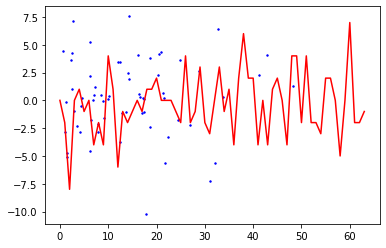

Epoch: 5200 Accurracy real: 0.046875 Accurracy fake: 0.859375
Epoch: 5201 Accurracy real: 0.078125 Accurracy fake: 0.875
Epoch: 5202 Accurracy real: 0.0625 Accurracy fake: 0.890625
Epoch: 5203 Accurracy real: 0.109375 Accurracy fake: 0.828125
Epoch: 5204 Accurracy real: 0.078125 Accurracy fake: 0.8125
Epoch: 5205 Accurracy real: 0.15625 Accurracy fake: 0.578125
Epoch: 5206 Accurracy real: 0.9375 Accurracy fake: 0.1875
Epoch: 5207 Accurracy real: 0.953125 Accurracy fake: 0.171875
Epoch: 5208 Accurracy real: 0.921875 Accurracy fake: 0.078125
Epoch: 5209 Accurracy real: 0.90625 Accurracy fake: 0.28125
Epoch: 5210 Accurracy real: 0.921875 Accurracy fake: 0.1875
Epoch: 5211 Accurracy real: 0.859375 Accurracy fake: 0.15625
Epoch: 5212 Accurracy real: 0.921875 Accurracy fake: 0.171875
Epoch: 5213 Accurracy real: 0.828125 Accurracy fake: 0.25
Epoch: 5214 Accurracy real: 0.765625 Accurracy fake: 0.34375
Epoch: 5215 Accurracy real: 0.078125 Accurracy fake: 0.796875
Epoch: 5216 Accurracy real: 0.

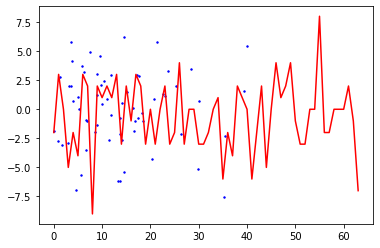

Epoch: 5250 Accurracy real: 0.453125 Accurracy fake: 0.484375
Epoch: 5251 Accurracy real: 0.734375 Accurracy fake: 0.4375
Epoch: 5252 Accurracy real: 0.796875 Accurracy fake: 0.3125
Epoch: 5253 Accurracy real: 0.890625 Accurracy fake: 0.390625
Epoch: 5254 Accurracy real: 0.859375 Accurracy fake: 0.25
Epoch: 5255 Accurracy real: 0.859375 Accurracy fake: 0.28125
Epoch: 5256 Accurracy real: 0.8125 Accurracy fake: 0.296875
Epoch: 5257 Accurracy real: 0.828125 Accurracy fake: 0.25
Epoch: 5258 Accurracy real: 0.484375 Accurracy fake: 0.46875
Epoch: 5259 Accurracy real: 0.625 Accurracy fake: 0.859375
Epoch: 5260 Accurracy real: 0.046875 Accurracy fake: 0.828125
Epoch: 5261 Accurracy real: 0.0625 Accurracy fake: 0.8125
Epoch: 5262 Accurracy real: 0.65625 Accurracy fake: 0.484375
Epoch: 5263 Accurracy real: 0.78125 Accurracy fake: 0.4375
Epoch: 5264 Accurracy real: 0.265625 Accurracy fake: 0.515625
Epoch: 5265 Accurracy real: 0.28125 Accurracy fake: 0.625
Epoch: 5266 Accurracy real: 0.265625 Ac

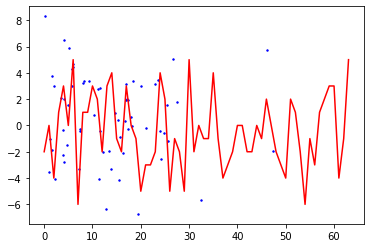

Epoch: 5300 Accurracy real: 0.375 Accurracy fake: 0.484375
Epoch: 5301 Accurracy real: 0.71875 Accurracy fake: 0.359375
Epoch: 5302 Accurracy real: 0.8125 Accurracy fake: 0.34375
Epoch: 5303 Accurracy real: 0.84375 Accurracy fake: 0.34375
Epoch: 5304 Accurracy real: 0.8125 Accurracy fake: 0.28125
Epoch: 5305 Accurracy real: 0.921875 Accurracy fake: 0.296875
Epoch: 5306 Accurracy real: 0.859375 Accurracy fake: 0.4375
Epoch: 5307 Accurracy real: 0.828125 Accurracy fake: 0.3125
Epoch: 5308 Accurracy real: 0.828125 Accurracy fake: 0.296875
Epoch: 5309 Accurracy real: 0.796875 Accurracy fake: 0.453125
Epoch: 5310 Accurracy real: 0.8125 Accurracy fake: 0.328125
Epoch: 5311 Accurracy real: 0.8125 Accurracy fake: 0.328125
Epoch: 5312 Accurracy real: 0.78125 Accurracy fake: 0.28125
Epoch: 5313 Accurracy real: 0.8125 Accurracy fake: 0.421875
Epoch: 5314 Accurracy real: 0.78125 Accurracy fake: 0.5
Epoch: 5315 Accurracy real: 0.59375 Accurracy fake: 0.578125
Epoch: 5316 Accurracy real: 0.40625 Acc

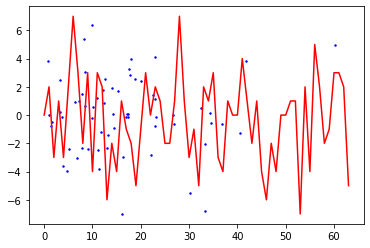

Epoch: 5350 Accurracy real: 0.140625 Accurracy fake: 0.8125
Epoch: 5351 Accurracy real: 0.0625 Accurracy fake: 0.78125
Epoch: 5352 Accurracy real: 0.46875 Accurracy fake: 0.640625
Epoch: 5353 Accurracy real: 0.515625 Accurracy fake: 0.59375
Epoch: 5354 Accurracy real: 0.40625 Accurracy fake: 0.5625
Epoch: 5355 Accurracy real: 0.609375 Accurracy fake: 0.484375
Epoch: 5356 Accurracy real: 0.703125 Accurracy fake: 0.40625
Epoch: 5357 Accurracy real: 0.765625 Accurracy fake: 0.4375
Epoch: 5358 Accurracy real: 0.78125 Accurracy fake: 0.234375
Epoch: 5359 Accurracy real: 0.828125 Accurracy fake: 0.53125
Epoch: 5360 Accurracy real: 0.625 Accurracy fake: 0.359375
Epoch: 5361 Accurracy real: 0.65625 Accurracy fake: 0.3125
Epoch: 5362 Accurracy real: 0.921875 Accurracy fake: 0.21875
Epoch: 5363 Accurracy real: 0.859375 Accurracy fake: 0.15625
Epoch: 5364 Accurracy real: 0.90625 Accurracy fake: 0.15625
Epoch: 5365 Accurracy real: 0.859375 Accurracy fake: 0.1875
Epoch: 5366 Accurracy real: 0.89062

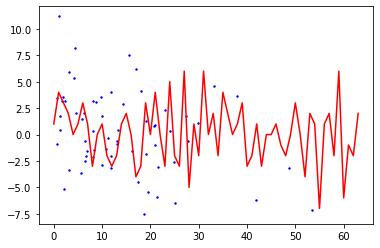

Epoch: 5400 Accurracy real: 0.09375 Accurracy fake: 0.84375
Epoch: 5401 Accurracy real: 0.03125 Accurracy fake: 0.84375
Epoch: 5402 Accurracy real: 0.078125 Accurracy fake: 0.875
Epoch: 5403 Accurracy real: 0.0625 Accurracy fake: 0.828125
Epoch: 5404 Accurracy real: 0.03125 Accurracy fake: 0.875
Epoch: 5405 Accurracy real: 0.015625 Accurracy fake: 0.921875
Epoch: 5406 Accurracy real: 0.0625 Accurracy fake: 0.953125
Epoch: 5407 Accurracy real: 0.5625 Accurracy fake: 0.625
Epoch: 5408 Accurracy real: 0.765625 Accurracy fake: 0.3125
Epoch: 5409 Accurracy real: 0.875 Accurracy fake: 0.203125
Epoch: 5410 Accurracy real: 0.796875 Accurracy fake: 0.265625
Epoch: 5411 Accurracy real: 0.796875 Accurracy fake: 0.375
Epoch: 5412 Accurracy real: 0.828125 Accurracy fake: 0.3125
Epoch: 5413 Accurracy real: 0.9375 Accurracy fake: 0.34375
Epoch: 5414 Accurracy real: 0.8125 Accurracy fake: 0.328125
Epoch: 5415 Accurracy real: 0.796875 Accurracy fake: 0.359375
Epoch: 5416 Accurracy real: 0.3125 Accurrac

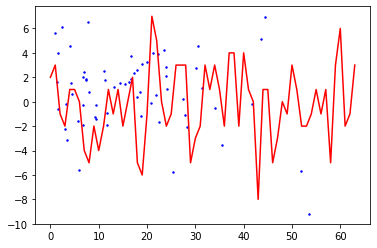

Epoch: 5450 Accurracy real: 0.53125 Accurracy fake: 0.515625
Epoch: 5451 Accurracy real: 0.453125 Accurracy fake: 0.5
Epoch: 5452 Accurracy real: 0.390625 Accurracy fake: 0.671875
Epoch: 5453 Accurracy real: 0.09375 Accurracy fake: 0.796875
Epoch: 5454 Accurracy real: 0.09375 Accurracy fake: 0.8125
Epoch: 5455 Accurracy real: 0.03125 Accurracy fake: 0.90625
Epoch: 5456 Accurracy real: 0.671875 Accurracy fake: 0.953125
Epoch: 5457 Accurracy real: 0.109375 Accurracy fake: 0.90625
Epoch: 5458 Accurracy real: 0.03125 Accurracy fake: 0.890625
Epoch: 5459 Accurracy real: 0.046875 Accurracy fake: 0.859375
Epoch: 5460 Accurracy real: 0.046875 Accurracy fake: 0.84375
Epoch: 5461 Accurracy real: 0.03125 Accurracy fake: 0.90625
Epoch: 5462 Accurracy real: 0.0625 Accurracy fake: 0.875
Epoch: 5463 Accurracy real: 0.078125 Accurracy fake: 0.90625
Epoch: 5464 Accurracy real: 0.078125 Accurracy fake: 0.890625
Epoch: 5465 Accurracy real: 0.109375 Accurracy fake: 0.828125
Epoch: 5466 Accurracy real: 0.1

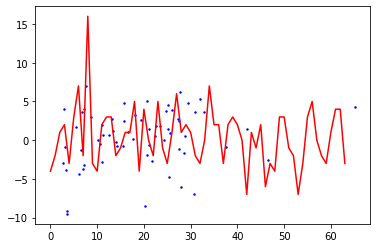

Epoch: 5500 Accurracy real: 0.078125 Accurracy fake: 0.84375
Epoch: 5501 Accurracy real: 0.625 Accurracy fake: 0.8125
Epoch: 5502 Accurracy real: 0.109375 Accurracy fake: 0.796875
Epoch: 5503 Accurracy real: 0.234375 Accurracy fake: 0.71875
Epoch: 5504 Accurracy real: 0.28125 Accurracy fake: 0.609375
Epoch: 5505 Accurracy real: 0.375 Accurracy fake: 0.4375
Epoch: 5506 Accurracy real: 0.375 Accurracy fake: 0.546875
Epoch: 5507 Accurracy real: 0.640625 Accurracy fake: 0.40625
Epoch: 5508 Accurracy real: 0.546875 Accurracy fake: 0.375
Epoch: 5509 Accurracy real: 0.359375 Accurracy fake: 0.609375
Epoch: 5510 Accurracy real: 0.25 Accurracy fake: 0.640625
Epoch: 5511 Accurracy real: 0.1875 Accurracy fake: 0.578125
Epoch: 5512 Accurracy real: 0.15625 Accurracy fake: 0.625
Epoch: 5513 Accurracy real: 0.09375 Accurracy fake: 0.78125
Epoch: 5514 Accurracy real: 0.046875 Accurracy fake: 0.828125
Epoch: 5515 Accurracy real: 0.0625 Accurracy fake: 0.78125
Epoch: 5516 Accurracy real: 0.125 Accurracy

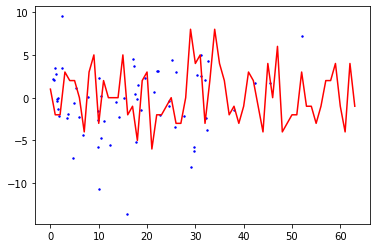

Epoch: 5550 Accurracy real: 0.5 Accurracy fake: 0.34375
Epoch: 5551 Accurracy real: 0.484375 Accurracy fake: 0.375
Epoch: 5552 Accurracy real: 0.5 Accurracy fake: 0.4375
Epoch: 5553 Accurracy real: 0.390625 Accurracy fake: 0.484375
Epoch: 5554 Accurracy real: 0.21875 Accurracy fake: 0.46875
Epoch: 5555 Accurracy real: 0.140625 Accurracy fake: 0.625
Epoch: 5556 Accurracy real: 0.140625 Accurracy fake: 0.640625
Epoch: 5557 Accurracy real: 0.4375 Accurracy fake: 0.6875
Epoch: 5558 Accurracy real: 0.234375 Accurracy fake: 0.53125
Epoch: 5559 Accurracy real: 0.3125 Accurracy fake: 0.359375
Epoch: 5560 Accurracy real: 0.34375 Accurracy fake: 0.4375
Epoch: 5561 Accurracy real: 0.703125 Accurracy fake: 0.453125
Epoch: 5562 Accurracy real: 0.765625 Accurracy fake: 0.359375
Epoch: 5563 Accurracy real: 0.609375 Accurracy fake: 0.328125
Epoch: 5564 Accurracy real: 0.703125 Accurracy fake: 0.109375
Epoch: 5565 Accurracy real: 0.640625 Accurracy fake: 0.21875
Epoch: 5566 Accurracy real: 0.828125 Acc

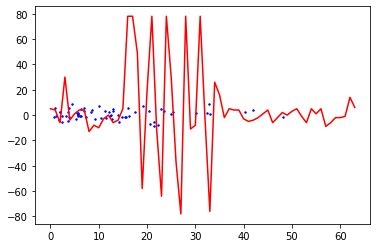

Epoch: 5600 Accurracy real: 0.8125 Accurracy fake: 0.328125
Epoch: 5601 Accurracy real: 0.90625 Accurracy fake: 0.28125
Epoch: 5602 Accurracy real: 0.890625 Accurracy fake: 0.28125
Epoch: 5603 Accurracy real: 0.859375 Accurracy fake: 0.28125
Epoch: 5604 Accurracy real: 0.484375 Accurracy fake: 0.203125
Epoch: 5605 Accurracy real: 0.875 Accurracy fake: 0.234375
Epoch: 5606 Accurracy real: 0.84375 Accurracy fake: 0.296875
Epoch: 5607 Accurracy real: 0.859375 Accurracy fake: 0.1875
Epoch: 5608 Accurracy real: 0.875 Accurracy fake: 0.265625
Epoch: 5609 Accurracy real: 0.875 Accurracy fake: 0.328125
Epoch: 5610 Accurracy real: 0.890625 Accurracy fake: 0.296875
Epoch: 5611 Accurracy real: 0.875 Accurracy fake: 0.359375
Epoch: 5612 Accurracy real: 0.84375 Accurracy fake: 0.28125
Epoch: 5613 Accurracy real: 0.84375 Accurracy fake: 0.375
Epoch: 5614 Accurracy real: 0.84375 Accurracy fake: 0.453125
Epoch: 5615 Accurracy real: 0.75 Accurracy fake: 0.515625
Epoch: 5616 Accurracy real: 0.65625 Accu

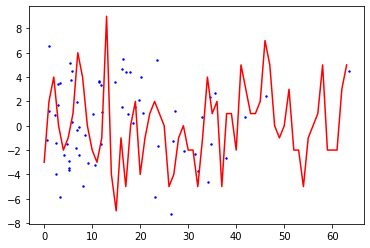

Epoch: 5650 Accurracy real: 0.1875 Accurracy fake: 0.6875
Epoch: 5651 Accurracy real: 0.296875 Accurracy fake: 0.703125
Epoch: 5652 Accurracy real: 0.25 Accurracy fake: 0.609375
Epoch: 5653 Accurracy real: 0.421875 Accurracy fake: 0.578125
Epoch: 5654 Accurracy real: 0.1875 Accurracy fake: 0.625
Epoch: 5655 Accurracy real: 0.0625 Accurracy fake: 0.796875
Epoch: 5656 Accurracy real: 0.0625 Accurracy fake: 0.796875
Epoch: 5657 Accurracy real: 0.09375 Accurracy fake: 0.796875
Epoch: 5658 Accurracy real: 0.046875 Accurracy fake: 0.828125
Epoch: 5659 Accurracy real: 0.0625 Accurracy fake: 0.921875
Epoch: 5660 Accurracy real: 0.046875 Accurracy fake: 0.796875
Epoch: 5661 Accurracy real: 0.078125 Accurracy fake: 0.796875
Epoch: 5662 Accurracy real: 0.046875 Accurracy fake: 0.84375
Epoch: 5663 Accurracy real: 0.0625 Accurracy fake: 0.8125
Epoch: 5664 Accurracy real: 0.046875 Accurracy fake: 0.78125
Epoch: 5665 Accurracy real: 0.078125 Accurracy fake: 0.84375
Epoch: 5666 Accurracy real: 0.03125

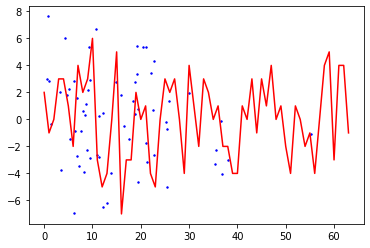

Epoch: 5700 Accurracy real: 0.078125 Accurracy fake: 0.75
Epoch: 5701 Accurracy real: 0.046875 Accurracy fake: 0.875
Epoch: 5702 Accurracy real: 0.078125 Accurracy fake: 0.796875
Epoch: 5703 Accurracy real: 0.0625 Accurracy fake: 0.84375
Epoch: 5704 Accurracy real: 0.078125 Accurracy fake: 0.859375
Epoch: 5705 Accurracy real: 0.0625 Accurracy fake: 0.8125
Epoch: 5706 Accurracy real: 0.0625 Accurracy fake: 0.84375
Epoch: 5707 Accurracy real: 0.078125 Accurracy fake: 0.65625
Epoch: 5708 Accurracy real: 0.03125 Accurracy fake: 0.796875
Epoch: 5709 Accurracy real: 0.015625 Accurracy fake: 0.84375
Epoch: 5710 Accurracy real: 0.078125 Accurracy fake: 0.90625
Epoch: 5711 Accurracy real: 0.03125 Accurracy fake: 0.859375
Epoch: 5712 Accurracy real: 0.140625 Accurracy fake: 0.875
Epoch: 5713 Accurracy real: 0.078125 Accurracy fake: 0.9375
Epoch: 5714 Accurracy real: 0.109375 Accurracy fake: 0.796875
Epoch: 5715 Accurracy real: 0.0625 Accurracy fake: 0.75
Epoch: 5716 Accurracy real: 0.0625 Accurr

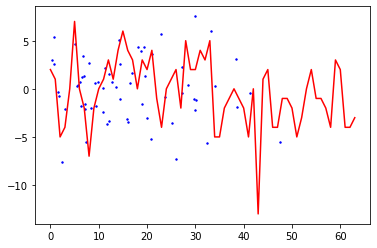

Epoch: 5750 Accurracy real: 0.421875 Accurracy fake: 0.609375
Epoch: 5751 Accurracy real: 0.3125 Accurracy fake: 0.4375
Epoch: 5752 Accurracy real: 0.265625 Accurracy fake: 0.65625
Epoch: 5753 Accurracy real: 0.3125 Accurracy fake: 0.65625
Epoch: 5754 Accurracy real: 0.3125 Accurracy fake: 0.609375
Epoch: 5755 Accurracy real: 0.296875 Accurracy fake: 0.5625
Epoch: 5756 Accurracy real: 0.390625 Accurracy fake: 0.5625
Epoch: 5757 Accurracy real: 0.28125 Accurracy fake: 0.59375
Epoch: 5758 Accurracy real: 0.25 Accurracy fake: 0.59375
Epoch: 5759 Accurracy real: 0.359375 Accurracy fake: 0.53125
Epoch: 5760 Accurracy real: 0.421875 Accurracy fake: 0.453125
Epoch: 5761 Accurracy real: 0.5625 Accurracy fake: 0.4375
Epoch: 5762 Accurracy real: 0.59375 Accurracy fake: 0.484375
Epoch: 5763 Accurracy real: 0.78125 Accurracy fake: 0.453125
Epoch: 5764 Accurracy real: 0.875 Accurracy fake: 0.265625
Epoch: 5765 Accurracy real: 0.84375 Accurracy fake: 0.21875
Epoch: 5766 Accurracy real: 0.859375 Accu

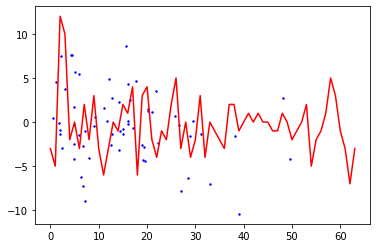

Epoch: 5800 Accurracy real: 0.84375 Accurracy fake: 0.375
Epoch: 5801 Accurracy real: 0.828125 Accurracy fake: 0.390625
Epoch: 5802 Accurracy real: 0.84375 Accurracy fake: 0.34375
Epoch: 5803 Accurracy real: 0.875 Accurracy fake: 0.515625
Epoch: 5804 Accurracy real: 0.796875 Accurracy fake: 0.328125
Epoch: 5805 Accurracy real: 0.828125 Accurracy fake: 0.53125
Epoch: 5806 Accurracy real: 0.78125 Accurracy fake: 0.609375
Epoch: 5807 Accurracy real: 0.515625 Accurracy fake: 0.640625
Epoch: 5808 Accurracy real: 0.296875 Accurracy fake: 0.6875
Epoch: 5809 Accurracy real: 0.34375 Accurracy fake: 0.640625
Epoch: 5810 Accurracy real: 0.40625 Accurracy fake: 0.625
Epoch: 5811 Accurracy real: 0.53125 Accurracy fake: 0.78125
Epoch: 5812 Accurracy real: 0.515625 Accurracy fake: 0.515625
Epoch: 5813 Accurracy real: 0.703125 Accurracy fake: 0.59375
Epoch: 5814 Accurracy real: 0.6875 Accurracy fake: 0.4375
Epoch: 5815 Accurracy real: 0.734375 Accurracy fake: 0.390625
Epoch: 5816 Accurracy real: 0.765

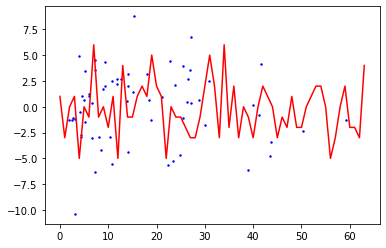

Epoch: 5850 Accurracy real: 0.03125 Accurracy fake: 0.984375
Epoch: 5851 Accurracy real: 0.015625 Accurracy fake: 0.921875
Epoch: 5852 Accurracy real: 0.046875 Accurracy fake: 0.90625
Epoch: 5853 Accurracy real: 0.03125 Accurracy fake: 0.984375
Epoch: 5854 Accurracy real: 0.0625 Accurracy fake: 0.90625
Epoch: 5855 Accurracy real: 0.03125 Accurracy fake: 0.9375
Epoch: 5856 Accurracy real: 0.265625 Accurracy fake: 0.921875
Epoch: 5857 Accurracy real: 0.03125 Accurracy fake: 0.953125
Epoch: 5858 Accurracy real: 0.046875 Accurracy fake: 0.921875
Epoch: 5859 Accurracy real: 0.09375 Accurracy fake: 0.921875
Epoch: 5860 Accurracy real: 0.125 Accurracy fake: 0.796875
Epoch: 5861 Accurracy real: 0.21875 Accurracy fake: 0.84375
Epoch: 5862 Accurracy real: 0.140625 Accurracy fake: 0.734375
Epoch: 5863 Accurracy real: 0.1875 Accurracy fake: 0.859375
Epoch: 5864 Accurracy real: 0.234375 Accurracy fake: 0.71875
Epoch: 5865 Accurracy real: 0.328125 Accurracy fake: 0.609375
Epoch: 5866 Accurracy real:

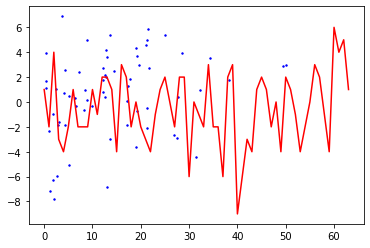

Epoch: 5900 Accurracy real: 0.140625 Accurracy fake: 0.75
Epoch: 5901 Accurracy real: 0.171875 Accurracy fake: 0.75
Epoch: 5902 Accurracy real: 0.21875 Accurracy fake: 0.640625
Epoch: 5903 Accurracy real: 0.59375 Accurracy fake: 0.703125
Epoch: 5904 Accurracy real: 0.375 Accurracy fake: 0.609375
Epoch: 5905 Accurracy real: 0.3125 Accurracy fake: 0.578125
Epoch: 5906 Accurracy real: 0.453125 Accurracy fake: 0.578125
Epoch: 5907 Accurracy real: 0.375 Accurracy fake: 0.734375
Epoch: 5908 Accurracy real: 0.484375 Accurracy fake: 0.6875
Epoch: 5909 Accurracy real: 0.484375 Accurracy fake: 0.625
Epoch: 5910 Accurracy real: 0.359375 Accurracy fake: 0.578125
Epoch: 5911 Accurracy real: 0.4375 Accurracy fake: 0.578125
Epoch: 5912 Accurracy real: 0.65625 Accurracy fake: 0.625
Epoch: 5913 Accurracy real: 0.578125 Accurracy fake: 0.4375
Epoch: 5914 Accurracy real: 0.78125 Accurracy fake: 0.484375
Epoch: 5915 Accurracy real: 0.625 Accurracy fake: 0.640625
Epoch: 5916 Accurracy real: 0.671875 Accurr

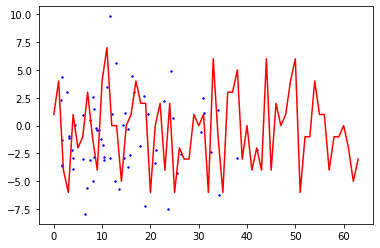

Epoch: 5950 Accurracy real: 0.3125 Accurracy fake: 0.734375
Epoch: 5951 Accurracy real: 0.453125 Accurracy fake: 0.703125
Epoch: 5952 Accurracy real: 0.75 Accurracy fake: 0.53125
Epoch: 5953 Accurracy real: 0.578125 Accurracy fake: 0.5625
Epoch: 5954 Accurracy real: 0.546875 Accurracy fake: 0.421875
Epoch: 5955 Accurracy real: 0.75 Accurracy fake: 0.53125
Epoch: 5956 Accurracy real: 0.640625 Accurracy fake: 0.421875
Epoch: 5957 Accurracy real: 0.84375 Accurracy fake: 0.375
Epoch: 5958 Accurracy real: 0.671875 Accurracy fake: 0.4375
Epoch: 5959 Accurracy real: 0.765625 Accurracy fake: 0.640625
Epoch: 5960 Accurracy real: 0.4375 Accurracy fake: 0.625
Epoch: 5961 Accurracy real: 0.359375 Accurracy fake: 0.671875
Epoch: 5962 Accurracy real: 0.1875 Accurracy fake: 0.640625
Epoch: 5963 Accurracy real: 0.390625 Accurracy fake: 0.671875
Epoch: 5964 Accurracy real: 0.796875 Accurracy fake: 0.828125
Epoch: 5965 Accurracy real: 0.203125 Accurracy fake: 0.765625
Epoch: 5966 Accurracy real: 0.25 Ac

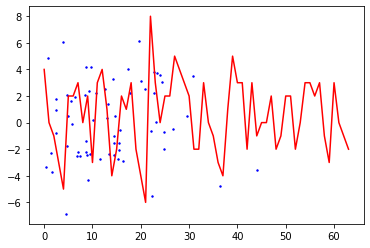

Epoch: 6000 Accurracy real: 0.078125 Accurracy fake: 0.84375
Epoch: 6001 Accurracy real: 0.0625 Accurracy fake: 0.84375
Epoch: 6002 Accurracy real: 0.03125 Accurracy fake: 0.9375
Epoch: 6003 Accurracy real: 0.140625 Accurracy fake: 0.796875
Epoch: 6004 Accurracy real: 0.09375 Accurracy fake: 0.796875
Epoch: 6005 Accurracy real: 0.125 Accurracy fake: 0.6875
Epoch: 6006 Accurracy real: 0.078125 Accurracy fake: 0.84375
Epoch: 6007 Accurracy real: 0.0625 Accurracy fake: 0.890625
Epoch: 6008 Accurracy real: 0.109375 Accurracy fake: 0.75
Epoch: 6009 Accurracy real: 0.15625 Accurracy fake: 0.734375
Epoch: 6010 Accurracy real: 0.265625 Accurracy fake: 0.6875
Epoch: 6011 Accurracy real: 0.359375 Accurracy fake: 0.65625
Epoch: 6012 Accurracy real: 0.734375 Accurracy fake: 0.484375
Epoch: 6013 Accurracy real: 0.75 Accurracy fake: 0.40625
Epoch: 6014 Accurracy real: 0.65625 Accurracy fake: 0.390625
Epoch: 6015 Accurracy real: 0.75 Accurracy fake: 0.359375
Epoch: 6016 Accurracy real: 0.84375 Accurr

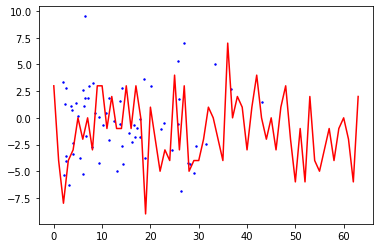

Epoch: 6050 Accurracy real: 0.015625 Accurracy fake: 0.796875
Epoch: 6051 Accurracy real: 0.046875 Accurracy fake: 0.8125
Epoch: 6052 Accurracy real: 0.0625 Accurracy fake: 0.890625
Epoch: 6053 Accurracy real: 0.125 Accurracy fake: 0.6875
Epoch: 6054 Accurracy real: 0.03125 Accurracy fake: 0.875
Epoch: 6055 Accurracy real: 0.078125 Accurracy fake: 0.84375
Epoch: 6056 Accurracy real: 0.046875 Accurracy fake: 0.875
Epoch: 6057 Accurracy real: 0.03125 Accurracy fake: 0.890625
Epoch: 6058 Accurracy real: 0.078125 Accurracy fake: 0.84375
Epoch: 6059 Accurracy real: 0.078125 Accurracy fake: 0.796875
Epoch: 6060 Accurracy real: 0.078125 Accurracy fake: 0.875
Epoch: 6061 Accurracy real: 0.0625 Accurracy fake: 0.859375
Epoch: 6062 Accurracy real: 0.078125 Accurracy fake: 0.859375
Epoch: 6063 Accurracy real: 0.109375 Accurracy fake: 0.90625
Epoch: 6064 Accurracy real: 0.09375 Accurracy fake: 0.796875
Epoch: 6065 Accurracy real: 0.0625 Accurracy fake: 0.84375
Epoch: 6066 Accurracy real: 0.046875 

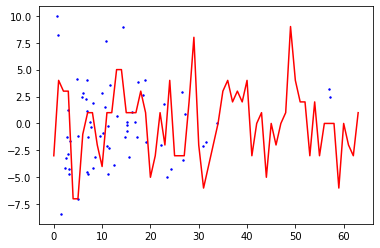

Epoch: 6100 Accurracy real: 0.75 Accurracy fake: 0.328125
Epoch: 6101 Accurracy real: 0.84375 Accurracy fake: 0.328125
Epoch: 6102 Accurracy real: 0.84375 Accurracy fake: 0.34375
Epoch: 6103 Accurracy real: 0.921875 Accurracy fake: 0.3125
Epoch: 6104 Accurracy real: 0.921875 Accurracy fake: 0.1875
Epoch: 6105 Accurracy real: 0.90625 Accurracy fake: 0.140625
Epoch: 6106 Accurracy real: 0.859375 Accurracy fake: 0.203125
Epoch: 6107 Accurracy real: 0.90625 Accurracy fake: 0.25
Epoch: 6108 Accurracy real: 0.921875 Accurracy fake: 0.296875
Epoch: 6109 Accurracy real: 0.796875 Accurracy fake: 0.265625
Epoch: 6110 Accurracy real: 0.90625 Accurracy fake: 0.1875
Epoch: 6111 Accurracy real: 0.890625 Accurracy fake: 0.28125
Epoch: 6112 Accurracy real: 0.90625 Accurracy fake: 0.234375
Epoch: 6113 Accurracy real: 0.90625 Accurracy fake: 0.1875
Epoch: 6114 Accurracy real: 0.90625 Accurracy fake: 0.203125
Epoch: 6115 Accurracy real: 0.875 Accurracy fake: 0.265625
Epoch: 6116 Accurracy real: 0.890625 

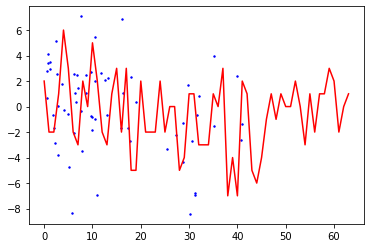

Epoch: 6150 Accurracy real: 0.890625 Accurracy fake: 0.203125
Epoch: 6151 Accurracy real: 0.890625 Accurracy fake: 0.28125
Epoch: 6152 Accurracy real: 0.765625 Accurracy fake: 0.265625
Epoch: 6153 Accurracy real: 0.828125 Accurracy fake: 0.28125
Epoch: 6154 Accurracy real: 0.75 Accurracy fake: 0.40625
Epoch: 6155 Accurracy real: 0.75 Accurracy fake: 0.375
Epoch: 6156 Accurracy real: 0.75 Accurracy fake: 0.34375
Epoch: 6157 Accurracy real: 0.640625 Accurracy fake: 0.453125
Epoch: 6158 Accurracy real: 0.75 Accurracy fake: 0.4375
Epoch: 6159 Accurracy real: 0.578125 Accurracy fake: 0.484375
Epoch: 6160 Accurracy real: 0.46875 Accurracy fake: 0.5625
Epoch: 6161 Accurracy real: 0.421875 Accurracy fake: 0.640625
Epoch: 6162 Accurracy real: 0.375 Accurracy fake: 0.609375
Epoch: 6163 Accurracy real: 0.203125 Accurracy fake: 0.84375
Epoch: 6164 Accurracy real: 0.28125 Accurracy fake: 0.765625
Epoch: 6165 Accurracy real: 0.640625 Accurracy fake: 0.671875
Epoch: 6166 Accurracy real: 0.453125 Accu

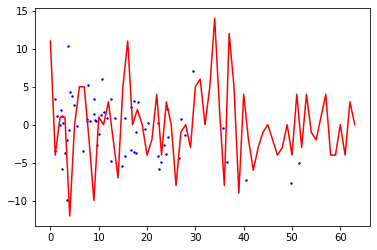

Epoch: 6200 Accurracy real: 0.40625 Accurracy fake: 0.71875
Epoch: 6201 Accurracy real: 0.296875 Accurracy fake: 0.71875
Epoch: 6202 Accurracy real: 0.25 Accurracy fake: 0.75
Epoch: 6203 Accurracy real: 0.015625 Accurracy fake: 0.8125
Epoch: 6204 Accurracy real: 0.09375 Accurracy fake: 0.90625
Epoch: 6205 Accurracy real: 0.078125 Accurracy fake: 0.875
Epoch: 6206 Accurracy real: 0.078125 Accurracy fake: 0.890625
Epoch: 6207 Accurracy real: 0.078125 Accurracy fake: 0.8125
Epoch: 6208 Accurracy real: 0.03125 Accurracy fake: 0.84375
Epoch: 6209 Accurracy real: 0.046875 Accurracy fake: 0.828125
Epoch: 6210 Accurracy real: 0.078125 Accurracy fake: 0.875
Epoch: 6211 Accurracy real: 0.171875 Accurracy fake: 0.75
Epoch: 6212 Accurracy real: 0.59375 Accurracy fake: 0.703125
Epoch: 6213 Accurracy real: 0.78125 Accurracy fake: 0.421875
Epoch: 6214 Accurracy real: 0.828125 Accurracy fake: 0.40625
Epoch: 6215 Accurracy real: 0.90625 Accurracy fake: 0.265625
Epoch: 6216 Accurracy real: 0.796875 Accu

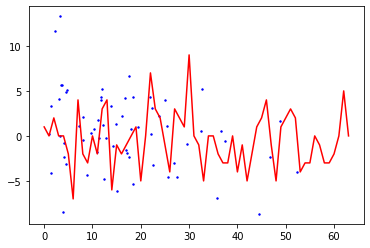

Epoch: 6250 Accurracy real: 0.578125 Accurracy fake: 0.515625
Epoch: 6251 Accurracy real: 0.71875 Accurracy fake: 0.453125
Epoch: 6252 Accurracy real: 0.875 Accurracy fake: 0.40625
Epoch: 6253 Accurracy real: 0.765625 Accurracy fake: 0.46875
Epoch: 6254 Accurracy real: 0.609375 Accurracy fake: 0.640625
Epoch: 6255 Accurracy real: 0.625 Accurracy fake: 0.59375
Epoch: 6256 Accurracy real: 0.46875 Accurracy fake: 0.59375
Epoch: 6257 Accurracy real: 0.203125 Accurracy fake: 0.75
Epoch: 6258 Accurracy real: 0.046875 Accurracy fake: 0.921875
Epoch: 6259 Accurracy real: 0.078125 Accurracy fake: 0.953125
Epoch: 6260 Accurracy real: 0.0 Accurracy fake: 0.921875
Epoch: 6261 Accurracy real: 0.0625 Accurracy fake: 0.90625
Epoch: 6262 Accurracy real: 0.0625 Accurracy fake: 0.890625
Epoch: 6263 Accurracy real: 0.109375 Accurracy fake: 0.84375
Epoch: 6264 Accurracy real: 0.046875 Accurracy fake: 0.890625
Epoch: 6265 Accurracy real: 0.578125 Accurracy fake: 0.53125
Epoch: 6266 Accurracy real: 0.734375

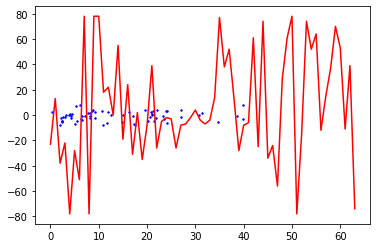

Epoch: 6300 Accurracy real: 0.015625 Accurracy fake: 0.8125
Epoch: 6301 Accurracy real: 0.1875 Accurracy fake: 0.84375
Epoch: 6302 Accurracy real: 0.84375 Accurracy fake: 0.40625
Epoch: 6303 Accurracy real: 0.859375 Accurracy fake: 0.421875
Epoch: 6304 Accurracy real: 0.8125 Accurracy fake: 0.375
Epoch: 6305 Accurracy real: 0.859375 Accurracy fake: 0.25
Epoch: 6306 Accurracy real: 0.84375 Accurracy fake: 0.375
Epoch: 6307 Accurracy real: 0.875 Accurracy fake: 0.34375
Epoch: 6308 Accurracy real: 0.890625 Accurracy fake: 0.40625
Epoch: 6309 Accurracy real: 0.859375 Accurracy fake: 0.34375
Epoch: 6310 Accurracy real: 0.875 Accurracy fake: 0.265625
Epoch: 6311 Accurracy real: 0.84375 Accurracy fake: 0.46875
Epoch: 6312 Accurracy real: 0.703125 Accurracy fake: 0.546875
Epoch: 6313 Accurracy real: 0.328125 Accurracy fake: 0.5625
Epoch: 6314 Accurracy real: 0.140625 Accurracy fake: 0.84375
Epoch: 6315 Accurracy real: 0.234375 Accurracy fake: 0.734375
Epoch: 6316 Accurracy real: 0.296875 Accur

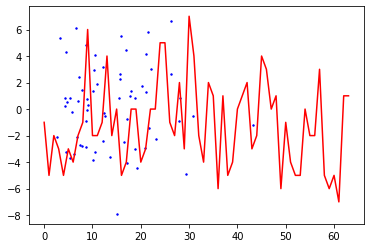

Epoch: 6350 Accurracy real: 0.59375 Accurracy fake: 0.546875
Epoch: 6351 Accurracy real: 0.515625 Accurracy fake: 0.65625
Epoch: 6352 Accurracy real: 0.65625 Accurracy fake: 0.5
Epoch: 6353 Accurracy real: 0.609375 Accurracy fake: 0.546875
Epoch: 6354 Accurracy real: 0.640625 Accurracy fake: 0.421875
Epoch: 6355 Accurracy real: 0.515625 Accurracy fake: 0.640625
Epoch: 6356 Accurracy real: 0.578125 Accurracy fake: 0.53125
Epoch: 6357 Accurracy real: 0.40625 Accurracy fake: 0.546875
Epoch: 6358 Accurracy real: 0.34375 Accurracy fake: 0.75
Epoch: 6359 Accurracy real: 0.1875 Accurracy fake: 0.703125
Epoch: 6360 Accurracy real: 0.1875 Accurracy fake: 0.6875
Epoch: 6361 Accurracy real: 0.234375 Accurracy fake: 0.78125
Epoch: 6362 Accurracy real: 0.0625 Accurracy fake: 0.734375
Epoch: 6363 Accurracy real: 0.046875 Accurracy fake: 0.8125
Epoch: 6364 Accurracy real: 0.15625 Accurracy fake: 0.671875
Epoch: 6365 Accurracy real: 0.21875 Accurracy fake: 0.734375
Epoch: 6366 Accurracy real: 0.609375

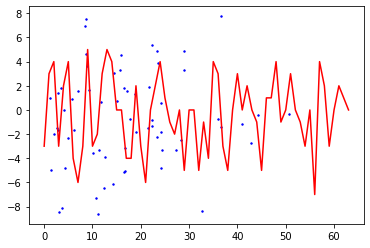

Epoch: 6400 Accurracy real: 0.046875 Accurracy fake: 0.828125
Epoch: 6401 Accurracy real: 0.078125 Accurracy fake: 0.890625
Epoch: 6402 Accurracy real: 0.03125 Accurracy fake: 0.984375
Epoch: 6403 Accurracy real: 0.03125 Accurracy fake: 0.875
Epoch: 6404 Accurracy real: 0.046875 Accurracy fake: 0.84375
Epoch: 6405 Accurracy real: 0.078125 Accurracy fake: 0.8125
Epoch: 6406 Accurracy real: 0.0625 Accurracy fake: 0.828125
Epoch: 6407 Accurracy real: 0.578125 Accurracy fake: 0.671875
Epoch: 6408 Accurracy real: 0.859375 Accurracy fake: 0.375
Epoch: 6409 Accurracy real: 0.875 Accurracy fake: 0.21875
Epoch: 6410 Accurracy real: 0.921875 Accurracy fake: 0.171875
Epoch: 6411 Accurracy real: 0.90625 Accurracy fake: 0.15625
Epoch: 6412 Accurracy real: 0.90625 Accurracy fake: 0.28125
Epoch: 6413 Accurracy real: 0.859375 Accurracy fake: 0.28125
Epoch: 6414 Accurracy real: 0.375 Accurracy fake: 0.875
Epoch: 6415 Accurracy real: 0.125 Accurracy fake: 0.8125
Epoch: 6416 Accurracy real: 0.03125 Accur

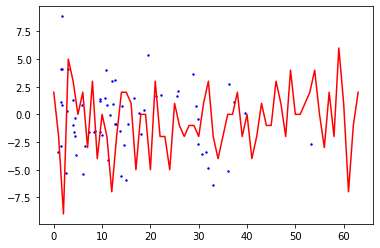

Epoch: 6450 Accurracy real: 0.234375 Accurracy fake: 0.671875
Epoch: 6451 Accurracy real: 0.59375 Accurracy fake: 0.578125
Epoch: 6452 Accurracy real: 0.828125 Accurracy fake: 0.328125
Epoch: 6453 Accurracy real: 0.8125 Accurracy fake: 0.296875
Epoch: 6454 Accurracy real: 0.84375 Accurracy fake: 0.25
Epoch: 6455 Accurracy real: 0.890625 Accurracy fake: 0.328125
Epoch: 6456 Accurracy real: 0.78125 Accurracy fake: 0.265625
Epoch: 6457 Accurracy real: 0.546875 Accurracy fake: 0.5625
Epoch: 6458 Accurracy real: 0.359375 Accurracy fake: 0.75
Epoch: 6459 Accurracy real: 0.0625 Accurracy fake: 0.75
Epoch: 6460 Accurracy real: 0.03125 Accurracy fake: 0.859375
Epoch: 6461 Accurracy real: 0.046875 Accurracy fake: 0.890625
Epoch: 6462 Accurracy real: 0.046875 Accurracy fake: 0.859375
Epoch: 6463 Accurracy real: 0.078125 Accurracy fake: 0.84375
Epoch: 6464 Accurracy real: 0.09375 Accurracy fake: 0.75
Epoch: 6465 Accurracy real: 0.03125 Accurracy fake: 0.8125
Epoch: 6466 Accurracy real: 0.0625 Accu

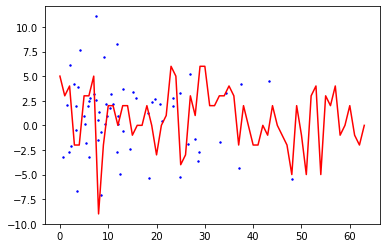

Epoch: 6500 Accurracy real: 0.921875 Accurracy fake: 0.25
Epoch: 6501 Accurracy real: 0.921875 Accurracy fake: 0.171875
Epoch: 6502 Accurracy real: 0.859375 Accurracy fake: 0.21875
Epoch: 6503 Accurracy real: 0.875 Accurracy fake: 0.3125
Epoch: 6504 Accurracy real: 0.703125 Accurracy fake: 0.5625
Epoch: 6505 Accurracy real: 0.078125 Accurracy fake: 0.9375
Epoch: 6506 Accurracy real: 0.015625 Accurracy fake: 0.921875
Epoch: 6507 Accurracy real: 0.046875 Accurracy fake: 0.90625
Epoch: 6508 Accurracy real: 0.03125 Accurracy fake: 0.953125
Epoch: 6509 Accurracy real: 0.046875 Accurracy fake: 0.9375
Epoch: 6510 Accurracy real: 0.21875 Accurracy fake: 0.96875
Epoch: 6511 Accurracy real: 0.015625 Accurracy fake: 0.921875
Epoch: 6512 Accurracy real: 0.125 Accurracy fake: 0.890625
Epoch: 6513 Accurracy real: 0.171875 Accurracy fake: 0.859375
Epoch: 6514 Accurracy real: 0.46875 Accurracy fake: 0.65625
Epoch: 6515 Accurracy real: 0.546875 Accurracy fake: 0.65625
Epoch: 6516 Accurracy real: 0.6093

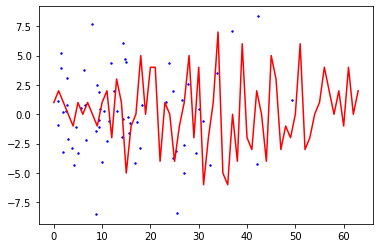

Epoch: 6550 Accurracy real: 0.09375 Accurracy fake: 0.796875
Epoch: 6551 Accurracy real: 0.046875 Accurracy fake: 0.796875
Epoch: 6552 Accurracy real: 0.078125 Accurracy fake: 0.796875
Epoch: 6553 Accurracy real: 0.03125 Accurracy fake: 0.84375
Epoch: 6554 Accurracy real: 0.046875 Accurracy fake: 0.8125
Epoch: 6555 Accurracy real: 0.09375 Accurracy fake: 0.796875
Epoch: 6556 Accurracy real: 0.125 Accurracy fake: 0.84375
Epoch: 6557 Accurracy real: 0.125 Accurracy fake: 0.859375
Epoch: 6558 Accurracy real: 0.171875 Accurracy fake: 0.71875
Epoch: 6559 Accurracy real: 0.1875 Accurracy fake: 0.6875
Epoch: 6560 Accurracy real: 0.328125 Accurracy fake: 0.625
Epoch: 6561 Accurracy real: 0.546875 Accurracy fake: 0.59375
Epoch: 6562 Accurracy real: 0.625 Accurracy fake: 0.59375
Epoch: 6563 Accurracy real: 0.6875 Accurracy fake: 0.53125
Epoch: 6564 Accurracy real: 0.734375 Accurracy fake: 0.546875
Epoch: 6565 Accurracy real: 0.8125 Accurracy fake: 0.296875
Epoch: 6566 Accurracy real: 0.84375 Acc

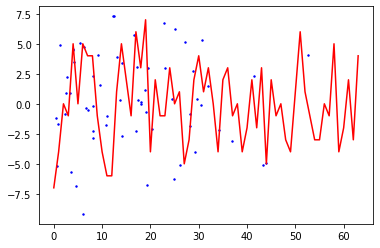

Epoch: 6600 Accurracy real: 0.109375 Accurracy fake: 0.859375
Epoch: 6601 Accurracy real: 0.703125 Accurracy fake: 0.53125
Epoch: 6602 Accurracy real: 0.875 Accurracy fake: 0.203125
Epoch: 6603 Accurracy real: 0.859375 Accurracy fake: 0.265625
Epoch: 6604 Accurracy real: 0.875 Accurracy fake: 0.203125
Epoch: 6605 Accurracy real: 0.921875 Accurracy fake: 0.296875
Epoch: 6606 Accurracy real: 0.90625 Accurracy fake: 0.265625
Epoch: 6607 Accurracy real: 0.5 Accurracy fake: 0.21875
Epoch: 6608 Accurracy real: 0.859375 Accurracy fake: 0.328125
Epoch: 6609 Accurracy real: 0.84375 Accurracy fake: 0.34375
Epoch: 6610 Accurracy real: 0.46875 Accurracy fake: 0.703125
Epoch: 6611 Accurracy real: 0.109375 Accurracy fake: 0.859375
Epoch: 6612 Accurracy real: 0.046875 Accurracy fake: 0.921875
Epoch: 6613 Accurracy real: 0.0 Accurracy fake: 0.96875
Epoch: 6614 Accurracy real: 0.0 Accurracy fake: 0.921875
Epoch: 6615 Accurracy real: 0.03125 Accurracy fake: 0.890625
Epoch: 6616 Accurracy real: 0.046875 

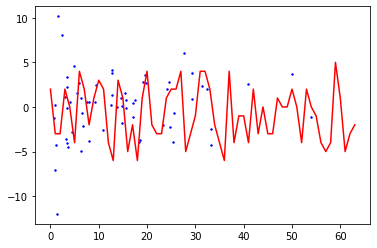

Epoch: 6650 Accurracy real: 0.078125 Accurracy fake: 0.796875
Epoch: 6651 Accurracy real: 0.28125 Accurracy fake: 0.6875
Epoch: 6652 Accurracy real: 0.8125 Accurracy fake: 0.140625
Epoch: 6653 Accurracy real: 0.90625 Accurracy fake: 0.28125
Epoch: 6654 Accurracy real: 0.890625 Accurracy fake: 0.3125
Epoch: 6655 Accurracy real: 0.890625 Accurracy fake: 0.265625
Epoch: 6656 Accurracy real: 0.96875 Accurracy fake: 0.203125
Epoch: 6657 Accurracy real: 0.859375 Accurracy fake: 0.171875
Epoch: 6658 Accurracy real: 0.875 Accurracy fake: 0.328125
Epoch: 6659 Accurracy real: 0.28125 Accurracy fake: 0.703125
Epoch: 6660 Accurracy real: 0.03125 Accurracy fake: 0.921875
Epoch: 6661 Accurracy real: 0.015625 Accurracy fake: 0.78125
Epoch: 6662 Accurracy real: 0.046875 Accurracy fake: 0.8125
Epoch: 6663 Accurracy real: 0.015625 Accurracy fake: 0.875
Epoch: 6664 Accurracy real: 0.078125 Accurracy fake: 0.875
Epoch: 6665 Accurracy real: 0.515625 Accurracy fake: 0.90625
Epoch: 6666 Accurracy real: 0.046

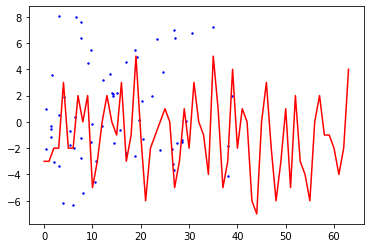

Epoch: 6700 Accurracy real: 0.859375 Accurracy fake: 0.1875
Epoch: 6701 Accurracy real: 0.859375 Accurracy fake: 0.21875
Epoch: 6702 Accurracy real: 0.90625 Accurracy fake: 0.296875
Epoch: 6703 Accurracy real: 0.890625 Accurracy fake: 0.34375
Epoch: 6704 Accurracy real: 0.75 Accurracy fake: 0.25
Epoch: 6705 Accurracy real: 0.703125 Accurracy fake: 0.359375
Epoch: 6706 Accurracy real: 0.75 Accurracy fake: 0.328125
Epoch: 6707 Accurracy real: 0.5625 Accurracy fake: 0.40625
Epoch: 6708 Accurracy real: 0.65625 Accurracy fake: 0.484375
Epoch: 6709 Accurracy real: 0.578125 Accurracy fake: 0.40625
Epoch: 6710 Accurracy real: 0.65625 Accurracy fake: 0.5
Epoch: 6711 Accurracy real: 0.453125 Accurracy fake: 0.484375
Epoch: 6712 Accurracy real: 0.359375 Accurracy fake: 0.546875
Epoch: 6713 Accurracy real: 0.1875 Accurracy fake: 0.625
Epoch: 6714 Accurracy real: 0.125 Accurracy fake: 0.609375
Epoch: 6715 Accurracy real: 0.171875 Accurracy fake: 0.75
Epoch: 6716 Accurracy real: 0.21875 Accurracy fa

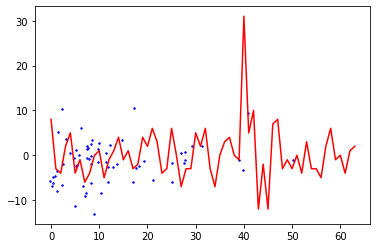

Epoch: 6750 Accurracy real: 0.796875 Accurracy fake: 0.34375
Epoch: 6751 Accurracy real: 0.890625 Accurracy fake: 0.296875
Epoch: 6752 Accurracy real: 0.859375 Accurracy fake: 0.421875
Epoch: 6753 Accurracy real: 0.703125 Accurracy fake: 0.421875
Epoch: 6754 Accurracy real: 0.5 Accurracy fake: 0.671875
Epoch: 6755 Accurracy real: 0.59375 Accurracy fake: 0.46875
Epoch: 6756 Accurracy real: 0.53125 Accurracy fake: 0.453125
Epoch: 6757 Accurracy real: 0.703125 Accurracy fake: 0.5
Epoch: 6758 Accurracy real: 0.6875 Accurracy fake: 0.421875
Epoch: 6759 Accurracy real: 0.671875 Accurracy fake: 0.40625
Epoch: 6760 Accurracy real: 0.75 Accurracy fake: 0.484375
Epoch: 6761 Accurracy real: 0.75 Accurracy fake: 0.484375
Epoch: 6762 Accurracy real: 0.78125 Accurracy fake: 0.515625
Epoch: 6763 Accurracy real: 0.546875 Accurracy fake: 0.34375
Epoch: 6764 Accurracy real: 0.609375 Accurracy fake: 0.5
Epoch: 6765 Accurracy real: 0.53125 Accurracy fake: 0.6875
Epoch: 6766 Accurracy real: 0.515625 Accurr

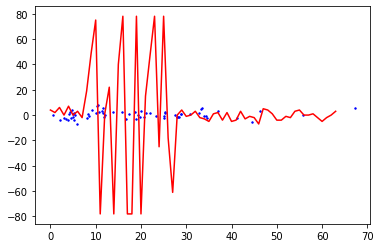

Epoch: 6800 Accurracy real: 0.21875 Accurracy fake: 0.640625
Epoch: 6801 Accurracy real: 0.25 Accurracy fake: 0.65625
Epoch: 6802 Accurracy real: 0.234375 Accurracy fake: 0.375
Epoch: 6803 Accurracy real: 0.265625 Accurracy fake: 0.5
Epoch: 6804 Accurracy real: 0.3125 Accurracy fake: 0.65625
Epoch: 6805 Accurracy real: 0.15625 Accurracy fake: 0.59375
Epoch: 6806 Accurracy real: 0.203125 Accurracy fake: 0.6875
Epoch: 6807 Accurracy real: 0.1875 Accurracy fake: 0.640625
Epoch: 6808 Accurracy real: 0.15625 Accurracy fake: 0.734375
Epoch: 6809 Accurracy real: 0.25 Accurracy fake: 0.71875
Epoch: 6810 Accurracy real: 0.21875 Accurracy fake: 0.59375
Epoch: 6811 Accurracy real: 0.375 Accurracy fake: 0.59375
Epoch: 6812 Accurracy real: 0.53125 Accurracy fake: 0.390625
Epoch: 6813 Accurracy real: 0.515625 Accurracy fake: 0.5
Epoch: 6814 Accurracy real: 0.609375 Accurracy fake: 0.40625
Epoch: 6815 Accurracy real: 0.6875 Accurracy fake: 0.375
Epoch: 6816 Accurracy real: 0.703125 Accurracy fake: 0.

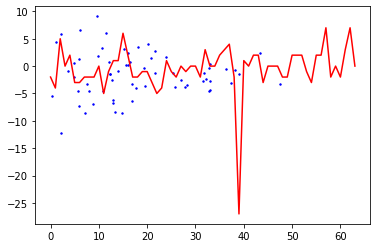

Epoch: 6850 Accurracy real: 0.015625 Accurracy fake: 0.875
Epoch: 6851 Accurracy real: 0.09375 Accurracy fake: 0.890625
Epoch: 6852 Accurracy real: 0.0625 Accurracy fake: 0.921875
Epoch: 6853 Accurracy real: 0.0625 Accurracy fake: 0.78125
Epoch: 6854 Accurracy real: 0.0625 Accurracy fake: 0.90625
Epoch: 6855 Accurracy real: 0.359375 Accurracy fake: 0.875
Epoch: 6856 Accurracy real: 0.125 Accurracy fake: 0.71875
Epoch: 6857 Accurracy real: 0.140625 Accurracy fake: 0.765625
Epoch: 6858 Accurracy real: 0.328125 Accurracy fake: 0.640625
Epoch: 6859 Accurracy real: 0.46875 Accurracy fake: 0.375
Epoch: 6860 Accurracy real: 0.515625 Accurracy fake: 0.390625
Epoch: 6861 Accurracy real: 0.703125 Accurracy fake: 0.59375
Epoch: 6862 Accurracy real: 0.296875 Accurracy fake: 0.578125
Epoch: 6863 Accurracy real: 0.046875 Accurracy fake: 0.765625
Epoch: 6864 Accurracy real: 0.046875 Accurracy fake: 0.765625
Epoch: 6865 Accurracy real: 0.03125 Accurracy fake: 0.828125
Epoch: 6866 Accurracy real: 0.093

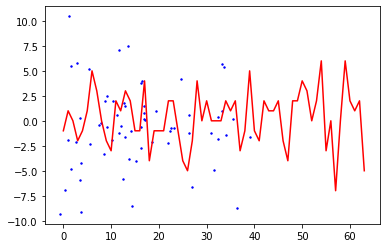

Epoch: 6900 Accurracy real: 0.421875 Accurracy fake: 0.46875
Epoch: 6901 Accurracy real: 0.859375 Accurracy fake: 0.28125
Epoch: 6902 Accurracy real: 0.90625 Accurracy fake: 0.265625
Epoch: 6903 Accurracy real: 0.890625 Accurracy fake: 0.34375
Epoch: 6904 Accurracy real: 0.875 Accurracy fake: 0.296875
Epoch: 6905 Accurracy real: 0.890625 Accurracy fake: 0.1875
Epoch: 6906 Accurracy real: 0.90625 Accurracy fake: 0.25
Epoch: 6907 Accurracy real: 0.0 Accurracy fake: 0.84375
Epoch: 6908 Accurracy real: 0.0625 Accurracy fake: 0.875
Epoch: 6909 Accurracy real: 0.03125 Accurracy fake: 0.859375
Epoch: 6910 Accurracy real: 0.03125 Accurracy fake: 0.859375
Epoch: 6911 Accurracy real: 0.03125 Accurracy fake: 0.921875
Epoch: 6912 Accurracy real: 0.09375 Accurracy fake: 0.84375
Epoch: 6913 Accurracy real: 0.0625 Accurracy fake: 0.84375
Epoch: 6914 Accurracy real: 0.0625 Accurracy fake: 0.84375
Epoch: 6915 Accurracy real: 0.0625 Accurracy fake: 0.828125
Epoch: 6916 Accurracy real: 0.125 Accurracy fa

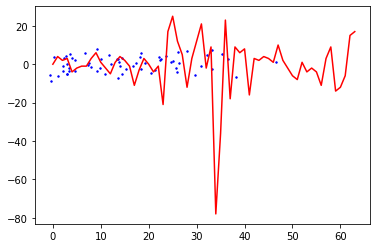

Epoch: 6950 Accurracy real: 0.6875 Accurracy fake: 0.34375
Epoch: 6951 Accurracy real: 0.75 Accurracy fake: 0.453125
Epoch: 6952 Accurracy real: 0.703125 Accurracy fake: 0.46875
Epoch: 6953 Accurracy real: 0.8125 Accurracy fake: 0.421875
Epoch: 6954 Accurracy real: 0.671875 Accurracy fake: 0.328125
Epoch: 6955 Accurracy real: 0.671875 Accurracy fake: 0.359375
Epoch: 6956 Accurracy real: 0.796875 Accurracy fake: 0.421875
Epoch: 6957 Accurracy real: 0.75 Accurracy fake: 0.296875
Epoch: 6958 Accurracy real: 0.71875 Accurracy fake: 0.40625
Epoch: 6959 Accurracy real: 0.859375 Accurracy fake: 0.3125
Epoch: 6960 Accurracy real: 0.765625 Accurracy fake: 0.25
Epoch: 6961 Accurracy real: 0.734375 Accurracy fake: 0.359375
Epoch: 6962 Accurracy real: 0.6875 Accurracy fake: 0.375
Epoch: 6963 Accurracy real: 0.515625 Accurracy fake: 0.5
Epoch: 6964 Accurracy real: 0.375 Accurracy fake: 0.390625
Epoch: 6965 Accurracy real: 0.40625 Accurracy fake: 0.453125
Epoch: 6966 Accurracy real: 0.609375 Accurra

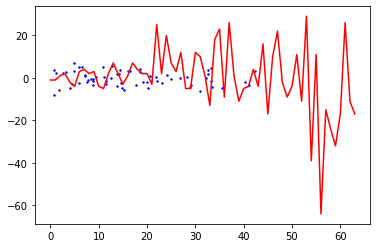

Epoch: 7000 Accurracy real: 0.125 Accurracy fake: 0.796875
Epoch: 7001 Accurracy real: 0.578125 Accurracy fake: 0.515625
Epoch: 7002 Accurracy real: 0.875 Accurracy fake: 0.421875
Epoch: 7003 Accurracy real: 0.703125 Accurracy fake: 0.390625
Epoch: 7004 Accurracy real: 0.875 Accurracy fake: 0.328125
Epoch: 7005 Accurracy real: 0.84375 Accurracy fake: 0.4375
Epoch: 7006 Accurracy real: 0.84375 Accurracy fake: 0.234375
Epoch: 7007 Accurracy real: 0.859375 Accurracy fake: 0.234375
Epoch: 7008 Accurracy real: 0.859375 Accurracy fake: 0.390625
Epoch: 7009 Accurracy real: 0.84375 Accurracy fake: 0.34375
Epoch: 7010 Accurracy real: 0.875 Accurracy fake: 0.34375
Epoch: 7011 Accurracy real: 0.859375 Accurracy fake: 0.390625
Epoch: 7012 Accurracy real: 0.4375 Accurracy fake: 0.5625
Epoch: 7013 Accurracy real: 0.25 Accurracy fake: 0.71875
Epoch: 7014 Accurracy real: 0.109375 Accurracy fake: 0.734375
Epoch: 7015 Accurracy real: 0.109375 Accurracy fake: 0.796875
Epoch: 7016 Accurracy real: 0.078125

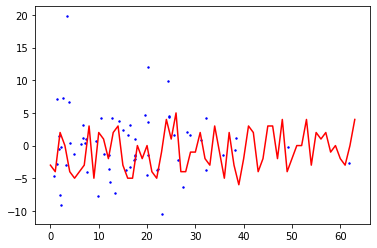

Epoch: 7050 Accurracy real: 0.046875 Accurracy fake: 0.765625
Epoch: 7051 Accurracy real: 0.109375 Accurracy fake: 0.765625
Epoch: 7052 Accurracy real: 0.15625 Accurracy fake: 0.890625
Epoch: 7053 Accurracy real: 0.0625 Accurracy fake: 0.71875
Epoch: 7054 Accurracy real: 0.109375 Accurracy fake: 0.609375
Epoch: 7055 Accurracy real: 0.265625 Accurracy fake: 0.546875
Epoch: 7056 Accurracy real: 0.59375 Accurracy fake: 0.421875
Epoch: 7057 Accurracy real: 0.796875 Accurracy fake: 0.21875
Epoch: 7058 Accurracy real: 0.875 Accurracy fake: 0.21875
Epoch: 7059 Accurracy real: 0.859375 Accurracy fake: 0.171875
Epoch: 7060 Accurracy real: 0.9375 Accurracy fake: 0.203125
Epoch: 7061 Accurracy real: 0.90625 Accurracy fake: 0.140625
Epoch: 7062 Accurracy real: 0.890625 Accurracy fake: 0.15625
Epoch: 7063 Accurracy real: 0.890625 Accurracy fake: 0.15625
Epoch: 7064 Accurracy real: 0.859375 Accurracy fake: 0.21875
Epoch: 7065 Accurracy real: 0.546875 Accurracy fake: 0.515625
Epoch: 7066 Accurracy re

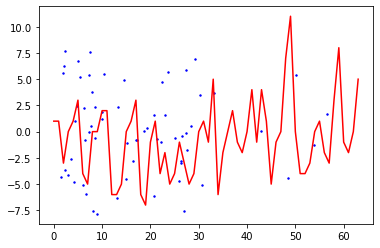

Epoch: 7100 Accurracy real: 0.015625 Accurracy fake: 0.859375
Epoch: 7101 Accurracy real: 0.015625 Accurracy fake: 0.84375
Epoch: 7102 Accurracy real: 0.0625 Accurracy fake: 0.875
Epoch: 7103 Accurracy real: 0.03125 Accurracy fake: 0.65625
Epoch: 7104 Accurracy real: 0.078125 Accurracy fake: 0.875
Epoch: 7105 Accurracy real: 0.171875 Accurracy fake: 0.625
Epoch: 7106 Accurracy real: 0.15625 Accurracy fake: 0.640625
Epoch: 7107 Accurracy real: 0.21875 Accurracy fake: 0.671875
Epoch: 7108 Accurracy real: 0.34375 Accurracy fake: 0.546875
Epoch: 7109 Accurracy real: 0.6875 Accurracy fake: 0.453125
Epoch: 7110 Accurracy real: 0.734375 Accurracy fake: 0.34375
Epoch: 7111 Accurracy real: 0.5 Accurracy fake: 0.3125
Epoch: 7112 Accurracy real: 0.171875 Accurracy fake: 0.65625
Epoch: 7113 Accurracy real: 0.03125 Accurracy fake: 0.859375
Epoch: 7114 Accurracy real: 0.078125 Accurracy fake: 0.859375
Epoch: 7115 Accurracy real: 0.0625 Accurracy fake: 0.765625
Epoch: 7116 Accurracy real: 0.046875 Ac

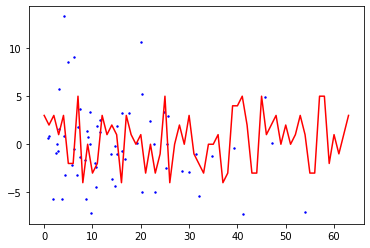

Epoch: 7150 Accurracy real: 0.765625 Accurracy fake: 0.28125
Epoch: 7151 Accurracy real: 0.6875 Accurracy fake: 0.296875
Epoch: 7152 Accurracy real: 0.75 Accurracy fake: 0.328125
Epoch: 7153 Accurracy real: 0.734375 Accurracy fake: 0.375
Epoch: 7154 Accurracy real: 0.78125 Accurracy fake: 0.421875
Epoch: 7155 Accurracy real: 0.796875 Accurracy fake: 0.28125
Epoch: 7156 Accurracy real: 0.796875 Accurracy fake: 0.453125
Epoch: 7157 Accurracy real: 0.484375 Accurracy fake: 0.453125
Epoch: 7158 Accurracy real: 0.515625 Accurracy fake: 0.5
Epoch: 7159 Accurracy real: 0.421875 Accurracy fake: 0.53125
Epoch: 7160 Accurracy real: 0.28125 Accurracy fake: 0.484375
Epoch: 7161 Accurracy real: 0.25 Accurracy fake: 0.59375
Epoch: 7162 Accurracy real: 0.25 Accurracy fake: 0.6875
Epoch: 7163 Accurracy real: 0.109375 Accurracy fake: 0.609375
Epoch: 7164 Accurracy real: 0.078125 Accurracy fake: 0.71875
Epoch: 7165 Accurracy real: 0.125 Accurracy fake: 0.6875
Epoch: 7166 Accurracy real: 0.046875 Accurra

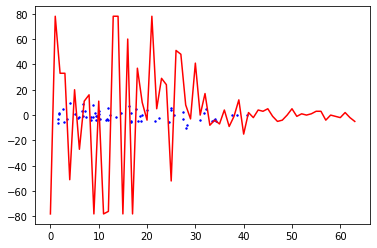

Epoch: 7200 Accurracy real: 0.921875 Accurracy fake: 0.25
Epoch: 7201 Accurracy real: 0.59375 Accurracy fake: 0.515625
Epoch: 7202 Accurracy real: 0.15625 Accurracy fake: 0.59375
Epoch: 7203 Accurracy real: 0.0625 Accurracy fake: 0.78125
Epoch: 7204 Accurracy real: 0.0625 Accurracy fake: 0.875
Epoch: 7205 Accurracy real: 0.0625 Accurracy fake: 0.9375
Epoch: 7206 Accurracy real: 0.0625 Accurracy fake: 0.8125
Epoch: 7207 Accurracy real: 0.078125 Accurracy fake: 0.953125
Epoch: 7208 Accurracy real: 0.015625 Accurracy fake: 0.84375
Epoch: 7209 Accurracy real: 0.046875 Accurracy fake: 0.859375
Epoch: 7210 Accurracy real: 0.734375 Accurracy fake: 0.84375
Epoch: 7211 Accurracy real: 0.046875 Accurracy fake: 0.828125
Epoch: 7212 Accurracy real: 0.0625 Accurracy fake: 0.828125
Epoch: 7213 Accurracy real: 0.109375 Accurracy fake: 0.796875
Epoch: 7214 Accurracy real: 0.109375 Accurracy fake: 0.796875
Epoch: 7215 Accurracy real: 0.078125 Accurracy fake: 0.796875
Epoch: 7216 Accurracy real: 0.17187

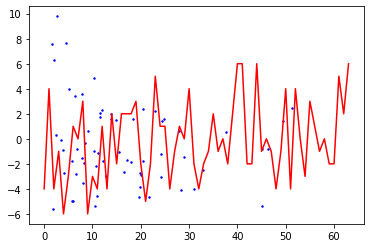

Epoch: 7250 Accurracy real: 0.34375 Accurracy fake: 0.234375
Epoch: 7251 Accurracy real: 0.09375 Accurracy fake: 0.59375
Epoch: 7252 Accurracy real: 0.109375 Accurracy fake: 0.78125
Epoch: 7253 Accurracy real: 0.046875 Accurracy fake: 0.78125
Epoch: 7254 Accurracy real: 0.078125 Accurracy fake: 0.875
Epoch: 7255 Accurracy real: 0.03125 Accurracy fake: 0.859375
Epoch: 7256 Accurracy real: 0.796875 Accurracy fake: 0.734375
Epoch: 7257 Accurracy real: 0.0625 Accurracy fake: 0.734375
Epoch: 7258 Accurracy real: 0.1875 Accurracy fake: 0.75
Epoch: 7259 Accurracy real: 0.34375 Accurracy fake: 0.53125
Epoch: 7260 Accurracy real: 0.515625 Accurracy fake: 0.59375
Epoch: 7261 Accurracy real: 0.65625 Accurracy fake: 0.46875
Epoch: 7262 Accurracy real: 0.6875 Accurracy fake: 0.28125
Epoch: 7263 Accurracy real: 0.8125 Accurracy fake: 0.3125
Epoch: 7264 Accurracy real: 0.84375 Accurracy fake: 0.40625
Epoch: 7265 Accurracy real: 0.734375 Accurracy fake: 0.390625
Epoch: 7266 Accurracy real: 0.640625 Ac

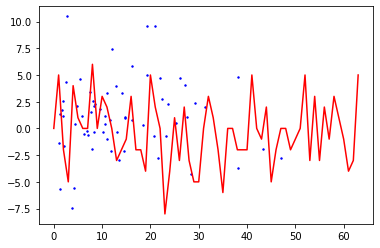

Epoch: 7300 Accurracy real: 0.140625 Accurracy fake: 0.671875
Epoch: 7301 Accurracy real: 0.09375 Accurracy fake: 0.8125
Epoch: 7302 Accurracy real: 0.046875 Accurracy fake: 0.921875
Epoch: 7303 Accurracy real: 0.03125 Accurracy fake: 0.8125
Epoch: 7304 Accurracy real: 0.015625 Accurracy fake: 0.859375
Epoch: 7305 Accurracy real: 0.046875 Accurracy fake: 0.890625
Epoch: 7306 Accurracy real: 0.03125 Accurracy fake: 0.8125
Epoch: 7307 Accurracy real: 0.03125 Accurracy fake: 0.765625
Epoch: 7308 Accurracy real: 0.09375 Accurracy fake: 0.671875
Epoch: 7309 Accurracy real: 0.640625 Accurracy fake: 0.359375
Epoch: 7310 Accurracy real: 0.953125 Accurracy fake: 0.21875
Epoch: 7311 Accurracy real: 0.90625 Accurracy fake: 0.25
Epoch: 7312 Accurracy real: 0.890625 Accurracy fake: 0.15625
Epoch: 7313 Accurracy real: 0.9375 Accurracy fake: 0.203125
Epoch: 7314 Accurracy real: 0.890625 Accurracy fake: 0.203125
Epoch: 7315 Accurracy real: 0.859375 Accurracy fake: 0.125
Epoch: 7316 Accurracy real: 0.8

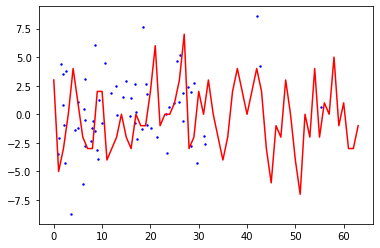

Epoch: 7350 Accurracy real: 0.484375 Accurracy fake: 0.453125
Epoch: 7351 Accurracy real: 0.421875 Accurracy fake: 0.53125
Epoch: 7352 Accurracy real: 0.265625 Accurracy fake: 0.484375
Epoch: 7353 Accurracy real: 0.421875 Accurracy fake: 0.46875
Epoch: 7354 Accurracy real: 0.375 Accurracy fake: 0.5625
Epoch: 7355 Accurracy real: 0.25 Accurracy fake: 0.609375
Epoch: 7356 Accurracy real: 0.3125 Accurracy fake: 0.46875
Epoch: 7357 Accurracy real: 0.375 Accurracy fake: 0.515625
Epoch: 7358 Accurracy real: 0.484375 Accurracy fake: 0.484375
Epoch: 7359 Accurracy real: 0.4375 Accurracy fake: 0.421875
Epoch: 7360 Accurracy real: 0.375 Accurracy fake: 0.546875
Epoch: 7361 Accurracy real: 0.15625 Accurracy fake: 0.546875
Epoch: 7362 Accurracy real: 0.125 Accurracy fake: 0.671875
Epoch: 7363 Accurracy real: 0.09375 Accurracy fake: 0.796875
Epoch: 7364 Accurracy real: 0.09375 Accurracy fake: 0.765625
Epoch: 7365 Accurracy real: 0.0625 Accurracy fake: 0.84375
Epoch: 7366 Accurracy real: 0.0625 Accu

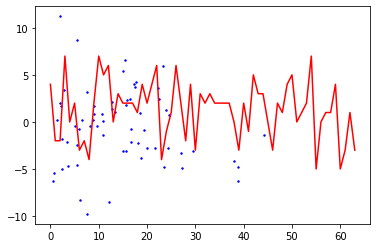

Epoch: 7400 Accurracy real: 0.234375 Accurracy fake: 0.6875
Epoch: 7401 Accurracy real: 0.109375 Accurracy fake: 0.8125
Epoch: 7402 Accurracy real: 0.046875 Accurracy fake: 0.828125
Epoch: 7403 Accurracy real: 0.046875 Accurracy fake: 0.796875
Epoch: 7404 Accurracy real: 0.046875 Accurracy fake: 0.890625
Epoch: 7405 Accurracy real: 0.109375 Accurracy fake: 0.671875
Epoch: 7406 Accurracy real: 0.25 Accurracy fake: 0.609375
Epoch: 7407 Accurracy real: 0.5625 Accurracy fake: 0.375
Epoch: 7408 Accurracy real: 0.71875 Accurracy fake: 0.421875
Epoch: 7409 Accurracy real: 0.765625 Accurracy fake: 0.46875
Epoch: 7410 Accurracy real: 0.828125 Accurracy fake: 0.265625
Epoch: 7411 Accurracy real: 0.828125 Accurracy fake: 0.328125
Epoch: 7412 Accurracy real: 0.875 Accurracy fake: 0.234375
Epoch: 7413 Accurracy real: 0.8125 Accurracy fake: 0.359375
Epoch: 7414 Accurracy real: 0.859375 Accurracy fake: 0.34375
Epoch: 7415 Accurracy real: 0.828125 Accurracy fake: 0.28125
Epoch: 7416 Accurracy real: 0.

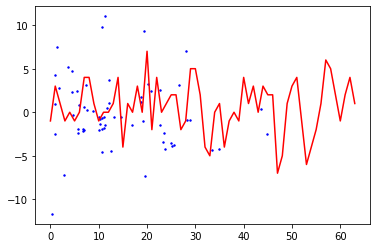

Epoch: 7450 Accurracy real: 0.921875 Accurracy fake: 0.234375
Epoch: 7451 Accurracy real: 0.90625 Accurracy fake: 0.21875
Epoch: 7452 Accurracy real: 0.8125 Accurracy fake: 0.203125
Epoch: 7453 Accurracy real: 0.671875 Accurracy fake: 0.3125
Epoch: 7454 Accurracy real: 0.578125 Accurracy fake: 0.296875
Epoch: 7455 Accurracy real: 0.484375 Accurracy fake: 0.515625
Epoch: 7456 Accurracy real: 0.203125 Accurracy fake: 0.703125
Epoch: 7457 Accurracy real: 0.078125 Accurracy fake: 0.796875
Epoch: 7458 Accurracy real: 0.046875 Accurracy fake: 0.84375
Epoch: 7459 Accurracy real: 0.078125 Accurracy fake: 0.828125
Epoch: 7460 Accurracy real: 0.03125 Accurracy fake: 0.78125
Epoch: 7461 Accurracy real: 0.015625 Accurracy fake: 0.84375
Epoch: 7462 Accurracy real: 0.03125 Accurracy fake: 0.796875
Epoch: 7463 Accurracy real: 0.109375 Accurracy fake: 0.765625
Epoch: 7464 Accurracy real: 0.265625 Accurracy fake: 0.578125
Epoch: 7465 Accurracy real: 0.390625 Accurracy fake: 0.453125
Epoch: 7466 Accurra

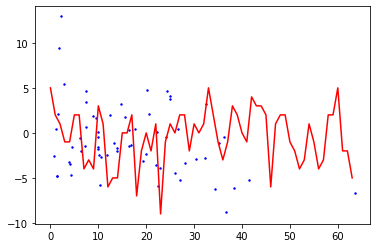

Epoch: 7500 Accurracy real: 0.03125 Accurracy fake: 0.890625
Epoch: 7501 Accurracy real: 0.046875 Accurracy fake: 0.84375
Epoch: 7502 Accurracy real: 0.078125 Accurracy fake: 0.828125
Epoch: 7503 Accurracy real: 0.265625 Accurracy fake: 0.78125
Epoch: 7504 Accurracy real: 0.546875 Accurracy fake: 0.6875
Epoch: 7505 Accurracy real: 0.75 Accurracy fake: 0.453125
Epoch: 7506 Accurracy real: 0.78125 Accurracy fake: 0.40625
Epoch: 7507 Accurracy real: 0.84375 Accurracy fake: 0.4375
Epoch: 7508 Accurracy real: 0.859375 Accurracy fake: 0.34375
Epoch: 7509 Accurracy real: 0.828125 Accurracy fake: 0.328125
Epoch: 7510 Accurracy real: 0.796875 Accurracy fake: 0.5
Epoch: 7511 Accurracy real: 0.53125 Accurracy fake: 0.421875
Epoch: 7512 Accurracy real: 0.328125 Accurracy fake: 0.671875
Epoch: 7513 Accurracy real: 0.171875 Accurracy fake: 0.640625
Epoch: 7514 Accurracy real: 0.0625 Accurracy fake: 0.78125
Epoch: 7515 Accurracy real: 0.171875 Accurracy fake: 0.8125
Epoch: 7516 Accurracy real: 0.0468

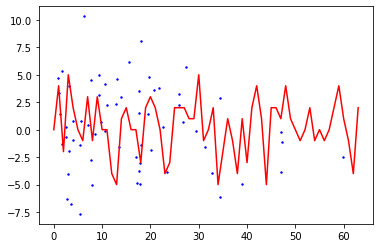

Epoch: 7550 Accurracy real: 0.46875 Accurracy fake: 0.578125
Epoch: 7551 Accurracy real: 0.578125 Accurracy fake: 0.40625
Epoch: 7552 Accurracy real: 0.640625 Accurracy fake: 0.375
Epoch: 7553 Accurracy real: 0.609375 Accurracy fake: 0.34375
Epoch: 7554 Accurracy real: 0.765625 Accurracy fake: 0.421875
Epoch: 7555 Accurracy real: 0.78125 Accurracy fake: 0.390625
Epoch: 7556 Accurracy real: 0.84375 Accurracy fake: 0.1875
Epoch: 7557 Accurracy real: 0.828125 Accurracy fake: 0.3125
Epoch: 7558 Accurracy real: 0.8125 Accurracy fake: 0.203125
Epoch: 7559 Accurracy real: 0.90625 Accurracy fake: 0.234375
Epoch: 7560 Accurracy real: 0.890625 Accurracy fake: 0.234375
Epoch: 7561 Accurracy real: 0.859375 Accurracy fake: 0.15625
Epoch: 7562 Accurracy real: 0.859375 Accurracy fake: 0.234375
Epoch: 7563 Accurracy real: 0.765625 Accurracy fake: 0.265625
Epoch: 7564 Accurracy real: 0.625 Accurracy fake: 0.40625
Epoch: 7565 Accurracy real: 0.34375 Accurracy fake: 0.5
Epoch: 7566 Accurracy real: 0.2031

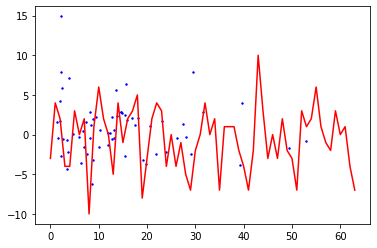

Epoch: 7600 Accurracy real: 0.453125 Accurracy fake: 0.453125
Epoch: 7601 Accurracy real: 0.484375 Accurracy fake: 0.515625
Epoch: 7602 Accurracy real: 0.421875 Accurracy fake: 0.578125
Epoch: 7603 Accurracy real: 0.296875 Accurracy fake: 0.5
Epoch: 7604 Accurracy real: 0.25 Accurracy fake: 0.609375
Epoch: 7605 Accurracy real: 0.3125 Accurracy fake: 0.65625
Epoch: 7606 Accurracy real: 0.140625 Accurracy fake: 0.53125
Epoch: 7607 Accurracy real: 0.1875 Accurracy fake: 0.5625
Epoch: 7608 Accurracy real: 0.28125 Accurracy fake: 0.78125
Epoch: 7609 Accurracy real: 0.3125 Accurracy fake: 0.390625
Epoch: 7610 Accurracy real: 0.34375 Accurracy fake: 0.484375
Epoch: 7611 Accurracy real: 0.390625 Accurracy fake: 0.421875
Epoch: 7612 Accurracy real: 0.484375 Accurracy fake: 0.40625
Epoch: 7613 Accurracy real: 0.4375 Accurracy fake: 0.265625
Epoch: 7614 Accurracy real: 0.59375 Accurracy fake: 0.390625
Epoch: 7615 Accurracy real: 0.59375 Accurracy fake: 0.359375
Epoch: 7616 Accurracy real: 0.45312

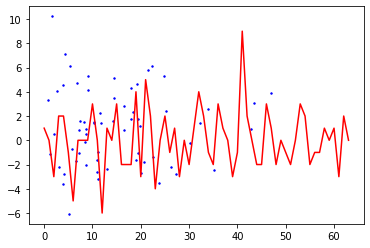

Epoch: 7650 Accurracy real: 0.4375 Accurracy fake: 0.65625
Epoch: 7651 Accurracy real: 0.25 Accurracy fake: 0.71875
Epoch: 7652 Accurracy real: 0.40625 Accurracy fake: 0.75
Epoch: 7653 Accurracy real: 0.34375 Accurracy fake: 0.515625
Epoch: 7654 Accurracy real: 0.46875 Accurracy fake: 0.53125
Epoch: 7655 Accurracy real: 0.375 Accurracy fake: 0.78125
Epoch: 7656 Accurracy real: 0.484375 Accurracy fake: 0.578125
Epoch: 7657 Accurracy real: 0.5625 Accurracy fake: 0.484375
Epoch: 7658 Accurracy real: 0.34375 Accurracy fake: 0.46875
Epoch: 7659 Accurracy real: 0.359375 Accurracy fake: 0.515625
Epoch: 7660 Accurracy real: 0.34375 Accurracy fake: 0.453125
Epoch: 7661 Accurracy real: 0.59375 Accurracy fake: 0.34375
Epoch: 7662 Accurracy real: 0.78125 Accurracy fake: 0.28125
Epoch: 7663 Accurracy real: 0.8125 Accurracy fake: 0.234375
Epoch: 7664 Accurracy real: 0.9375 Accurracy fake: 0.078125
Epoch: 7665 Accurracy real: 0.890625 Accurracy fake: 0.15625
Epoch: 7666 Accurracy real: 0.90625 Accurr

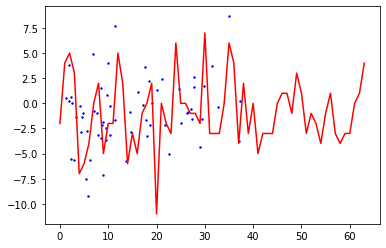

Epoch: 7700 Accurracy real: 0.734375 Accurracy fake: 0.265625
Epoch: 7701 Accurracy real: 0.78125 Accurracy fake: 0.265625
Epoch: 7702 Accurracy real: 0.765625 Accurracy fake: 0.28125
Epoch: 7703 Accurracy real: 0.640625 Accurracy fake: 0.3125
Epoch: 7704 Accurracy real: 0.453125 Accurracy fake: 0.4375
Epoch: 7705 Accurracy real: 0.53125 Accurracy fake: 0.5
Epoch: 7706 Accurracy real: 0.265625 Accurracy fake: 0.625
Epoch: 7707 Accurracy real: 0.296875 Accurracy fake: 0.6875
Epoch: 7708 Accurracy real: 0.25 Accurracy fake: 0.625
Epoch: 7709 Accurracy real: 0.21875 Accurracy fake: 0.765625
Epoch: 7710 Accurracy real: 0.125 Accurracy fake: 0.6875
Epoch: 7711 Accurracy real: 0.1875 Accurracy fake: 0.625
Epoch: 7712 Accurracy real: 0.125 Accurracy fake: 0.59375
Epoch: 7713 Accurracy real: 0.09375 Accurracy fake: 0.796875
Epoch: 7714 Accurracy real: 0.109375 Accurracy fake: 0.90625
Epoch: 7715 Accurracy real: 0.078125 Accurracy fake: 0.828125
Epoch: 7716 Accurracy real: 0.046875 Accurracy fa

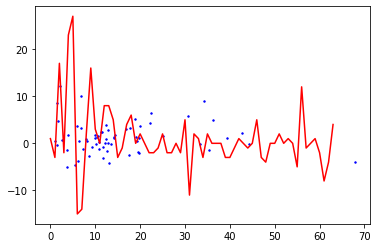

Epoch: 7750 Accurracy real: 0.765625 Accurracy fake: 0.328125
Epoch: 7751 Accurracy real: 0.84375 Accurracy fake: 0.21875
Epoch: 7752 Accurracy real: 0.859375 Accurracy fake: 0.34375
Epoch: 7753 Accurracy real: 0.75 Accurracy fake: 0.328125
Epoch: 7754 Accurracy real: 0.78125 Accurracy fake: 0.328125
Epoch: 7755 Accurracy real: 0.765625 Accurracy fake: 0.328125
Epoch: 7756 Accurracy real: 0.78125 Accurracy fake: 0.34375
Epoch: 7757 Accurracy real: 0.796875 Accurracy fake: 0.328125
Epoch: 7758 Accurracy real: 0.859375 Accurracy fake: 0.296875
Epoch: 7759 Accurracy real: 0.828125 Accurracy fake: 0.4375
Epoch: 7760 Accurracy real: 0.609375 Accurracy fake: 0.453125
Epoch: 7761 Accurracy real: 0.625 Accurracy fake: 0.484375
Epoch: 7762 Accurracy real: 0.703125 Accurracy fake: 0.46875
Epoch: 7763 Accurracy real: 0.6875 Accurracy fake: 0.390625
Epoch: 7764 Accurracy real: 0.59375 Accurracy fake: 0.515625
Epoch: 7765 Accurracy real: 0.609375 Accurracy fake: 0.46875
Epoch: 7766 Accurracy real: 

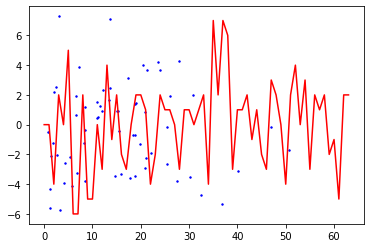

Epoch: 7800 Accurracy real: 0.28125 Accurracy fake: 0.5625
Epoch: 7801 Accurracy real: 0.171875 Accurracy fake: 0.578125
Epoch: 7802 Accurracy real: 0.0625 Accurracy fake: 0.65625
Epoch: 7803 Accurracy real: 0.109375 Accurracy fake: 0.8125
Epoch: 7804 Accurracy real: 0.09375 Accurracy fake: 0.921875
Epoch: 7805 Accurracy real: 0.140625 Accurracy fake: 0.78125
Epoch: 7806 Accurracy real: 0.078125 Accurracy fake: 0.796875
Epoch: 7807 Accurracy real: 0.1875 Accurracy fake: 0.671875
Epoch: 7808 Accurracy real: 0.265625 Accurracy fake: 0.28125
Epoch: 7809 Accurracy real: 0.359375 Accurracy fake: 0.40625
Epoch: 7810 Accurracy real: 0.46875 Accurracy fake: 0.3125
Epoch: 7811 Accurracy real: 0.796875 Accurracy fake: 0.359375
Epoch: 7812 Accurracy real: 0.921875 Accurracy fake: 0.265625
Epoch: 7813 Accurracy real: 0.671875 Accurracy fake: 0.515625
Epoch: 7814 Accurracy real: 0.25 Accurracy fake: 0.625
Epoch: 7815 Accurracy real: 0.15625 Accurracy fake: 0.703125
Epoch: 7816 Accurracy real: 0.093

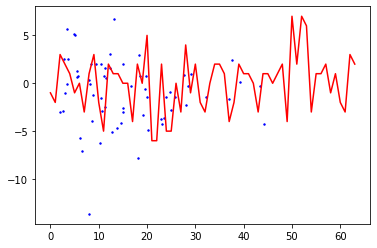

Epoch: 7850 Accurracy real: 0.828125 Accurracy fake: 0.21875
Epoch: 7851 Accurracy real: 0.953125 Accurracy fake: 0.3125
Epoch: 7852 Accurracy real: 0.890625 Accurracy fake: 0.21875
Epoch: 7853 Accurracy real: 0.90625 Accurracy fake: 0.203125
Epoch: 7854 Accurracy real: 0.90625 Accurracy fake: 0.28125
Epoch: 7855 Accurracy real: 0.78125 Accurracy fake: 0.375
Epoch: 7856 Accurracy real: 0.640625 Accurracy fake: 0.578125
Epoch: 7857 Accurracy real: 0.5625 Accurracy fake: 0.515625
Epoch: 7858 Accurracy real: 0.546875 Accurracy fake: 0.546875
Epoch: 7859 Accurracy real: 0.390625 Accurracy fake: 0.609375
Epoch: 7860 Accurracy real: 0.453125 Accurracy fake: 0.578125
Epoch: 7861 Accurracy real: 0.328125 Accurracy fake: 0.578125
Epoch: 7862 Accurracy real: 0.421875 Accurracy fake: 0.53125
Epoch: 7863 Accurracy real: 0.4375 Accurracy fake: 0.59375
Epoch: 7864 Accurracy real: 0.3125 Accurracy fake: 0.6875
Epoch: 7865 Accurracy real: 0.578125 Accurracy fake: 0.796875
Epoch: 7866 Accurracy real: 0

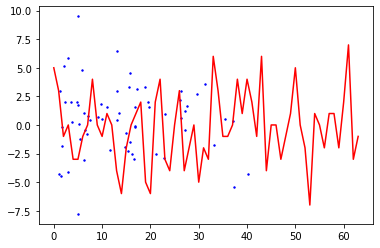

Epoch: 7900 Accurracy real: 0.890625 Accurracy fake: 0.15625
Epoch: 7901 Accurracy real: 0.921875 Accurracy fake: 0.171875
Epoch: 7902 Accurracy real: 0.90625 Accurracy fake: 0.140625
Epoch: 7903 Accurracy real: 0.9375 Accurracy fake: 0.171875
Epoch: 7904 Accurracy real: 0.90625 Accurracy fake: 0.15625
Epoch: 7905 Accurracy real: 0.90625 Accurracy fake: 0.140625
Epoch: 7906 Accurracy real: 0.9375 Accurracy fake: 0.296875
Epoch: 7907 Accurracy real: 0.65625 Accurracy fake: 0.296875
Epoch: 7908 Accurracy real: 0.8125 Accurracy fake: 0.40625
Epoch: 7909 Accurracy real: 0.34375 Accurracy fake: 0.5
Epoch: 7910 Accurracy real: 0.34375 Accurracy fake: 0.515625
Epoch: 7911 Accurracy real: 0.28125 Accurracy fake: 0.609375
Epoch: 7912 Accurracy real: 0.359375 Accurracy fake: 0.609375
Epoch: 7913 Accurracy real: 0.484375 Accurracy fake: 0.625
Epoch: 7914 Accurracy real: 0.59375 Accurracy fake: 0.4375
Epoch: 7915 Accurracy real: 0.4375 Accurracy fake: 0.546875
Epoch: 7916 Accurracy real: 0.5 Accur

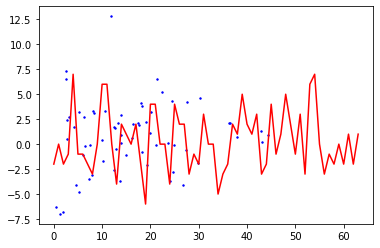

Epoch: 7950 Accurracy real: 0.828125 Accurracy fake: 0.3125
Epoch: 7951 Accurracy real: 0.859375 Accurracy fake: 0.234375
Epoch: 7952 Accurracy real: 0.8125 Accurracy fake: 0.234375
Epoch: 7953 Accurracy real: 0.84375 Accurracy fake: 0.390625
Epoch: 7954 Accurracy real: 0.71875 Accurracy fake: 0.375
Epoch: 7955 Accurracy real: 0.6875 Accurracy fake: 0.40625
Epoch: 7956 Accurracy real: 0.640625 Accurracy fake: 0.328125
Epoch: 7957 Accurracy real: 0.65625 Accurracy fake: 0.484375
Epoch: 7958 Accurracy real: 0.734375 Accurracy fake: 0.53125
Epoch: 7959 Accurracy real: 0.5625 Accurracy fake: 0.453125
Epoch: 7960 Accurracy real: 0.46875 Accurracy fake: 0.453125
Epoch: 7961 Accurracy real: 0.40625 Accurracy fake: 0.65625
Epoch: 7962 Accurracy real: 0.140625 Accurracy fake: 0.65625
Epoch: 7963 Accurracy real: 0.078125 Accurracy fake: 0.875
Epoch: 7964 Accurracy real: 0.078125 Accurracy fake: 0.859375
Epoch: 7965 Accurracy real: 0.046875 Accurracy fake: 0.796875
Epoch: 7966 Accurracy real: 0.0

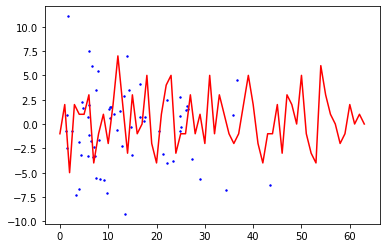

Epoch: 8000 Accurracy real: 0.71875 Accurracy fake: 0.484375
Epoch: 8001 Accurracy real: 0.828125 Accurracy fake: 0.40625
Epoch: 8002 Accurracy real: 0.8125 Accurracy fake: 0.21875
Epoch: 8003 Accurracy real: 0.890625 Accurracy fake: 0.359375
Epoch: 8004 Accurracy real: 0.875 Accurracy fake: 0.34375
Epoch: 8005 Accurracy real: 0.921875 Accurracy fake: 0.21875
Epoch: 8006 Accurracy real: 0.953125 Accurracy fake: 0.21875
Epoch: 8007 Accurracy real: 0.90625 Accurracy fake: 0.15625
Epoch: 8008 Accurracy real: 0.921875 Accurracy fake: 0.171875
Epoch: 8009 Accurracy real: 0.9375 Accurracy fake: 0.234375
Epoch: 8010 Accurracy real: 0.90625 Accurracy fake: 0.15625
Epoch: 8011 Accurracy real: 0.90625 Accurracy fake: 0.140625
Epoch: 8012 Accurracy real: 0.859375 Accurracy fake: 0.125
Epoch: 8013 Accurracy real: 0.6875 Accurracy fake: 0.515625
Epoch: 8014 Accurracy real: 0.203125 Accurracy fake: 0.671875
Epoch: 8015 Accurracy real: 0.078125 Accurracy fake: 0.859375
Epoch: 8016 Accurracy real: 0.0

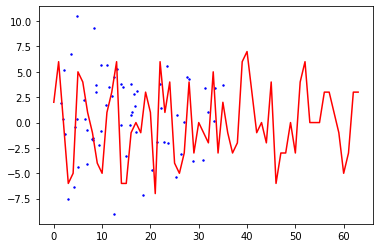

Epoch: 8050 Accurracy real: 0.09375 Accurracy fake: 0.859375
Epoch: 8051 Accurracy real: 0.03125 Accurracy fake: 0.765625
Epoch: 8052 Accurracy real: 0.109375 Accurracy fake: 0.796875
Epoch: 8053 Accurracy real: 0.484375 Accurracy fake: 0.328125
Epoch: 8054 Accurracy real: 0.875 Accurracy fake: 0.234375
Epoch: 8055 Accurracy real: 0.84375 Accurracy fake: 0.1875
Epoch: 8056 Accurracy real: 0.921875 Accurracy fake: 0.171875
Epoch: 8057 Accurracy real: 0.796875 Accurracy fake: 0.234375
Epoch: 8058 Accurracy real: 0.703125 Accurracy fake: 0.28125
Epoch: 8059 Accurracy real: 0.53125 Accurracy fake: 0.4375
Epoch: 8060 Accurracy real: 0.21875 Accurracy fake: 0.578125
Epoch: 8061 Accurracy real: 0.125 Accurracy fake: 0.734375
Epoch: 8062 Accurracy real: 0.109375 Accurracy fake: 0.796875
Epoch: 8063 Accurracy real: 0.28125 Accurracy fake: 0.734375
Epoch: 8064 Accurracy real: 0.21875 Accurracy fake: 0.6875
Epoch: 8065 Accurracy real: 0.1875 Accurracy fake: 0.671875
Epoch: 8066 Accurracy real: 0.

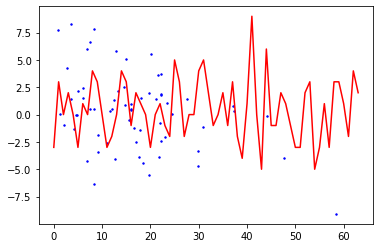

Epoch: 8100 Accurracy real: 0.9375 Accurracy fake: 0.25
Epoch: 8101 Accurracy real: 0.921875 Accurracy fake: 0.28125
Epoch: 8102 Accurracy real: 0.875 Accurracy fake: 0.203125
Epoch: 8103 Accurracy real: 0.9375 Accurracy fake: 0.265625
Epoch: 8104 Accurracy real: 0.875 Accurracy fake: 0.28125
Epoch: 8105 Accurracy real: 0.84375 Accurracy fake: 0.28125
Epoch: 8106 Accurracy real: 0.890625 Accurracy fake: 0.390625
Epoch: 8107 Accurracy real: 0.421875 Accurracy fake: 0.890625
Epoch: 8108 Accurracy real: 0.015625 Accurracy fake: 0.890625
Epoch: 8109 Accurracy real: 0.03125 Accurracy fake: 0.875
Epoch: 8110 Accurracy real: 0.03125 Accurracy fake: 0.84375
Epoch: 8111 Accurracy real: 0.015625 Accurracy fake: 0.90625
Epoch: 8112 Accurracy real: 0.046875 Accurracy fake: 0.90625
Epoch: 8113 Accurracy real: 0.046875 Accurracy fake: 0.84375
Epoch: 8114 Accurracy real: 0.03125 Accurracy fake: 0.828125
Epoch: 8115 Accurracy real: 0.078125 Accurracy fake: 0.875
Epoch: 8116 Accurracy real: 0.15625 Acc

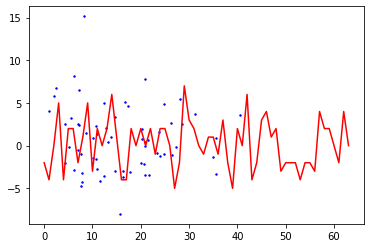

Epoch: 8150 Accurracy real: 0.6875 Accurracy fake: 0.546875
Epoch: 8151 Accurracy real: 0.484375 Accurracy fake: 0.546875
Epoch: 8152 Accurracy real: 0.296875 Accurracy fake: 0.71875
Epoch: 8153 Accurracy real: 0.25 Accurracy fake: 0.6875
Epoch: 8154 Accurracy real: 0.28125 Accurracy fake: 0.6875
Epoch: 8155 Accurracy real: 0.3125 Accurracy fake: 0.59375
Epoch: 8156 Accurracy real: 0.296875 Accurracy fake: 0.71875
Epoch: 8157 Accurracy real: 0.640625 Accurracy fake: 0.390625
Epoch: 8158 Accurracy real: 0.8125 Accurracy fake: 0.21875
Epoch: 8159 Accurracy real: 0.9375 Accurracy fake: 0.109375
Epoch: 8160 Accurracy real: 0.875 Accurracy fake: 0.171875
Epoch: 8161 Accurracy real: 0.890625 Accurracy fake: 0.3125
Epoch: 8162 Accurracy real: 0.875 Accurracy fake: 0.296875
Epoch: 8163 Accurracy real: 0.734375 Accurracy fake: 0.453125
Epoch: 8164 Accurracy real: 0.734375 Accurracy fake: 0.390625
Epoch: 8165 Accurracy real: 0.765625 Accurracy fake: 0.5
Epoch: 8166 Accurracy real: 0.578125 Accur

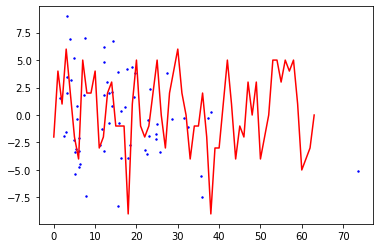

Epoch: 8200 Accurracy real: 0.046875 Accurracy fake: 0.953125
Epoch: 8201 Accurracy real: 0.046875 Accurracy fake: 0.875
Epoch: 8202 Accurracy real: 0.015625 Accurracy fake: 0.90625
Epoch: 8203 Accurracy real: 0.0625 Accurracy fake: 0.9375
Epoch: 8204 Accurracy real: 0.046875 Accurracy fake: 0.875
Epoch: 8205 Accurracy real: 0.875 Accurracy fake: 0.328125
Epoch: 8206 Accurracy real: 0.828125 Accurracy fake: 0.203125
Epoch: 8207 Accurracy real: 0.9375 Accurracy fake: 0.203125
Epoch: 8208 Accurracy real: 0.859375 Accurracy fake: 0.203125
Epoch: 8209 Accurracy real: 0.9375 Accurracy fake: 0.1875
Epoch: 8210 Accurracy real: 0.734375 Accurracy fake: 0.40625
Epoch: 8211 Accurracy real: 0.515625 Accurracy fake: 0.546875
Epoch: 8212 Accurracy real: 0.296875 Accurracy fake: 0.75
Epoch: 8213 Accurracy real: 0.484375 Accurracy fake: 0.546875
Epoch: 8214 Accurracy real: 0.734375 Accurracy fake: 0.5
Epoch: 8215 Accurracy real: 0.765625 Accurracy fake: 0.375
Epoch: 8216 Accurracy real: 0.890625 Accu

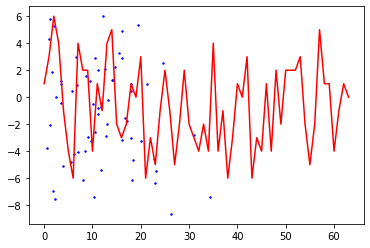

Epoch: 8250 Accurracy real: 0.09375 Accurracy fake: 0.859375
Epoch: 8251 Accurracy real: 0.03125 Accurracy fake: 0.828125
Epoch: 8252 Accurracy real: 0.109375 Accurracy fake: 0.84375
Epoch: 8253 Accurracy real: 0.21875 Accurracy fake: 0.90625
Epoch: 8254 Accurracy real: 0.078125 Accurracy fake: 0.875
Epoch: 8255 Accurracy real: 0.140625 Accurracy fake: 0.84375
Epoch: 8256 Accurracy real: 0.71875 Accurracy fake: 0.46875
Epoch: 8257 Accurracy real: 0.84375 Accurracy fake: 0.15625
Epoch: 8258 Accurracy real: 0.875 Accurracy fake: 0.078125
Epoch: 8259 Accurracy real: 0.90625 Accurracy fake: 0.140625
Epoch: 8260 Accurracy real: 0.875 Accurracy fake: 0.125
Epoch: 8261 Accurracy real: 0.921875 Accurracy fake: 0.203125
Epoch: 8262 Accurracy real: 0.9375 Accurracy fake: 0.125
Epoch: 8263 Accurracy real: 0.875 Accurracy fake: 0.21875
Epoch: 8264 Accurracy real: 0.875 Accurracy fake: 0.171875
Epoch: 8265 Accurracy real: 0.921875 Accurracy fake: 0.1875
Epoch: 8266 Accurracy real: 0.796875 Accurrac

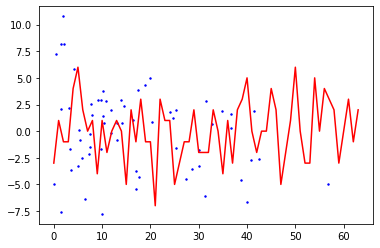

Epoch: 8300 Accurracy real: 0.265625 Accurracy fake: 0.65625
Epoch: 8301 Accurracy real: 0.1875 Accurracy fake: 0.71875
Epoch: 8302 Accurracy real: 0.078125 Accurracy fake: 0.625
Epoch: 8303 Accurracy real: 0.0625 Accurracy fake: 0.8125
Epoch: 8304 Accurracy real: 0.0625 Accurracy fake: 0.828125
Epoch: 8305 Accurracy real: 0.421875 Accurracy fake: 0.53125
Epoch: 8306 Accurracy real: 0.84375 Accurracy fake: 0.25
Epoch: 8307 Accurracy real: 0.953125 Accurracy fake: 0.0625
Epoch: 8308 Accurracy real: 0.90625 Accurracy fake: 0.15625
Epoch: 8309 Accurracy real: 0.921875 Accurracy fake: 0.171875
Epoch: 8310 Accurracy real: 0.890625 Accurracy fake: 0.15625
Epoch: 8311 Accurracy real: 0.890625 Accurracy fake: 0.21875
Epoch: 8312 Accurracy real: 0.703125 Accurracy fake: 0.421875
Epoch: 8313 Accurracy real: 0.515625 Accurracy fake: 0.484375
Epoch: 8314 Accurracy real: 0.484375 Accurracy fake: 0.625
Epoch: 8315 Accurracy real: 0.125 Accurracy fake: 0.703125
Epoch: 8316 Accurracy real: 0.3125 Accu

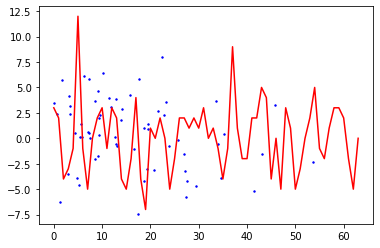

Epoch: 8350 Accurracy real: 0.953125 Accurracy fake: 0.09375
Epoch: 8351 Accurracy real: 0.90625 Accurracy fake: 0.265625
Epoch: 8352 Accurracy real: 0.875 Accurracy fake: 0.359375
Epoch: 8353 Accurracy real: 0.84375 Accurracy fake: 0.25
Epoch: 8354 Accurracy real: 0.875 Accurracy fake: 0.328125
Epoch: 8355 Accurracy real: 0.9375 Accurracy fake: 0.140625
Epoch: 8356 Accurracy real: 0.921875 Accurracy fake: 0.1875
Epoch: 8357 Accurracy real: 0.953125 Accurracy fake: 0.15625
Epoch: 8358 Accurracy real: 0.890625 Accurracy fake: 0.1875
Epoch: 8359 Accurracy real: 0.90625 Accurracy fake: 0.21875
Epoch: 8360 Accurracy real: 0.890625 Accurracy fake: 0.25
Epoch: 8361 Accurracy real: 0.84375 Accurracy fake: 0.328125
Epoch: 8362 Accurracy real: 0.40625 Accurracy fake: 0.71875
Epoch: 8363 Accurracy real: 0.03125 Accurracy fake: 0.828125
Epoch: 8364 Accurracy real: 0.0625 Accurracy fake: 0.875
Epoch: 8365 Accurracy real: 0.03125 Accurracy fake: 0.875
Epoch: 8366 Accurracy real: 0.0625 Accurracy fa

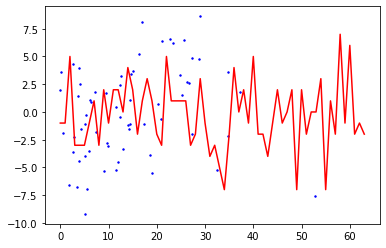

Epoch: 8400 Accurracy real: 0.890625 Accurracy fake: 0.296875
Epoch: 8401 Accurracy real: 0.9375 Accurracy fake: 0.3125
Epoch: 8402 Accurracy real: 0.875 Accurracy fake: 0.328125
Epoch: 8403 Accurracy real: 0.78125 Accurracy fake: 0.34375
Epoch: 8404 Accurracy real: 0.671875 Accurracy fake: 0.453125
Epoch: 8405 Accurracy real: 0.421875 Accurracy fake: 0.578125
Epoch: 8406 Accurracy real: 0.21875 Accurracy fake: 0.6875
Epoch: 8407 Accurracy real: 0.03125 Accurracy fake: 0.90625
Epoch: 8408 Accurracy real: 0.078125 Accurracy fake: 0.90625
Epoch: 8409 Accurracy real: 0.109375 Accurracy fake: 0.953125
Epoch: 8410 Accurracy real: 0.046875 Accurracy fake: 0.890625
Epoch: 8411 Accurracy real: 0.078125 Accurracy fake: 0.890625
Epoch: 8412 Accurracy real: 0.03125 Accurracy fake: 0.890625
Epoch: 8413 Accurracy real: 0.015625 Accurracy fake: 0.859375
Epoch: 8414 Accurracy real: 0.15625 Accurracy fake: 0.75
Epoch: 8415 Accurracy real: 0.234375 Accurracy fake: 0.671875
Epoch: 8416 Accurracy real: 0

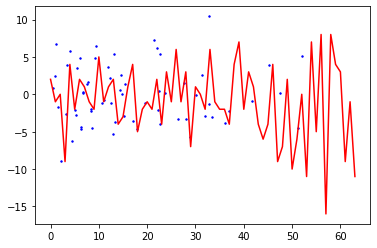

Epoch: 8450 Accurracy real: 0.5625 Accurracy fake: 0.46875
Epoch: 8451 Accurracy real: 0.671875 Accurracy fake: 0.359375
Epoch: 8452 Accurracy real: 0.734375 Accurracy fake: 0.515625
Epoch: 8453 Accurracy real: 0.65625 Accurracy fake: 0.46875
Epoch: 8454 Accurracy real: 0.59375 Accurracy fake: 0.40625
Epoch: 8455 Accurracy real: 0.65625 Accurracy fake: 0.40625
Epoch: 8456 Accurracy real: 0.703125 Accurracy fake: 0.375
Epoch: 8457 Accurracy real: 0.796875 Accurracy fake: 0.453125
Epoch: 8458 Accurracy real: 0.8125 Accurracy fake: 0.53125
Epoch: 8459 Accurracy real: 0.703125 Accurracy fake: 0.4375
Epoch: 8460 Accurracy real: 0.53125 Accurracy fake: 0.53125
Epoch: 8461 Accurracy real: 0.609375 Accurracy fake: 0.46875
Epoch: 8462 Accurracy real: 0.390625 Accurracy fake: 0.546875
Epoch: 8463 Accurracy real: 0.1875 Accurracy fake: 0.671875
Epoch: 8464 Accurracy real: 0.140625 Accurracy fake: 0.71875
Epoch: 8465 Accurracy real: 0.109375 Accurracy fake: 0.828125
Epoch: 8466 Accurracy real: 0.0

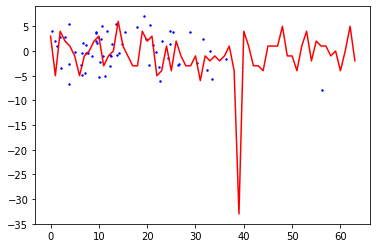

Epoch: 8500 Accurracy real: 0.59375 Accurracy fake: 0.484375
Epoch: 8501 Accurracy real: 0.4375 Accurracy fake: 0.515625
Epoch: 8502 Accurracy real: 0.171875 Accurracy fake: 0.671875
Epoch: 8503 Accurracy real: 0.15625 Accurracy fake: 0.6875
Epoch: 8504 Accurracy real: 0.1875 Accurracy fake: 0.78125
Epoch: 8505 Accurracy real: 0.09375 Accurracy fake: 0.78125
Epoch: 8506 Accurracy real: 0.078125 Accurracy fake: 0.8125
Epoch: 8507 Accurracy real: 0.015625 Accurracy fake: 0.890625
Epoch: 8508 Accurracy real: 0.0625 Accurracy fake: 0.859375
Epoch: 8509 Accurracy real: 0.046875 Accurracy fake: 0.875
Epoch: 8510 Accurracy real: 0.0625 Accurracy fake: 0.890625
Epoch: 8511 Accurracy real: 0.015625 Accurracy fake: 0.875
Epoch: 8512 Accurracy real: 0.109375 Accurracy fake: 0.828125
Epoch: 8513 Accurracy real: 0.125 Accurracy fake: 0.734375
Epoch: 8514 Accurracy real: 0.140625 Accurracy fake: 0.65625
Epoch: 8515 Accurracy real: 0.265625 Accurracy fake: 0.734375
Epoch: 8516 Accurracy real: 0.35937

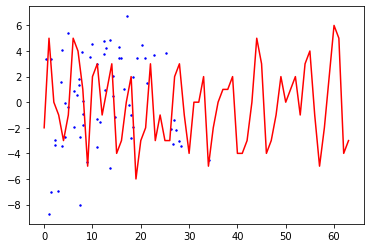

Epoch: 8550 Accurracy real: 0.34375 Accurracy fake: 0.671875
Epoch: 8551 Accurracy real: 0.4375 Accurracy fake: 0.5625
Epoch: 8552 Accurracy real: 0.25 Accurracy fake: 0.625
Epoch: 8553 Accurracy real: 0.265625 Accurracy fake: 0.546875
Epoch: 8554 Accurracy real: 0.15625 Accurracy fake: 0.75
Epoch: 8555 Accurracy real: 0.25 Accurracy fake: 0.546875
Epoch: 8556 Accurracy real: 0.109375 Accurracy fake: 0.765625
Epoch: 8557 Accurracy real: 0.234375 Accurracy fake: 0.671875
Epoch: 8558 Accurracy real: 0.21875 Accurracy fake: 0.734375
Epoch: 8559 Accurracy real: 0.25 Accurracy fake: 0.59375
Epoch: 8560 Accurracy real: 0.390625 Accurracy fake: 0.5625
Epoch: 8561 Accurracy real: 0.46875 Accurracy fake: 0.5
Epoch: 8562 Accurracy real: 0.703125 Accurracy fake: 0.453125
Epoch: 8563 Accurracy real: 0.828125 Accurracy fake: 0.359375
Epoch: 8564 Accurracy real: 0.75 Accurracy fake: 0.375
Epoch: 8565 Accurracy real: 0.796875 Accurracy fake: 0.3125
Epoch: 8566 Accurracy real: 0.78125 Accurracy fake: 

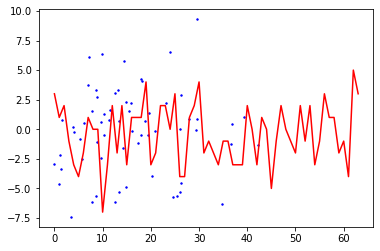

Epoch: 8600 Accurracy real: 0.390625 Accurracy fake: 0.515625
Epoch: 8601 Accurracy real: 0.359375 Accurracy fake: 0.484375
Epoch: 8602 Accurracy real: 0.46875 Accurracy fake: 0.5
Epoch: 8603 Accurracy real: 0.421875 Accurracy fake: 0.515625
Epoch: 8604 Accurracy real: 0.359375 Accurracy fake: 0.5
Epoch: 8605 Accurracy real: 0.203125 Accurracy fake: 0.6875
Epoch: 8606 Accurracy real: 0.078125 Accurracy fake: 0.671875
Epoch: 8607 Accurracy real: 0.40625 Accurracy fake: 0.609375
Epoch: 8608 Accurracy real: 0.0625 Accurracy fake: 0.75
Epoch: 8609 Accurracy real: 0.0625 Accurracy fake: 0.78125
Epoch: 8610 Accurracy real: 0.140625 Accurracy fake: 0.78125
Epoch: 8611 Accurracy real: 0.0625 Accurracy fake: 0.828125
Epoch: 8612 Accurracy real: 0.109375 Accurracy fake: 0.765625
Epoch: 8613 Accurracy real: 0.109375 Accurracy fake: 0.765625
Epoch: 8614 Accurracy real: 0.109375 Accurracy fake: 0.8125
Epoch: 8615 Accurracy real: 0.078125 Accurracy fake: 0.78125
Epoch: 8616 Accurracy real: 0.15625 A

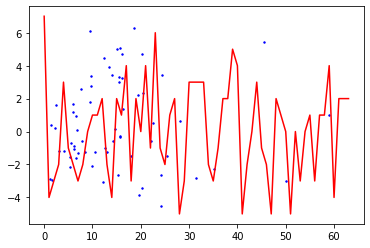

Epoch: 8650 Accurracy real: 0.234375 Accurracy fake: 0.515625
Epoch: 8651 Accurracy real: 0.203125 Accurracy fake: 0.6875
Epoch: 8652 Accurracy real: 0.265625 Accurracy fake: 0.6875
Epoch: 8653 Accurracy real: 0.25 Accurracy fake: 0.546875
Epoch: 8654 Accurracy real: 0.25 Accurracy fake: 0.671875
Epoch: 8655 Accurracy real: 0.296875 Accurracy fake: 0.53125
Epoch: 8656 Accurracy real: 0.421875 Accurracy fake: 0.71875
Epoch: 8657 Accurracy real: 0.234375 Accurracy fake: 0.59375
Epoch: 8658 Accurracy real: 0.4375 Accurracy fake: 0.484375
Epoch: 8659 Accurracy real: 0.53125 Accurracy fake: 0.578125
Epoch: 8660 Accurracy real: 0.765625 Accurracy fake: 0.4375
Epoch: 8661 Accurracy real: 0.75 Accurracy fake: 0.390625
Epoch: 8662 Accurracy real: 0.84375 Accurracy fake: 0.234375
Epoch: 8663 Accurracy real: 0.953125 Accurracy fake: 0.1875
Epoch: 8664 Accurracy real: 0.84375 Accurracy fake: 0.296875
Epoch: 8665 Accurracy real: 0.890625 Accurracy fake: 0.21875
Epoch: 8666 Accurracy real: 0.921875 

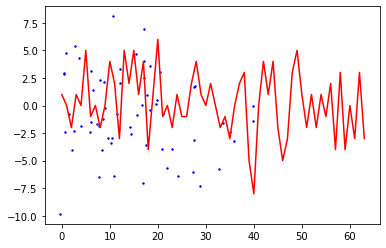

Epoch: 8700 Accurracy real: 0.890625 Accurracy fake: 0.265625
Epoch: 8701 Accurracy real: 0.9375 Accurracy fake: 0.203125
Epoch: 8702 Accurracy real: 0.78125 Accurracy fake: 0.28125
Epoch: 8703 Accurracy real: 0.828125 Accurracy fake: 0.203125
Epoch: 8704 Accurracy real: 0.75 Accurracy fake: 0.4375
Epoch: 8705 Accurracy real: 0.796875 Accurracy fake: 0.40625
Epoch: 8706 Accurracy real: 0.8125 Accurracy fake: 0.359375
Epoch: 8707 Accurracy real: 0.859375 Accurracy fake: 0.21875
Epoch: 8708 Accurracy real: 0.84375 Accurracy fake: 0.234375
Epoch: 8709 Accurracy real: 0.9375 Accurracy fake: 0.34375
Epoch: 8710 Accurracy real: 0.875 Accurracy fake: 0.203125
Epoch: 8711 Accurracy real: 0.90625 Accurracy fake: 0.1875
Epoch: 8712 Accurracy real: 0.921875 Accurracy fake: 0.25
Epoch: 8713 Accurracy real: 0.921875 Accurracy fake: 0.328125
Epoch: 8714 Accurracy real: 0.75 Accurracy fake: 0.359375
Epoch: 8715 Accurracy real: 0.5625 Accurracy fake: 0.4375
Epoch: 8716 Accurracy real: 0.28125 Accurrac

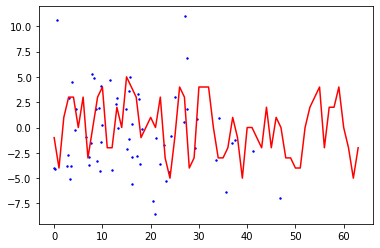

Epoch: 8750 Accurracy real: 0.0625 Accurracy fake: 0.8125
Epoch: 8751 Accurracy real: 0.078125 Accurracy fake: 0.875
Epoch: 8752 Accurracy real: 0.03125 Accurracy fake: 0.828125
Epoch: 8753 Accurracy real: 0.078125 Accurracy fake: 0.734375
Epoch: 8754 Accurracy real: 0.1875 Accurracy fake: 0.5
Epoch: 8755 Accurracy real: 0.390625 Accurracy fake: 0.4375
Epoch: 8756 Accurracy real: 0.484375 Accurracy fake: 0.484375
Epoch: 8757 Accurracy real: 0.65625 Accurracy fake: 0.3125
Epoch: 8758 Accurracy real: 0.703125 Accurracy fake: 0.3125
Epoch: 8759 Accurracy real: 0.5625 Accurracy fake: 0.359375
Epoch: 8760 Accurracy real: 0.59375 Accurracy fake: 0.484375
Epoch: 8761 Accurracy real: 0.5625 Accurracy fake: 0.5
Epoch: 8762 Accurracy real: 0.46875 Accurracy fake: 0.46875
Epoch: 8763 Accurracy real: 0.65625 Accurracy fake: 0.390625
Epoch: 8764 Accurracy real: 0.484375 Accurracy fake: 0.53125
Epoch: 8765 Accurracy real: 0.578125 Accurracy fake: 0.4375
Epoch: 8766 Accurracy real: 0.609375 Accurracy

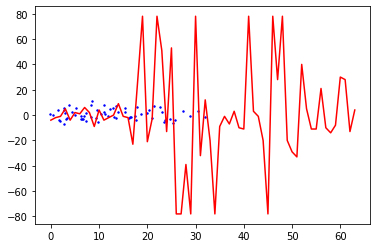

Epoch: 8800 Accurracy real: 0.046875 Accurracy fake: 0.796875
Epoch: 8801 Accurracy real: 0.0625 Accurracy fake: 0.875
Epoch: 8802 Accurracy real: 0.046875 Accurracy fake: 0.875
Epoch: 8803 Accurracy real: 0.125 Accurracy fake: 0.90625
Epoch: 8804 Accurracy real: 0.296875 Accurracy fake: 0.84375
Epoch: 8805 Accurracy real: 0.03125 Accurracy fake: 0.828125
Epoch: 8806 Accurracy real: 0.0625 Accurracy fake: 0.859375
Epoch: 8807 Accurracy real: 0.6875 Accurracy fake: 0.84375
Epoch: 8808 Accurracy real: 0.09375 Accurracy fake: 0.78125
Epoch: 8809 Accurracy real: 0.09375 Accurracy fake: 0.921875
Epoch: 8810 Accurracy real: 0.0625 Accurracy fake: 0.921875
Epoch: 8811 Accurracy real: 0.484375 Accurracy fake: 0.859375
Epoch: 8812 Accurracy real: 0.046875 Accurracy fake: 0.828125
Epoch: 8813 Accurracy real: 0.0625 Accurracy fake: 0.8125
Epoch: 8814 Accurracy real: 0.28125 Accurracy fake: 0.625
Epoch: 8815 Accurracy real: 0.765625 Accurracy fake: 0.5
Epoch: 8816 Accurracy real: 0.890625 Accurrac

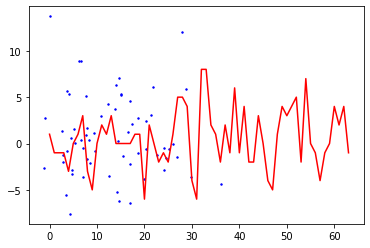

Epoch: 8850 Accurracy real: 0.71875 Accurracy fake: 0.484375
Epoch: 8851 Accurracy real: 0.59375 Accurracy fake: 0.46875
Epoch: 8852 Accurracy real: 0.65625 Accurracy fake: 0.5
Epoch: 8853 Accurracy real: 0.5 Accurracy fake: 0.484375
Epoch: 8854 Accurracy real: 0.421875 Accurracy fake: 0.640625
Epoch: 8855 Accurracy real: 0.234375 Accurracy fake: 0.6875
Epoch: 8856 Accurracy real: 0.03125 Accurracy fake: 0.9375
Epoch: 8857 Accurracy real: 0.046875 Accurracy fake: 0.84375
Epoch: 8858 Accurracy real: 0.046875 Accurracy fake: 0.875
Epoch: 8859 Accurracy real: 0.71875 Accurracy fake: 0.828125
Epoch: 8860 Accurracy real: 0.03125 Accurracy fake: 0.90625
Epoch: 8861 Accurracy real: 0.046875 Accurracy fake: 0.84375
Epoch: 8862 Accurracy real: 0.015625 Accurracy fake: 0.890625
Epoch: 8863 Accurracy real: 0.046875 Accurracy fake: 0.875
Epoch: 8864 Accurracy real: 0.109375 Accurracy fake: 0.703125
Epoch: 8865 Accurracy real: 0.375 Accurracy fake: 0.578125
Epoch: 8866 Accurracy real: 0.8125 Accurr

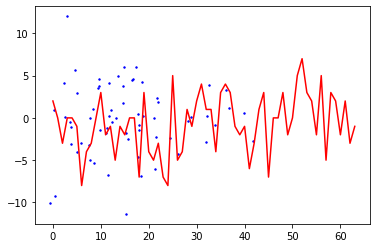

Epoch: 8900 Accurracy real: 0.953125 Accurracy fake: 0.3125
Epoch: 8901 Accurracy real: 0.890625 Accurracy fake: 0.34375
Epoch: 8902 Accurracy real: 0.78125 Accurracy fake: 0.3125
Epoch: 8903 Accurracy real: 0.828125 Accurracy fake: 0.40625
Epoch: 8904 Accurracy real: 0.703125 Accurracy fake: 0.75
Epoch: 8905 Accurracy real: 0.03125 Accurracy fake: 0.796875
Epoch: 8906 Accurracy real: 0.015625 Accurracy fake: 0.875
Epoch: 8907 Accurracy real: 0.015625 Accurracy fake: 0.84375
Epoch: 8908 Accurracy real: 0.25 Accurracy fake: 0.890625
Epoch: 8909 Accurracy real: 0.03125 Accurracy fake: 0.90625
Epoch: 8910 Accurracy real: 0.03125 Accurracy fake: 0.90625
Epoch: 8911 Accurracy real: 0.046875 Accurracy fake: 0.90625
Epoch: 8912 Accurracy real: 0.03125 Accurracy fake: 0.828125
Epoch: 8913 Accurracy real: 0.0 Accurracy fake: 0.953125
Epoch: 8914 Accurracy real: 0.0 Accurracy fake: 0.875
Epoch: 8915 Accurracy real: 0.046875 Accurracy fake: 0.859375
Epoch: 8916 Accurracy real: 0.125 Accurracy fak

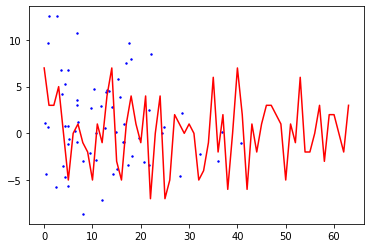

Epoch: 8950 Accurracy real: 0.53125 Accurracy fake: 0.6875
Epoch: 8951 Accurracy real: 0.359375 Accurracy fake: 0.515625
Epoch: 8952 Accurracy real: 0.796875 Accurracy fake: 0.546875
Epoch: 8953 Accurracy real: 0.828125 Accurracy fake: 0.46875
Epoch: 8954 Accurracy real: 0.828125 Accurracy fake: 0.453125
Epoch: 8955 Accurracy real: 0.828125 Accurracy fake: 0.359375
Epoch: 8956 Accurracy real: 0.890625 Accurracy fake: 0.328125
Epoch: 8957 Accurracy real: 0.734375 Accurracy fake: 0.375
Epoch: 8958 Accurracy real: 0.8125 Accurracy fake: 0.40625
Epoch: 8959 Accurracy real: 0.78125 Accurracy fake: 0.46875
Epoch: 8960 Accurracy real: 0.765625 Accurracy fake: 0.546875
Epoch: 8961 Accurracy real: 0.578125 Accurracy fake: 0.609375
Epoch: 8962 Accurracy real: 0.296875 Accurracy fake: 0.578125
Epoch: 8963 Accurracy real: 0.53125 Accurracy fake: 0.5625
Epoch: 8964 Accurracy real: 0.625 Accurracy fake: 0.546875
Epoch: 8965 Accurracy real: 0.578125 Accurracy fake: 0.5
Epoch: 8966 Accurracy real: 0.4

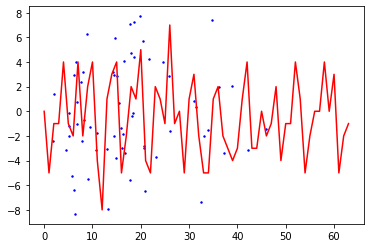

Epoch: 9000 Accurracy real: 0.203125 Accurracy fake: 0.75
Epoch: 9001 Accurracy real: 0.375 Accurracy fake: 0.703125
Epoch: 9002 Accurracy real: 0.71875 Accurracy fake: 0.546875
Epoch: 9003 Accurracy real: 0.84375 Accurracy fake: 0.5
Epoch: 9004 Accurracy real: 0.796875 Accurracy fake: 0.28125
Epoch: 9005 Accurracy real: 0.90625 Accurracy fake: 0.296875
Epoch: 9006 Accurracy real: 0.828125 Accurracy fake: 0.21875
Epoch: 9007 Accurracy real: 0.875 Accurracy fake: 0.21875
Epoch: 9008 Accurracy real: 0.84375 Accurracy fake: 0.25
Epoch: 9009 Accurracy real: 0.859375 Accurracy fake: 0.21875
Epoch: 9010 Accurracy real: 0.828125 Accurracy fake: 0.265625
Epoch: 9011 Accurracy real: 0.859375 Accurracy fake: 0.296875
Epoch: 9012 Accurracy real: 0.8125 Accurracy fake: 0.3125
Epoch: 9013 Accurracy real: 0.75 Accurracy fake: 0.375
Epoch: 9014 Accurracy real: 0.09375 Accurracy fake: 0.734375
Epoch: 9015 Accurracy real: 0.015625 Accurracy fake: 0.96875
Epoch: 9016 Accurracy real: 0.015625 Accurracy f

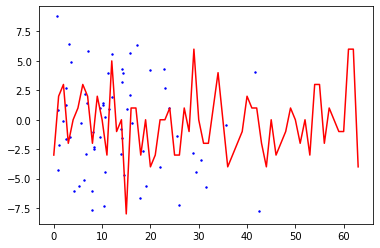

Epoch: 9050 Accurracy real: 0.296875 Accurracy fake: 0.53125
Epoch: 9051 Accurracy real: 0.234375 Accurracy fake: 0.6875
Epoch: 9052 Accurracy real: 0.28125 Accurracy fake: 0.640625
Epoch: 9053 Accurracy real: 0.171875 Accurracy fake: 0.734375
Epoch: 9054 Accurracy real: 0.21875 Accurracy fake: 0.640625
Epoch: 9055 Accurracy real: 0.25 Accurracy fake: 0.484375
Epoch: 9056 Accurracy real: 0.21875 Accurracy fake: 0.578125
Epoch: 9057 Accurracy real: 0.34375 Accurracy fake: 0.53125
Epoch: 9058 Accurracy real: 0.1875 Accurracy fake: 0.578125
Epoch: 9059 Accurracy real: 0.1875 Accurracy fake: 0.53125
Epoch: 9060 Accurracy real: 0.28125 Accurracy fake: 0.5625
Epoch: 9061 Accurracy real: 0.21875 Accurracy fake: 0.53125
Epoch: 9062 Accurracy real: 0.484375 Accurracy fake: 0.46875
Epoch: 9063 Accurracy real: 0.546875 Accurracy fake: 0.46875
Epoch: 9064 Accurracy real: 0.609375 Accurracy fake: 0.390625
Epoch: 9065 Accurracy real: 0.734375 Accurracy fake: 0.5625
Epoch: 9066 Accurracy real: 0.3281

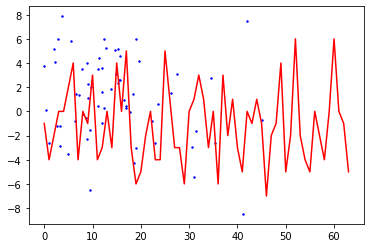

Epoch: 9100 Accurracy real: 0.296875 Accurracy fake: 0.625
Epoch: 9101 Accurracy real: 0.1875 Accurracy fake: 0.46875
Epoch: 9102 Accurracy real: 0.34375 Accurracy fake: 0.703125
Epoch: 9103 Accurracy real: 0.359375 Accurracy fake: 0.640625
Epoch: 9104 Accurracy real: 0.453125 Accurracy fake: 0.515625
Epoch: 9105 Accurracy real: 0.703125 Accurracy fake: 0.390625
Epoch: 9106 Accurracy real: 0.71875 Accurracy fake: 0.484375
Epoch: 9107 Accurracy real: 0.796875 Accurracy fake: 0.328125
Epoch: 9108 Accurracy real: 0.6875 Accurracy fake: 0.4375
Epoch: 9109 Accurracy real: 0.609375 Accurracy fake: 0.46875
Epoch: 9110 Accurracy real: 0.625 Accurracy fake: 0.5
Epoch: 9111 Accurracy real: 0.609375 Accurracy fake: 0.484375
Epoch: 9112 Accurracy real: 0.578125 Accurracy fake: 0.453125
Epoch: 9113 Accurracy real: 0.609375 Accurracy fake: 0.5625
Epoch: 9114 Accurracy real: 0.671875 Accurracy fake: 0.421875
Epoch: 9115 Accurracy real: 0.515625 Accurracy fake: 0.4375
Epoch: 9116 Accurracy real: 0.328

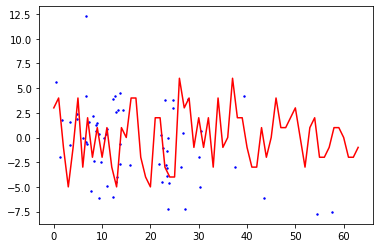

Epoch: 9150 Accurracy real: 0.578125 Accurracy fake: 0.59375
Epoch: 9151 Accurracy real: 0.375 Accurracy fake: 0.609375
Epoch: 9152 Accurracy real: 0.140625 Accurracy fake: 0.640625
Epoch: 9153 Accurracy real: 0.078125 Accurracy fake: 0.640625
Epoch: 9154 Accurracy real: 0.109375 Accurracy fake: 0.796875
Epoch: 9155 Accurracy real: 0.125 Accurracy fake: 0.765625
Epoch: 9156 Accurracy real: 0.09375 Accurracy fake: 0.8125
Epoch: 9157 Accurracy real: 0.125 Accurracy fake: 0.828125
Epoch: 9158 Accurracy real: 0.0625 Accurracy fake: 0.8125
Epoch: 9159 Accurracy real: 0.015625 Accurracy fake: 0.921875
Epoch: 9160 Accurracy real: 0.109375 Accurracy fake: 0.6875
Epoch: 9161 Accurracy real: 0.125 Accurracy fake: 0.65625
Epoch: 9162 Accurracy real: 0.09375 Accurracy fake: 0.703125
Epoch: 9163 Accurracy real: 0.328125 Accurracy fake: 0.640625
Epoch: 9164 Accurracy real: 0.453125 Accurracy fake: 0.59375
Epoch: 9165 Accurracy real: 0.8125 Accurracy fake: 0.5
Epoch: 9166 Accurracy real: 0.46875 Accu

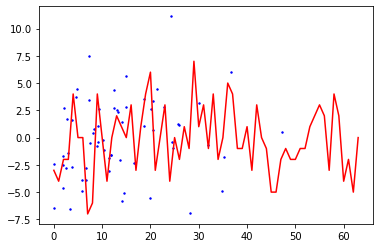

Epoch: 9200 Accurracy real: 0.09375 Accurracy fake: 0.71875
Epoch: 9201 Accurracy real: 0.0625 Accurracy fake: 0.796875
Epoch: 9202 Accurracy real: 0.03125 Accurracy fake: 0.84375
Epoch: 9203 Accurracy real: 0.015625 Accurracy fake: 0.875
Epoch: 9204 Accurracy real: 0.03125 Accurracy fake: 0.765625
Epoch: 9205 Accurracy real: 0.203125 Accurracy fake: 0.640625
Epoch: 9206 Accurracy real: 0.578125 Accurracy fake: 0.421875
Epoch: 9207 Accurracy real: 0.828125 Accurracy fake: 0.3125
Epoch: 9208 Accurracy real: 0.90625 Accurracy fake: 0.390625
Epoch: 9209 Accurracy real: 0.796875 Accurracy fake: 0.421875
Epoch: 9210 Accurracy real: 0.90625 Accurracy fake: 0.40625
Epoch: 9211 Accurracy real: 0.890625 Accurracy fake: 0.3125
Epoch: 9212 Accurracy real: 0.859375 Accurracy fake: 0.421875
Epoch: 9213 Accurracy real: 0.828125 Accurracy fake: 0.4375
Epoch: 9214 Accurracy real: 0.59375 Accurracy fake: 0.40625
Epoch: 9215 Accurracy real: 0.625 Accurracy fake: 0.546875
Epoch: 9216 Accurracy real: 0.46

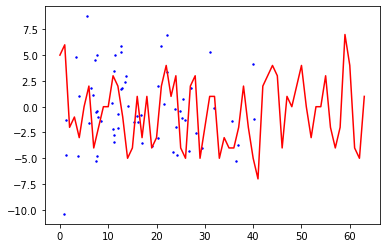

Epoch: 9250 Accurracy real: 0.15625 Accurracy fake: 0.734375
Epoch: 9251 Accurracy real: 0.1875 Accurracy fake: 0.6875
Epoch: 9252 Accurracy real: 0.234375 Accurracy fake: 0.6875
Epoch: 9253 Accurracy real: 0.28125 Accurracy fake: 0.546875
Epoch: 9254 Accurracy real: 0.515625 Accurracy fake: 0.46875
Epoch: 9255 Accurracy real: 0.453125 Accurracy fake: 0.53125
Epoch: 9256 Accurracy real: 0.546875 Accurracy fake: 0.625
Epoch: 9257 Accurracy real: 0.65625 Accurracy fake: 0.5
Epoch: 9258 Accurracy real: 0.5625 Accurracy fake: 0.609375
Epoch: 9259 Accurracy real: 0.53125 Accurracy fake: 0.5625
Epoch: 9260 Accurracy real: 0.40625 Accurracy fake: 0.640625
Epoch: 9261 Accurracy real: 0.265625 Accurracy fake: 0.65625
Epoch: 9262 Accurracy real: 0.09375 Accurracy fake: 0.84375
Epoch: 9263 Accurracy real: 0.15625 Accurracy fake: 0.796875
Epoch: 9264 Accurracy real: 0.0625 Accurracy fake: 0.75
Epoch: 9265 Accurracy real: 0.03125 Accurracy fake: 0.90625
Epoch: 9266 Accurracy real: 0.03125 Accurracy

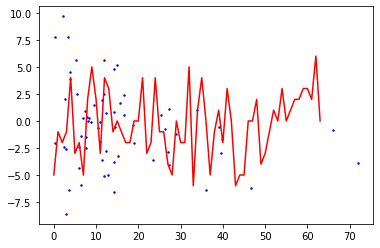

Epoch: 9300 Accurracy real: 0.28125 Accurracy fake: 0.578125
Epoch: 9301 Accurracy real: 0.328125 Accurracy fake: 0.5
Epoch: 9302 Accurracy real: 0.140625 Accurracy fake: 0.671875
Epoch: 9303 Accurracy real: 0.15625 Accurracy fake: 0.703125
Epoch: 9304 Accurracy real: 0.125 Accurracy fake: 0.84375
Epoch: 9305 Accurracy real: 0.03125 Accurracy fake: 0.890625
Epoch: 9306 Accurracy real: 0.0625 Accurracy fake: 0.8125
Epoch: 9307 Accurracy real: 0.15625 Accurracy fake: 0.71875
Epoch: 9308 Accurracy real: 0.265625 Accurracy fake: 0.6875
Epoch: 9309 Accurracy real: 0.21875 Accurracy fake: 0.515625
Epoch: 9310 Accurracy real: 0.296875 Accurracy fake: 0.5
Epoch: 9311 Accurracy real: 0.578125 Accurracy fake: 0.421875
Epoch: 9312 Accurracy real: 0.6875 Accurracy fake: 0.25
Epoch: 9313 Accurracy real: 0.578125 Accurracy fake: 0.3125
Epoch: 9314 Accurracy real: 0.5625 Accurracy fake: 0.375
Epoch: 9315 Accurracy real: 0.203125 Accurracy fake: 0.515625
Epoch: 9316 Accurracy real: 0.109375 Accurracy 

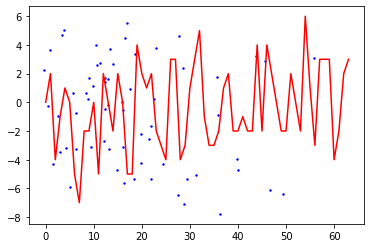

Epoch: 9350 Accurracy real: 0.9375 Accurracy fake: 0.140625
Epoch: 9351 Accurracy real: 0.921875 Accurracy fake: 0.1875
Epoch: 9352 Accurracy real: 0.890625 Accurracy fake: 0.265625
Epoch: 9353 Accurracy real: 0.8125 Accurracy fake: 0.15625
Epoch: 9354 Accurracy real: 0.859375 Accurracy fake: 0.21875
Epoch: 9355 Accurracy real: 0.1875 Accurracy fake: 0.6875
Epoch: 9356 Accurracy real: 0.03125 Accurracy fake: 0.875
Epoch: 9357 Accurracy real: 0.03125 Accurracy fake: 0.984375
Epoch: 9358 Accurracy real: 0.0 Accurracy fake: 0.90625
Epoch: 9359 Accurracy real: 0.015625 Accurracy fake: 0.984375
Epoch: 9360 Accurracy real: 0.015625 Accurracy fake: 1.0
Epoch: 9361 Accurracy real: 0.03125 Accurracy fake: 0.984375
Epoch: 9362 Accurracy real: 0.03125 Accurracy fake: 0.984375
Epoch: 9363 Accurracy real: 0.0625 Accurracy fake: 0.953125
Epoch: 9364 Accurracy real: 0.015625 Accurracy fake: 0.9375
Epoch: 9365 Accurracy real: 0.0625 Accurracy fake: 0.859375
Epoch: 9366 Accurracy real: 0.78125 Accurrac

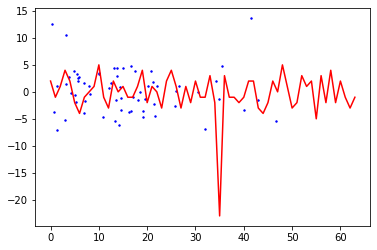

Epoch: 9400 Accurracy real: 0.921875 Accurracy fake: 0.1875
Epoch: 9401 Accurracy real: 0.875 Accurracy fake: 0.21875
Epoch: 9402 Accurracy real: 0.953125 Accurracy fake: 0.265625
Epoch: 9403 Accurracy real: 0.921875 Accurracy fake: 0.296875
Epoch: 9404 Accurracy real: 0.890625 Accurracy fake: 0.28125
Epoch: 9405 Accurracy real: 0.78125 Accurracy fake: 0.28125
Epoch: 9406 Accurracy real: 0.65625 Accurracy fake: 0.328125
Epoch: 9407 Accurracy real: 0.59375 Accurracy fake: 0.328125
Epoch: 9408 Accurracy real: 0.21875 Accurracy fake: 0.546875
Epoch: 9409 Accurracy real: 0.0625 Accurracy fake: 0.859375
Epoch: 9410 Accurracy real: 0.03125 Accurracy fake: 0.875
Epoch: 9411 Accurracy real: 0.046875 Accurracy fake: 0.890625
Epoch: 9412 Accurracy real: 0.046875 Accurracy fake: 0.90625
Epoch: 9413 Accurracy real: 0.015625 Accurracy fake: 0.921875
Epoch: 9414 Accurracy real: 0.015625 Accurracy fake: 0.96875
Epoch: 9415 Accurracy real: 0.078125 Accurracy fake: 0.90625
Epoch: 9416 Accurracy real: 0

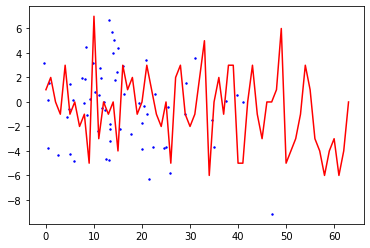

Epoch: 9450 Accurracy real: 0.109375 Accurracy fake: 0.828125
Epoch: 9451 Accurracy real: 0.09375 Accurracy fake: 0.8125
Epoch: 9452 Accurracy real: 0.0625 Accurracy fake: 0.671875
Epoch: 9453 Accurracy real: 0.078125 Accurracy fake: 0.796875
Epoch: 9454 Accurracy real: 0.03125 Accurracy fake: 0.84375
Epoch: 9455 Accurracy real: 0.09375 Accurracy fake: 0.765625
Epoch: 9456 Accurracy real: 0.359375 Accurracy fake: 0.625
Epoch: 9457 Accurracy real: 0.203125 Accurracy fake: 0.71875
Epoch: 9458 Accurracy real: 0.578125 Accurracy fake: 0.4375
Epoch: 9459 Accurracy real: 0.90625 Accurracy fake: 0.203125
Epoch: 9460 Accurracy real: 0.984375 Accurracy fake: 0.140625
Epoch: 9461 Accurracy real: 0.984375 Accurracy fake: 0.15625
Epoch: 9462 Accurracy real: 0.90625 Accurracy fake: 0.0625
Epoch: 9463 Accurracy real: 0.953125 Accurracy fake: 0.171875
Epoch: 9464 Accurracy real: 0.875 Accurracy fake: 0.140625
Epoch: 9465 Accurracy real: 0.625 Accurracy fake: 0.390625
Epoch: 9466 Accurracy real: 0.187

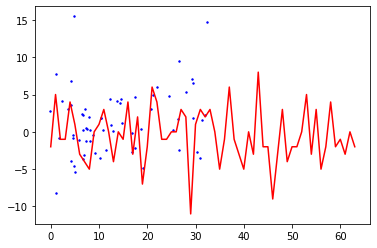

Epoch: 9500 Accurracy real: 0.078125 Accurracy fake: 0.671875
Epoch: 9501 Accurracy real: 0.09375 Accurracy fake: 0.734375
Epoch: 9502 Accurracy real: 0.09375 Accurracy fake: 0.890625
Epoch: 9503 Accurracy real: 0.09375 Accurracy fake: 0.75
Epoch: 9504 Accurracy real: 0.078125 Accurracy fake: 0.796875
Epoch: 9505 Accurracy real: 0.15625 Accurracy fake: 0.78125
Epoch: 9506 Accurracy real: 0.09375 Accurracy fake: 0.78125
Epoch: 9507 Accurracy real: 0.078125 Accurracy fake: 0.84375
Epoch: 9508 Accurracy real: 0.34375 Accurracy fake: 0.671875
Epoch: 9509 Accurracy real: 0.828125 Accurracy fake: 0.46875
Epoch: 9510 Accurracy real: 0.046875 Accurracy fake: 0.78125
Epoch: 9511 Accurracy real: 0.09375 Accurracy fake: 0.765625
Epoch: 9512 Accurracy real: 0.0625 Accurracy fake: 0.78125
Epoch: 9513 Accurracy real: 0.078125 Accurracy fake: 0.75
Epoch: 9514 Accurracy real: 0.109375 Accurracy fake: 0.765625
Epoch: 9515 Accurracy real: 0.046875 Accurracy fake: 0.765625
Epoch: 9516 Accurracy real: 0.0

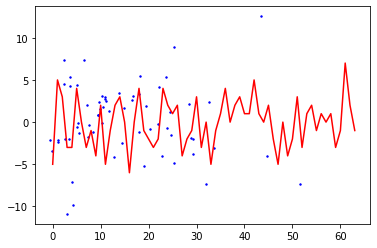

Epoch: 9550 Accurracy real: 0.796875 Accurracy fake: 0.484375
Epoch: 9551 Accurracy real: 0.875 Accurracy fake: 0.34375
Epoch: 9552 Accurracy real: 0.90625 Accurracy fake: 0.34375
Epoch: 9553 Accurracy real: 0.890625 Accurracy fake: 0.265625
Epoch: 9554 Accurracy real: 0.890625 Accurracy fake: 0.21875
Epoch: 9555 Accurracy real: 0.90625 Accurracy fake: 0.15625
Epoch: 9556 Accurracy real: 0.90625 Accurracy fake: 0.203125
Epoch: 9557 Accurracy real: 0.90625 Accurracy fake: 0.203125
Epoch: 9558 Accurracy real: 0.90625 Accurracy fake: 0.203125
Epoch: 9559 Accurracy real: 0.890625 Accurracy fake: 0.140625
Epoch: 9560 Accurracy real: 0.875 Accurracy fake: 0.21875
Epoch: 9561 Accurracy real: 0.921875 Accurracy fake: 0.25
Epoch: 9562 Accurracy real: 0.859375 Accurracy fake: 0.375
Epoch: 9563 Accurracy real: 0.90625 Accurracy fake: 0.328125
Epoch: 9564 Accurracy real: 0.875 Accurracy fake: 0.40625
Epoch: 9565 Accurracy real: 0.84375 Accurracy fake: 0.40625
Epoch: 9566 Accurracy real: 0.859375 A

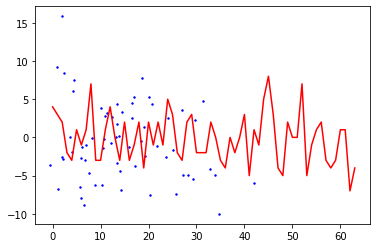

Epoch: 9600 Accurracy real: 0.046875 Accurracy fake: 0.828125
Epoch: 9601 Accurracy real: 0.265625 Accurracy fake: 0.90625
Epoch: 9602 Accurracy real: 0.109375 Accurracy fake: 0.8125
Epoch: 9603 Accurracy real: 0.046875 Accurracy fake: 0.828125
Epoch: 9604 Accurracy real: 0.015625 Accurracy fake: 0.859375
Epoch: 9605 Accurracy real: 0.390625 Accurracy fake: 0.796875
Epoch: 9606 Accurracy real: 0.8125 Accurracy fake: 0.46875
Epoch: 9607 Accurracy real: 0.921875 Accurracy fake: 0.25
Epoch: 9608 Accurracy real: 0.90625 Accurracy fake: 0.125
Epoch: 9609 Accurracy real: 0.921875 Accurracy fake: 0.15625
Epoch: 9610 Accurracy real: 0.921875 Accurracy fake: 0.125
Epoch: 9611 Accurracy real: 0.9375 Accurracy fake: 0.109375
Epoch: 9612 Accurracy real: 0.921875 Accurracy fake: 0.21875
Epoch: 9613 Accurracy real: 0.84375 Accurracy fake: 0.15625
Epoch: 9614 Accurracy real: 0.875 Accurracy fake: 0.296875
Epoch: 9615 Accurracy real: 0.875 Accurracy fake: 0.359375
Epoch: 9616 Accurracy real: 0.796875 

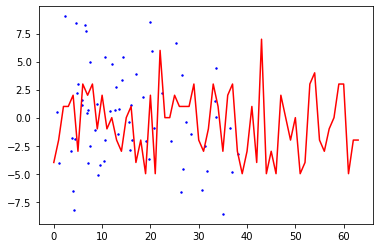

Epoch: 9650 Accurracy real: 0.015625 Accurracy fake: 0.96875
Epoch: 9651 Accurracy real: 0.0 Accurracy fake: 0.96875
Epoch: 9652 Accurracy real: 0.0 Accurracy fake: 0.953125
Epoch: 9653 Accurracy real: 0.046875 Accurracy fake: 0.96875
Epoch: 9654 Accurracy real: 0.0 Accurracy fake: 0.9375
Epoch: 9655 Accurracy real: 0.0625 Accurracy fake: 0.90625
Epoch: 9656 Accurracy real: 0.0625 Accurracy fake: 0.9375
Epoch: 9657 Accurracy real: 0.046875 Accurracy fake: 0.90625
Epoch: 9658 Accurracy real: 0.0625 Accurracy fake: 0.890625
Epoch: 9659 Accurracy real: 0.0625 Accurracy fake: 0.953125
Epoch: 9660 Accurracy real: 0.484375 Accurracy fake: 0.828125
Epoch: 9661 Accurracy real: 0.078125 Accurracy fake: 0.875
Epoch: 9662 Accurracy real: 0.140625 Accurracy fake: 0.796875
Epoch: 9663 Accurracy real: 0.484375 Accurracy fake: 0.65625
Epoch: 9664 Accurracy real: 0.671875 Accurracy fake: 0.46875
Epoch: 9665 Accurracy real: 0.765625 Accurracy fake: 0.359375
Epoch: 9666 Accurracy real: 0.75 Accurracy fa

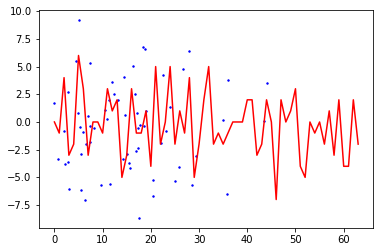

Epoch: 9700 Accurracy real: 0.359375 Accurracy fake: 0.546875
Epoch: 9701 Accurracy real: 0.5 Accurracy fake: 0.515625
Epoch: 9702 Accurracy real: 0.65625 Accurracy fake: 0.5625
Epoch: 9703 Accurracy real: 0.671875 Accurracy fake: 0.453125
Epoch: 9704 Accurracy real: 0.6875 Accurracy fake: 0.4375
Epoch: 9705 Accurracy real: 0.6875 Accurracy fake: 0.5
Epoch: 9706 Accurracy real: 0.625 Accurracy fake: 0.4375
Epoch: 9707 Accurracy real: 0.796875 Accurracy fake: 0.515625
Epoch: 9708 Accurracy real: 0.765625 Accurracy fake: 0.640625
Epoch: 9709 Accurracy real: 0.734375 Accurracy fake: 0.546875
Epoch: 9710 Accurracy real: 0.765625 Accurracy fake: 0.453125
Epoch: 9711 Accurracy real: 0.8125 Accurracy fake: 0.4375
Epoch: 9712 Accurracy real: 0.8125 Accurracy fake: 0.390625
Epoch: 9713 Accurracy real: 0.84375 Accurracy fake: 0.484375
Epoch: 9714 Accurracy real: 0.734375 Accurracy fake: 0.546875
Epoch: 9715 Accurracy real: 0.65625 Accurracy fake: 0.515625
Epoch: 9716 Accurracy real: 0.671875 Acc

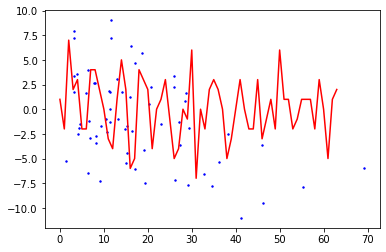

Epoch: 9750 Accurracy real: 0.859375 Accurracy fake: 0.234375
Epoch: 9751 Accurracy real: 0.90625 Accurracy fake: 0.328125
Epoch: 9752 Accurracy real: 0.84375 Accurracy fake: 0.21875
Epoch: 9753 Accurracy real: 0.703125 Accurracy fake: 0.59375
Epoch: 9754 Accurracy real: 0.03125 Accurracy fake: 0.90625
Epoch: 9755 Accurracy real: 0.03125 Accurracy fake: 0.90625
Epoch: 9756 Accurracy real: 0.015625 Accurracy fake: 0.921875
Epoch: 9757 Accurracy real: 0.015625 Accurracy fake: 0.984375
Epoch: 9758 Accurracy real: 0.046875 Accurracy fake: 0.921875
Epoch: 9759 Accurracy real: 0.09375 Accurracy fake: 0.90625
Epoch: 9760 Accurracy real: 0.296875 Accurracy fake: 0.6875
Epoch: 9761 Accurracy real: 0.5 Accurracy fake: 0.71875
Epoch: 9762 Accurracy real: 0.65625 Accurracy fake: 0.484375
Epoch: 9763 Accurracy real: 0.59375 Accurracy fake: 0.65625
Epoch: 9764 Accurracy real: 0.359375 Accurracy fake: 0.640625
Epoch: 9765 Accurracy real: 0.0625 Accurracy fake: 0.75
Epoch: 9766 Accurracy real: 0.0625 

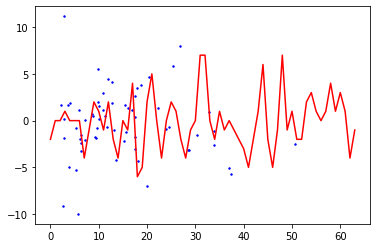

Epoch: 9800 Accurracy real: 0.015625 Accurracy fake: 0.875
Epoch: 9801 Accurracy real: 0.015625 Accurracy fake: 0.875
Epoch: 9802 Accurracy real: 0.078125 Accurracy fake: 0.890625
Epoch: 9803 Accurracy real: 0.0625 Accurracy fake: 0.90625
Epoch: 9804 Accurracy real: 0.453125 Accurracy fake: 0.78125
Epoch: 9805 Accurracy real: 0.65625 Accurracy fake: 0.546875
Epoch: 9806 Accurracy real: 0.765625 Accurracy fake: 0.46875
Epoch: 9807 Accurracy real: 0.890625 Accurracy fake: 0.484375
Epoch: 9808 Accurracy real: 0.765625 Accurracy fake: 0.546875
Epoch: 9809 Accurracy real: 0.671875 Accurracy fake: 0.515625
Epoch: 9810 Accurracy real: 0.359375 Accurracy fake: 0.59375
Epoch: 9811 Accurracy real: 0.109375 Accurracy fake: 0.5625
Epoch: 9812 Accurracy real: 0.03125 Accurracy fake: 0.796875
Epoch: 9813 Accurracy real: 0.015625 Accurracy fake: 0.84375
Epoch: 9814 Accurracy real: 0.0 Accurracy fake: 0.90625
Epoch: 9815 Accurracy real: 0.0625 Accurracy fake: 0.890625
Epoch: 9816 Accurracy real: 0.015

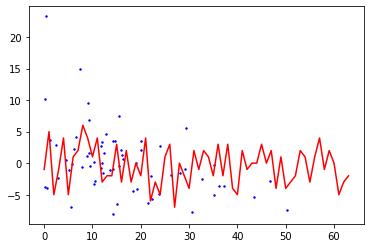

Epoch: 9850 Accurracy real: 0.390625 Accurracy fake: 0.578125
Epoch: 9851 Accurracy real: 0.671875 Accurracy fake: 0.515625
Epoch: 9852 Accurracy real: 0.671875 Accurracy fake: 0.265625
Epoch: 9853 Accurracy real: 0.8125 Accurracy fake: 0.3125
Epoch: 9854 Accurracy real: 0.796875 Accurracy fake: 0.375
Epoch: 9855 Accurracy real: 0.875 Accurracy fake: 0.34375
Epoch: 9856 Accurracy real: 0.8125 Accurracy fake: 0.375
Epoch: 9857 Accurracy real: 0.875 Accurracy fake: 0.3125
Epoch: 9858 Accurracy real: 0.796875 Accurracy fake: 0.375
Epoch: 9859 Accurracy real: 0.859375 Accurracy fake: 0.40625
Epoch: 9860 Accurracy real: 0.703125 Accurracy fake: 0.453125
Epoch: 9861 Accurracy real: 0.765625 Accurracy fake: 0.328125
Epoch: 9862 Accurracy real: 0.765625 Accurracy fake: 0.5
Epoch: 9863 Accurracy real: 0.5625 Accurracy fake: 0.484375
Epoch: 9864 Accurracy real: 0.40625 Accurracy fake: 0.625
Epoch: 9865 Accurracy real: 0.09375 Accurracy fake: 0.875
Epoch: 9866 Accurracy real: 0.015625 Accurracy f

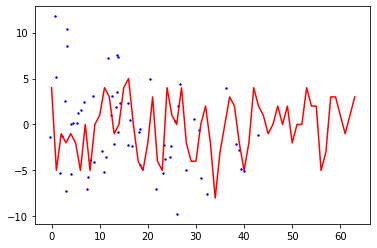

Epoch: 9900 Accurracy real: 0.265625 Accurracy fake: 0.765625
Epoch: 9901 Accurracy real: 0.203125 Accurracy fake: 0.625
Epoch: 9902 Accurracy real: 0.265625 Accurracy fake: 0.765625
Epoch: 9903 Accurracy real: 0.171875 Accurracy fake: 0.671875
Epoch: 9904 Accurracy real: 0.234375 Accurracy fake: 0.734375
Epoch: 9905 Accurracy real: 0.296875 Accurracy fake: 0.671875
Epoch: 9906 Accurracy real: 0.328125 Accurracy fake: 0.796875
Epoch: 9907 Accurracy real: 0.125 Accurracy fake: 0.859375
Epoch: 9908 Accurracy real: 0.125 Accurracy fake: 0.796875
Epoch: 9909 Accurracy real: 0.171875 Accurracy fake: 0.796875
Epoch: 9910 Accurracy real: 0.203125 Accurracy fake: 0.703125
Epoch: 9911 Accurracy real: 0.421875 Accurracy fake: 0.640625
Epoch: 9912 Accurracy real: 0.515625 Accurracy fake: 0.5625
Epoch: 9913 Accurracy real: 0.625 Accurracy fake: 0.578125
Epoch: 9914 Accurracy real: 0.578125 Accurracy fake: 0.390625
Epoch: 9915 Accurracy real: 0.421875 Accurracy fake: 0.65625
Epoch: 9916 Accurracy r

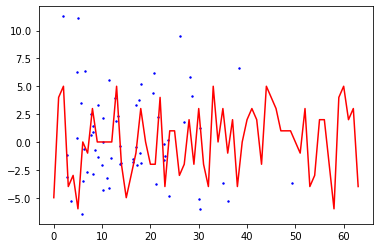

Epoch: 9950 Accurracy real: 0.640625 Accurracy fake: 0.40625
Epoch: 9951 Accurracy real: 0.546875 Accurracy fake: 0.515625
Epoch: 9952 Accurracy real: 0.296875 Accurracy fake: 0.703125
Epoch: 9953 Accurracy real: 0.0625 Accurracy fake: 0.828125
Epoch: 9954 Accurracy real: 0.265625 Accurracy fake: 0.859375
Epoch: 9955 Accurracy real: 0.03125 Accurracy fake: 0.953125
Epoch: 9956 Accurracy real: 0.03125 Accurracy fake: 0.921875
Epoch: 9957 Accurracy real: 0.03125 Accurracy fake: 0.875
Epoch: 9958 Accurracy real: 0.046875 Accurracy fake: 0.90625
Epoch: 9959 Accurracy real: 0.09375 Accurracy fake: 0.9375
Epoch: 9960 Accurracy real: 0.046875 Accurracy fake: 0.90625
Epoch: 9961 Accurracy real: 0.109375 Accurracy fake: 0.890625
Epoch: 9962 Accurracy real: 0.09375 Accurracy fake: 0.890625
Epoch: 9963 Accurracy real: 0.109375 Accurracy fake: 0.84375
Epoch: 9964 Accurracy real: 0.109375 Accurracy fake: 0.859375
Epoch: 9965 Accurracy real: 0.078125 Accurracy fake: 0.921875
Epoch: 9966 Accurracy re

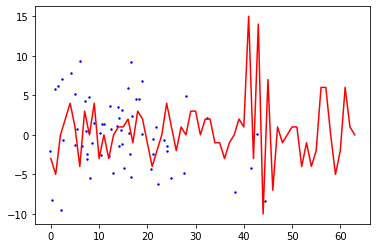

In [15]:
# size of the latent space
latent_dim = 5
# number of epochs
n_epochs = 10000
# batchsize
n_batch = 64
# evaluate every n epoch
n_eval = 50
# accuracy array[2, epoch] -> 2: acc real, accfake -> epoch: number epochs
accarr_real = []
accarr_fake = []
# path to sensor
path_sensor = '../data/Exercises_SS22/sleeplab_dataset_10hz/patient_29_male_7_years/BeinLI_10HZ.csv'
# load data, its X without label!
data = load_data(path_sensor)
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)

# train model
train(generator, discriminator, gan_model, latent_dim, path_sensor, n_epochs, n_batch, n_eval)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


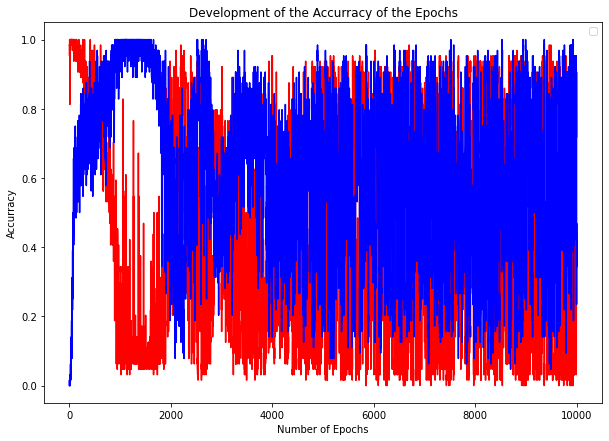

In [16]:
accarr_real = np.asarray(accarr_real).reshape((len(accarr_real),1))
accarr_fake = np.asarray(accarr_fake).reshape((len(accarr_fake),1))
    
plt.figure(figsize=(10, 7)) 
plt.legend()
    
plt.title('Development of the Accurracy of the Epochs')
plt.xlabel("Number of Epochs")
plt.ylabel("Accurracy")
    
plt.plot(np.arange(n_epochs), accarr_real, color='red', label='acc_real')
plt.plot(np.arange(n_epochs), accarr_fake, color='blue', label='acc_fake')

## sources:

https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/

https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/